# Uncertainty analysis

Here we will demonstrate a full uncertainty analysis of the inversion. We use a stochastic approach, where we 1) choose the important input parameters to the inversion, 2) define each of there uncertainty distributions, 3) run a series of inversions which sample these inputs from their uncertainty distributions, and 4) use the ensemble of inverted topography models to define the mean result and the uncertainty.

## Import packages

In [28]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import copy
import logging
import pathlib
import pickle
import string

import numpy as np
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    plotting,
    regional,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load results from notebook `Combining it all`

In [2]:
# load pickle files
params = []
with pathlib.Path("tmp/combining_it_all_results.pickle").open("rb") as file:
    while True:
        try:
            params.append(pickle.load(file))
        except EOFError:
            break
(
    grav_df,
    constraint_points,
    grids,
    inversion_results,
    kwargs,
    regional_grav_kwargs,
    starting_prisms,
) = params

In [3]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df.describe()

northing      easting  upward  upper_surface_grav  \
count   1271.000000   1271.00000  1271.0         1271.000000   
mean   15000.000000  20000.00000  1001.0           -0.129593   
std     8947.792584  11836.81698     0.0            7.145748   
min        0.000000      0.00000  1001.0          -17.177055   
25%     7000.000000  10000.00000  1001.0           -5.536755   
50%    15000.000000  20000.00000  1001.0           -1.136080   
75%    23000.000000  30000.00000  1001.0            3.743265   
max    30000.000000  40000.00000  1001.0           19.577307   

       lower_surface_grav  observed_grav  gravity_anomaly  uncert  \
count         1271.000000    1271.000000      1271.000000  1271.0   
mean             0.027047      -0.102546        -0.102546     0.1   
std              2.154778       7.752197         7.751312     0.0   
min             -3.056356     -16.597712       -16.635477     0.1   
25%             -1.791650      -6.494732        -6.437639     0.1   
50%             -0.467373      -0.043191        -0.069862     0.1   
75%              1.619060       5.173712         5.178012     0.1   
max              4.926267      20.079649        20.249863     0.1   

       starting_gravity     true_res       misfit          reg          res  
count       1271.000000  1271.000000  1271.000000  1271.000000  1271.000000  
mean           1.079720    -1.209313    -1.182266    -1.312208     0.129942  
std            6.597839     4.455588     5.205841     0.000000     5.205841  
min           -7.882305   -19.207718   -20.374110    -1.312208   -19.061902  
25%           -3.943540    -2.605356    -3.678875    -1.312208    -2.366668  
50%           -0.765558    -1.096721    -1.716378    -1.312208    -0.404170  
75%            4.822521     0.340201     1.410105    -1.312208     2.722313  
max           22.155483    12.726276    13.696065    -1.312208    15.008273

In [4]:
constraint_points.describe()

easting      northing  true_upward      upward     uncert  \
count     15.000000     15.000000    15.000000   15.000000  15.000000   
mean   18971.649226  16518.655913   486.549468  484.562022   9.730989   
std    10839.669022   8540.046257    76.458294   78.839833   1.529166   
min     3505.581182   1697.178371   407.011208  395.058844   8.140224   
25%    11575.107009  10553.975772   420.851161  422.696570   8.417023   
50%    19995.535031  16357.717739   470.155613  475.672915   9.403112   
75%    27651.208305  24233.535276   513.202664  507.374482  10.264053   
max    38163.601456  27603.626012   655.102400  656.749723  13.102048   

          weight  inverted_topography  
count  15.000000            15.000000  
mean    0.011213           487.160746  
std     0.002999            81.289113  
min     0.005825           392.343369  
25%     0.009493           420.756406  
50%     0.011310           469.241415  
75%     0.014116           513.323448  
max     0.015091           659.657132

In [5]:
true_topography = grids.true
lower_topography = grids.lower
starting_topography = grids.starting
final_topography = grids.inverted

In [6]:
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [7]:
kwargs

{'max_iterations': 200,
 'l2_norm_tolerance': 0.3,
 'delta_l2_norm_tolerance': 1.008}

In [8]:
regional_grav_kwargs["constraints_df"] = constraint_points
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 100,
  'damping_limits': (1e-20, 10),
  'depth_limits': (100, 100000.0),
  'progressbar': False,
  'fname': 'tmp/regional_sep'},
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   655.102400  656.749723  13.102048  0.005825   
 1   30636.914105   6974.789900   407.011208  405.935844   8.140224  0.015091   
 2   17659.550795  13659.470931   470.155613  476.177579   9.403112  0.011310   
 3   28491.676758  27073.768551   515.239653  516.320627  10.304793  0.009417   
 4   38163.601456   1697.178371   419.197817  414.706788   8.383956  0.014227   
 5   21462.843076  17815.369689   472.257595  475.672915   9.445152  0.011209   
 6   20042.577619  27603.626012   417.272882  428.155359   8.345458  0.014358   
 7    3737.943068   7448.480613   578.101458  5

# Extract parameters

In [9]:
parameters

{'Density contrast(s)': '[2641.92282038] kg/m3',
 'Reference level': '484.56202153982827 m',
 'Max iterations': 200,
 'L2 norm tolerance': '0.3',
 'Delta L2 norm tolerance': '1.008',
 'Deriv type': 'annulus',
 'Solver type': 'scipy least squares',
 'Solver damping': 0.023193756214638702,
 'Upper confining layer': 'Not enabled',
 'Lower confining layer': 'Not enabled',
 'Regularization weighting grid': 'Not enabled',
 'Time elapsed': '1 seconds',
 'Avg. iteration time': '0.5 seconds',
 'Final misfit RMSE / L2-norm': '0.0516 /0.2271 mGal',
 'Termination reason': ['l2-norm tolerance'],
 'Iteration times': [0.29796740200254135,
  0.7845776040048804,
  0.42175955598941073]}

In [10]:
density_contrast = float(parameters["Density contrast(s)"][1:-7])
zref = float(parameters["Reference level"][:-2])
spacing = utils.get_spacing(grav_df)
region = vd.get_region((grav_df.easting, grav_df.northing))
solver_damping = parameters["Solver damping"]

print(f"Density contrast: {density_contrast} kg/m3")
print(f"Reference level: {zref} m")
print(f"Spacing: {spacing} m")
print(f"Region: {region}")
print(f"Solver damping: {solver_damping}")

Density contrast: 2641.92282038 kg/m3
Reference level: 484.56202153982827 m
Spacing: 1000.0 m
Region: (np.float64(0.0), np.float64(40000.0), np.float64(0.0), np.float64(30000.0))
Solver damping: 0.023193756214638702


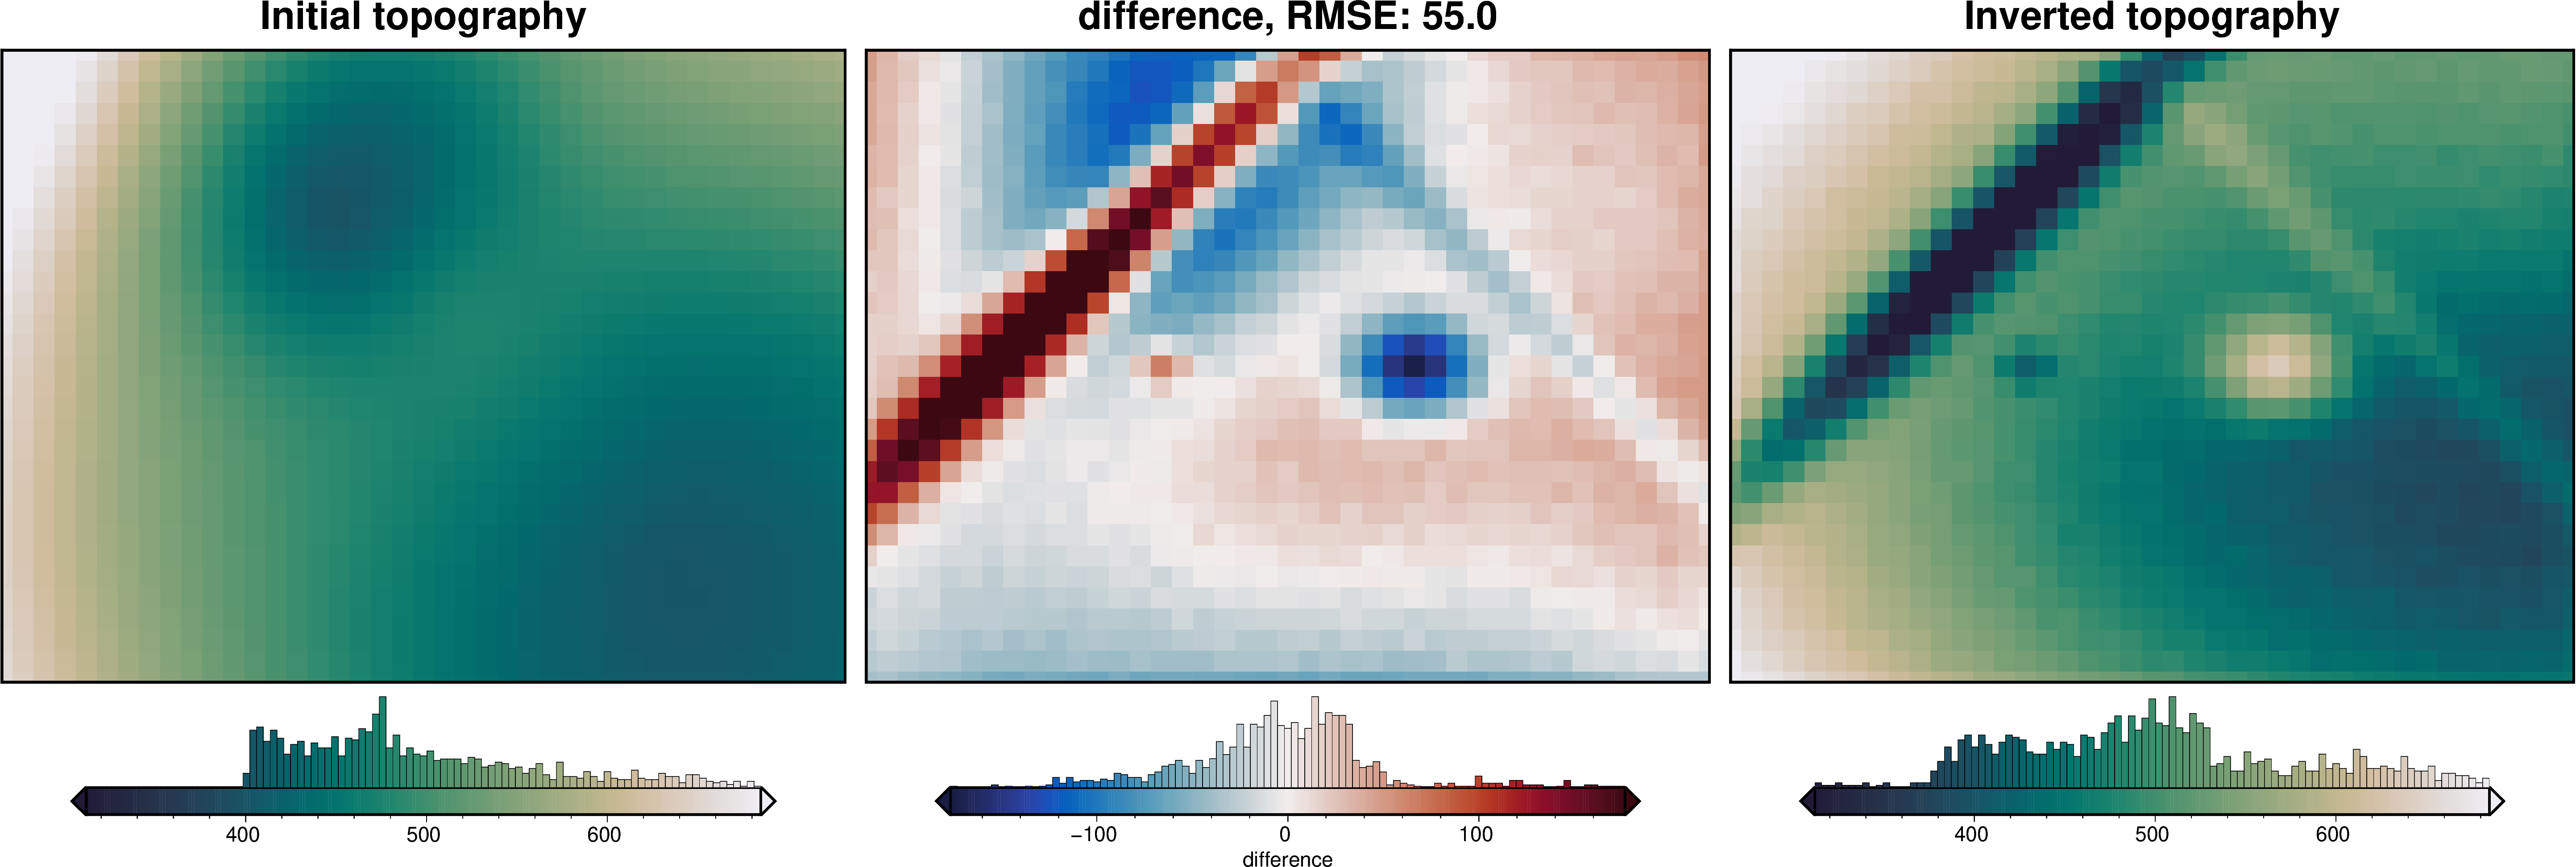

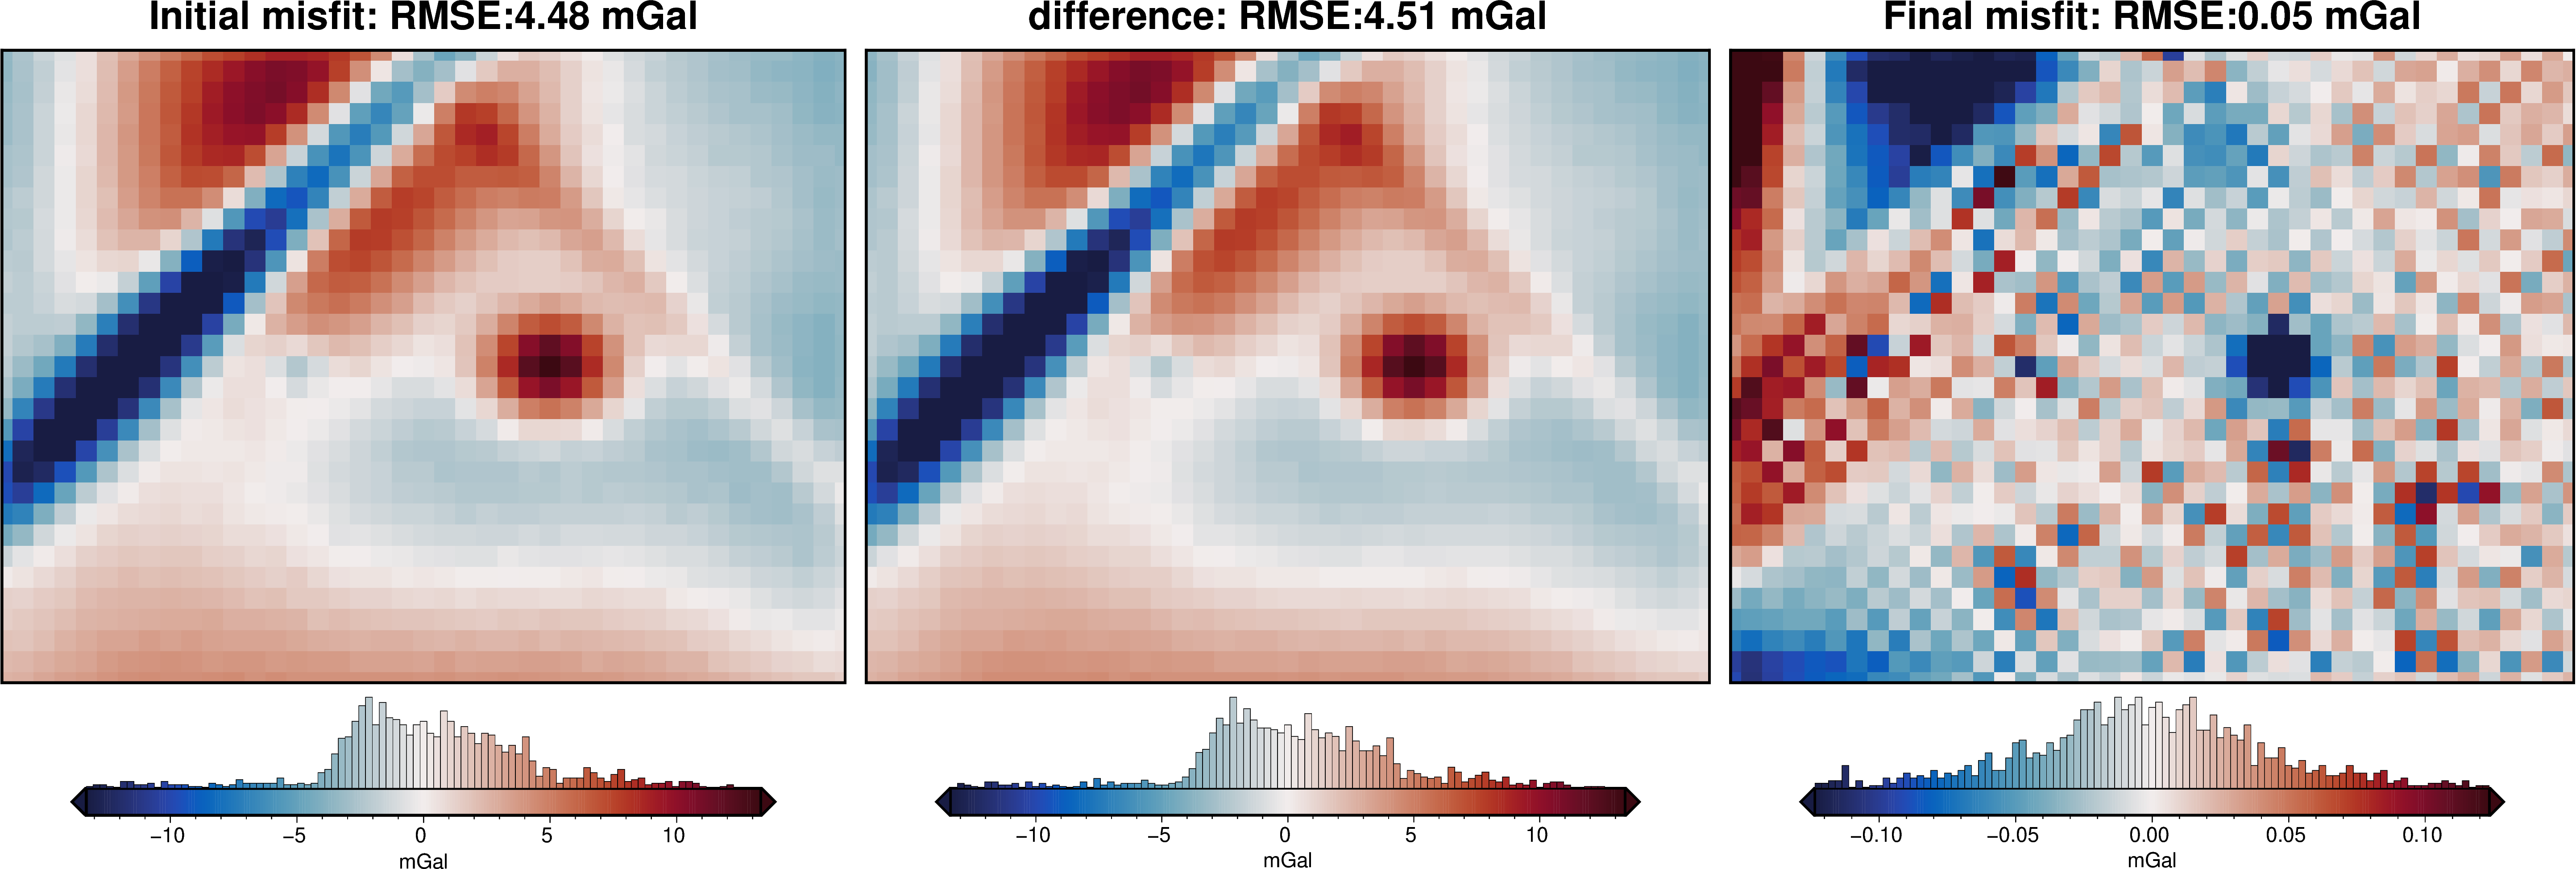

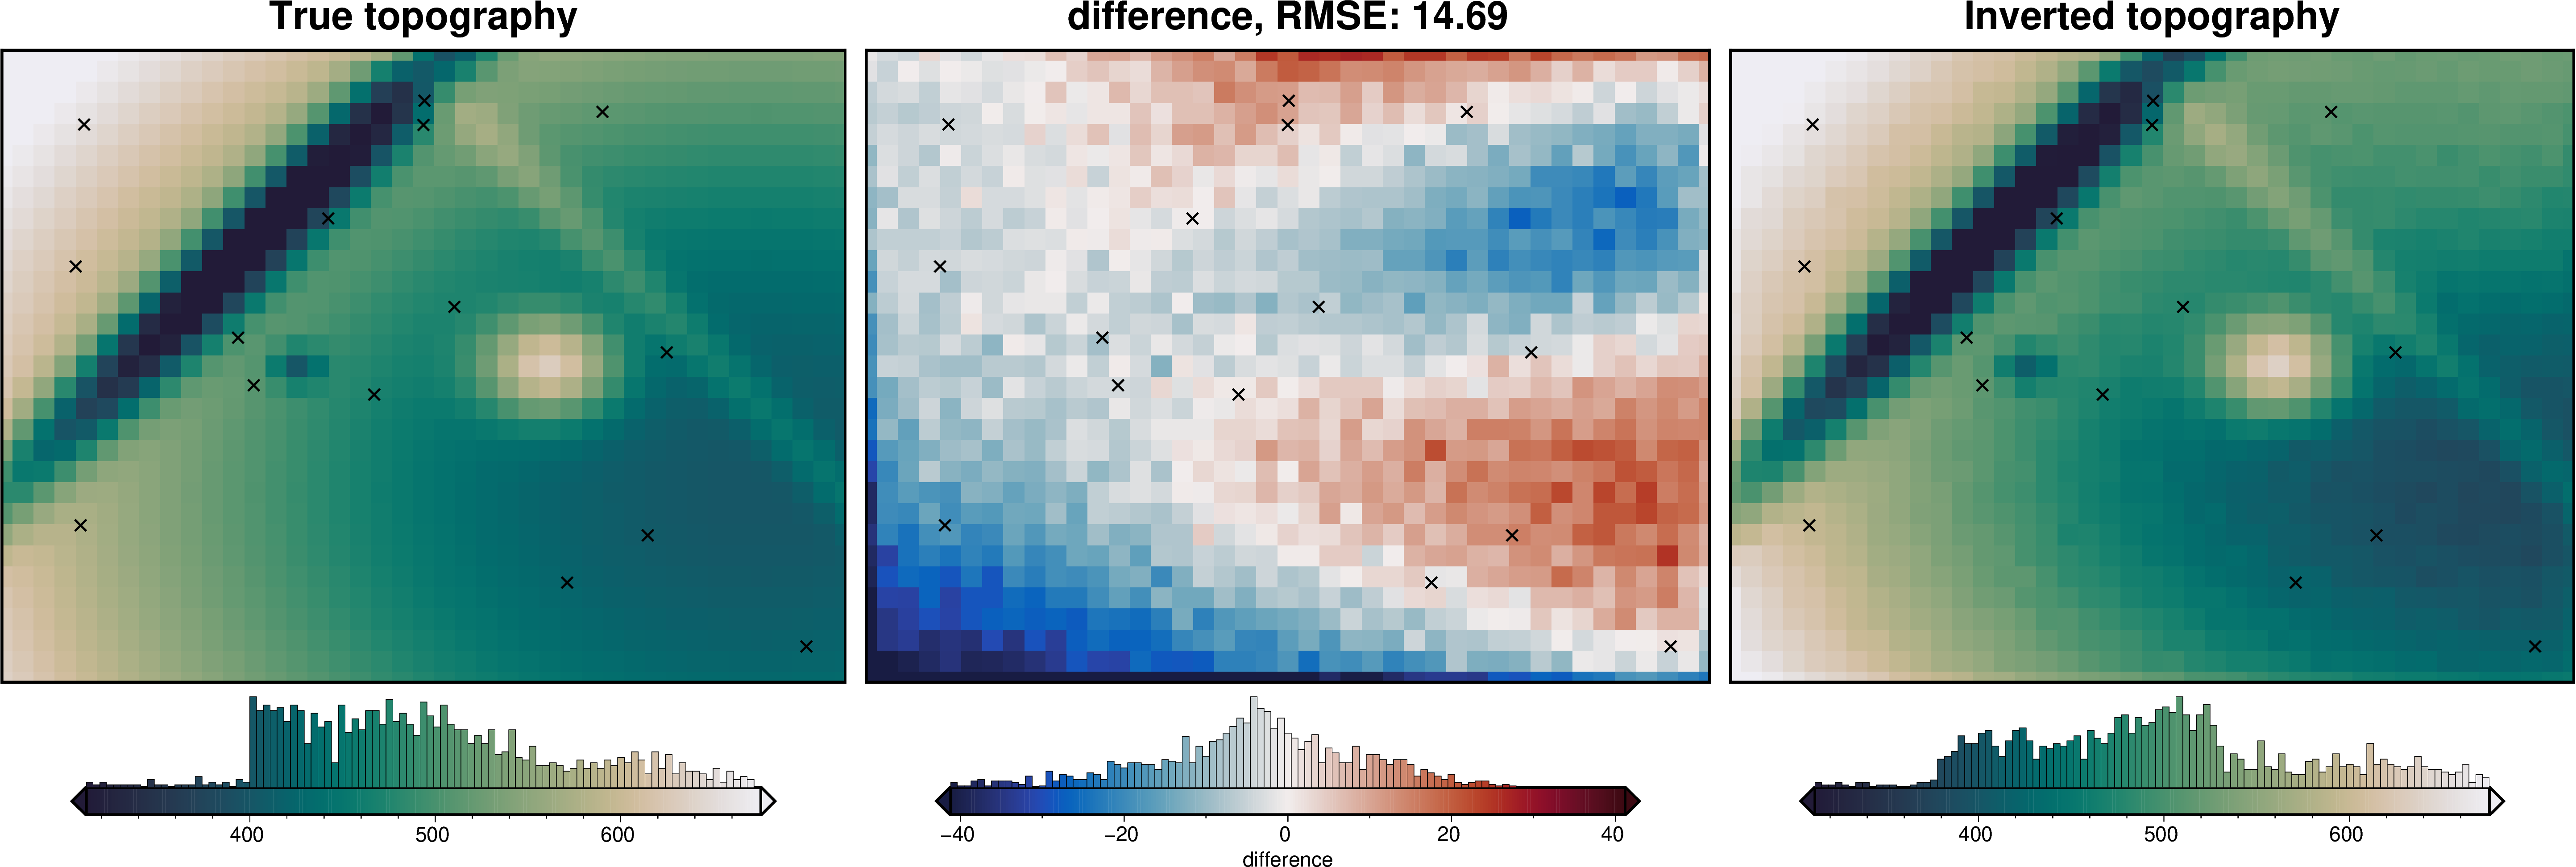

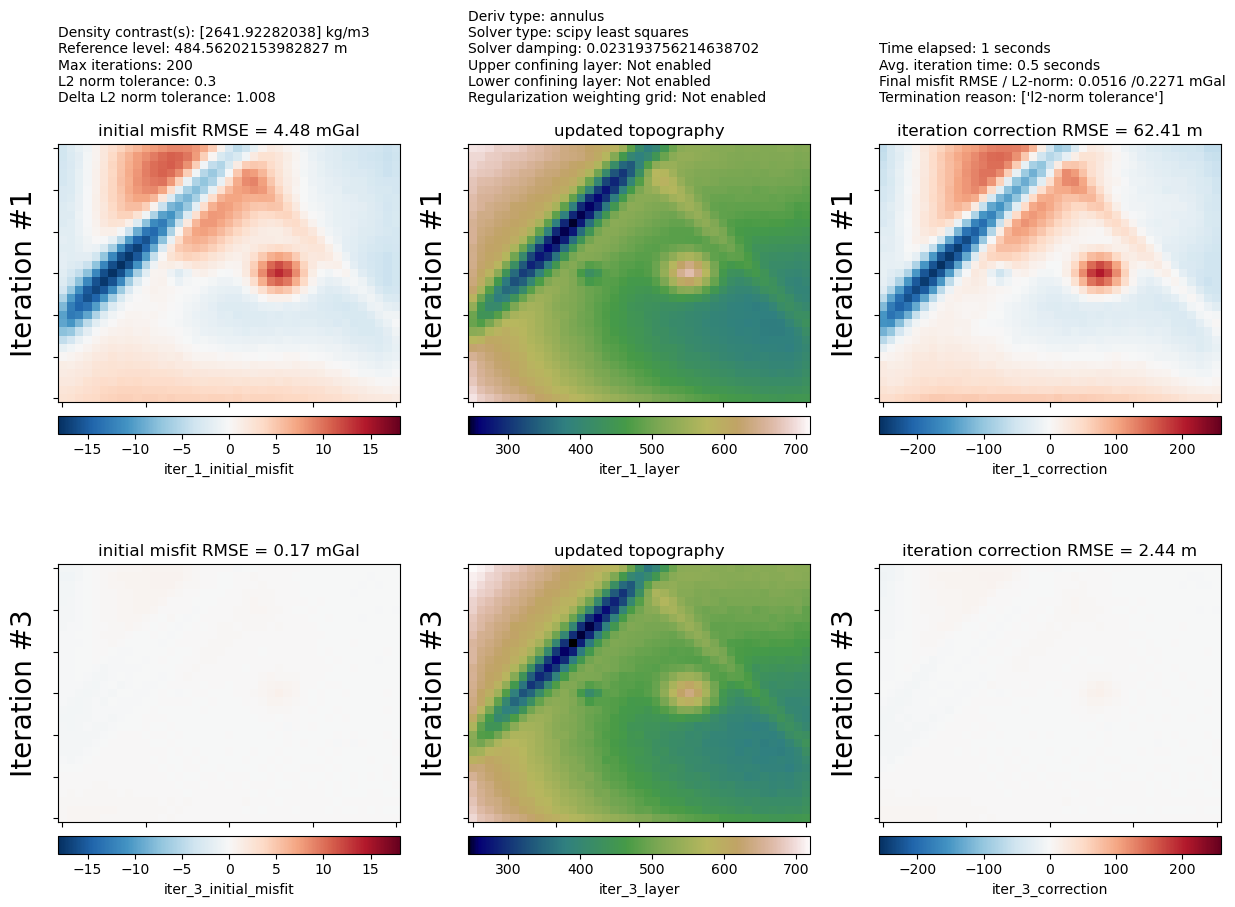

In [11]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

# Uncertainty analysis

## Absolute value of inversion error

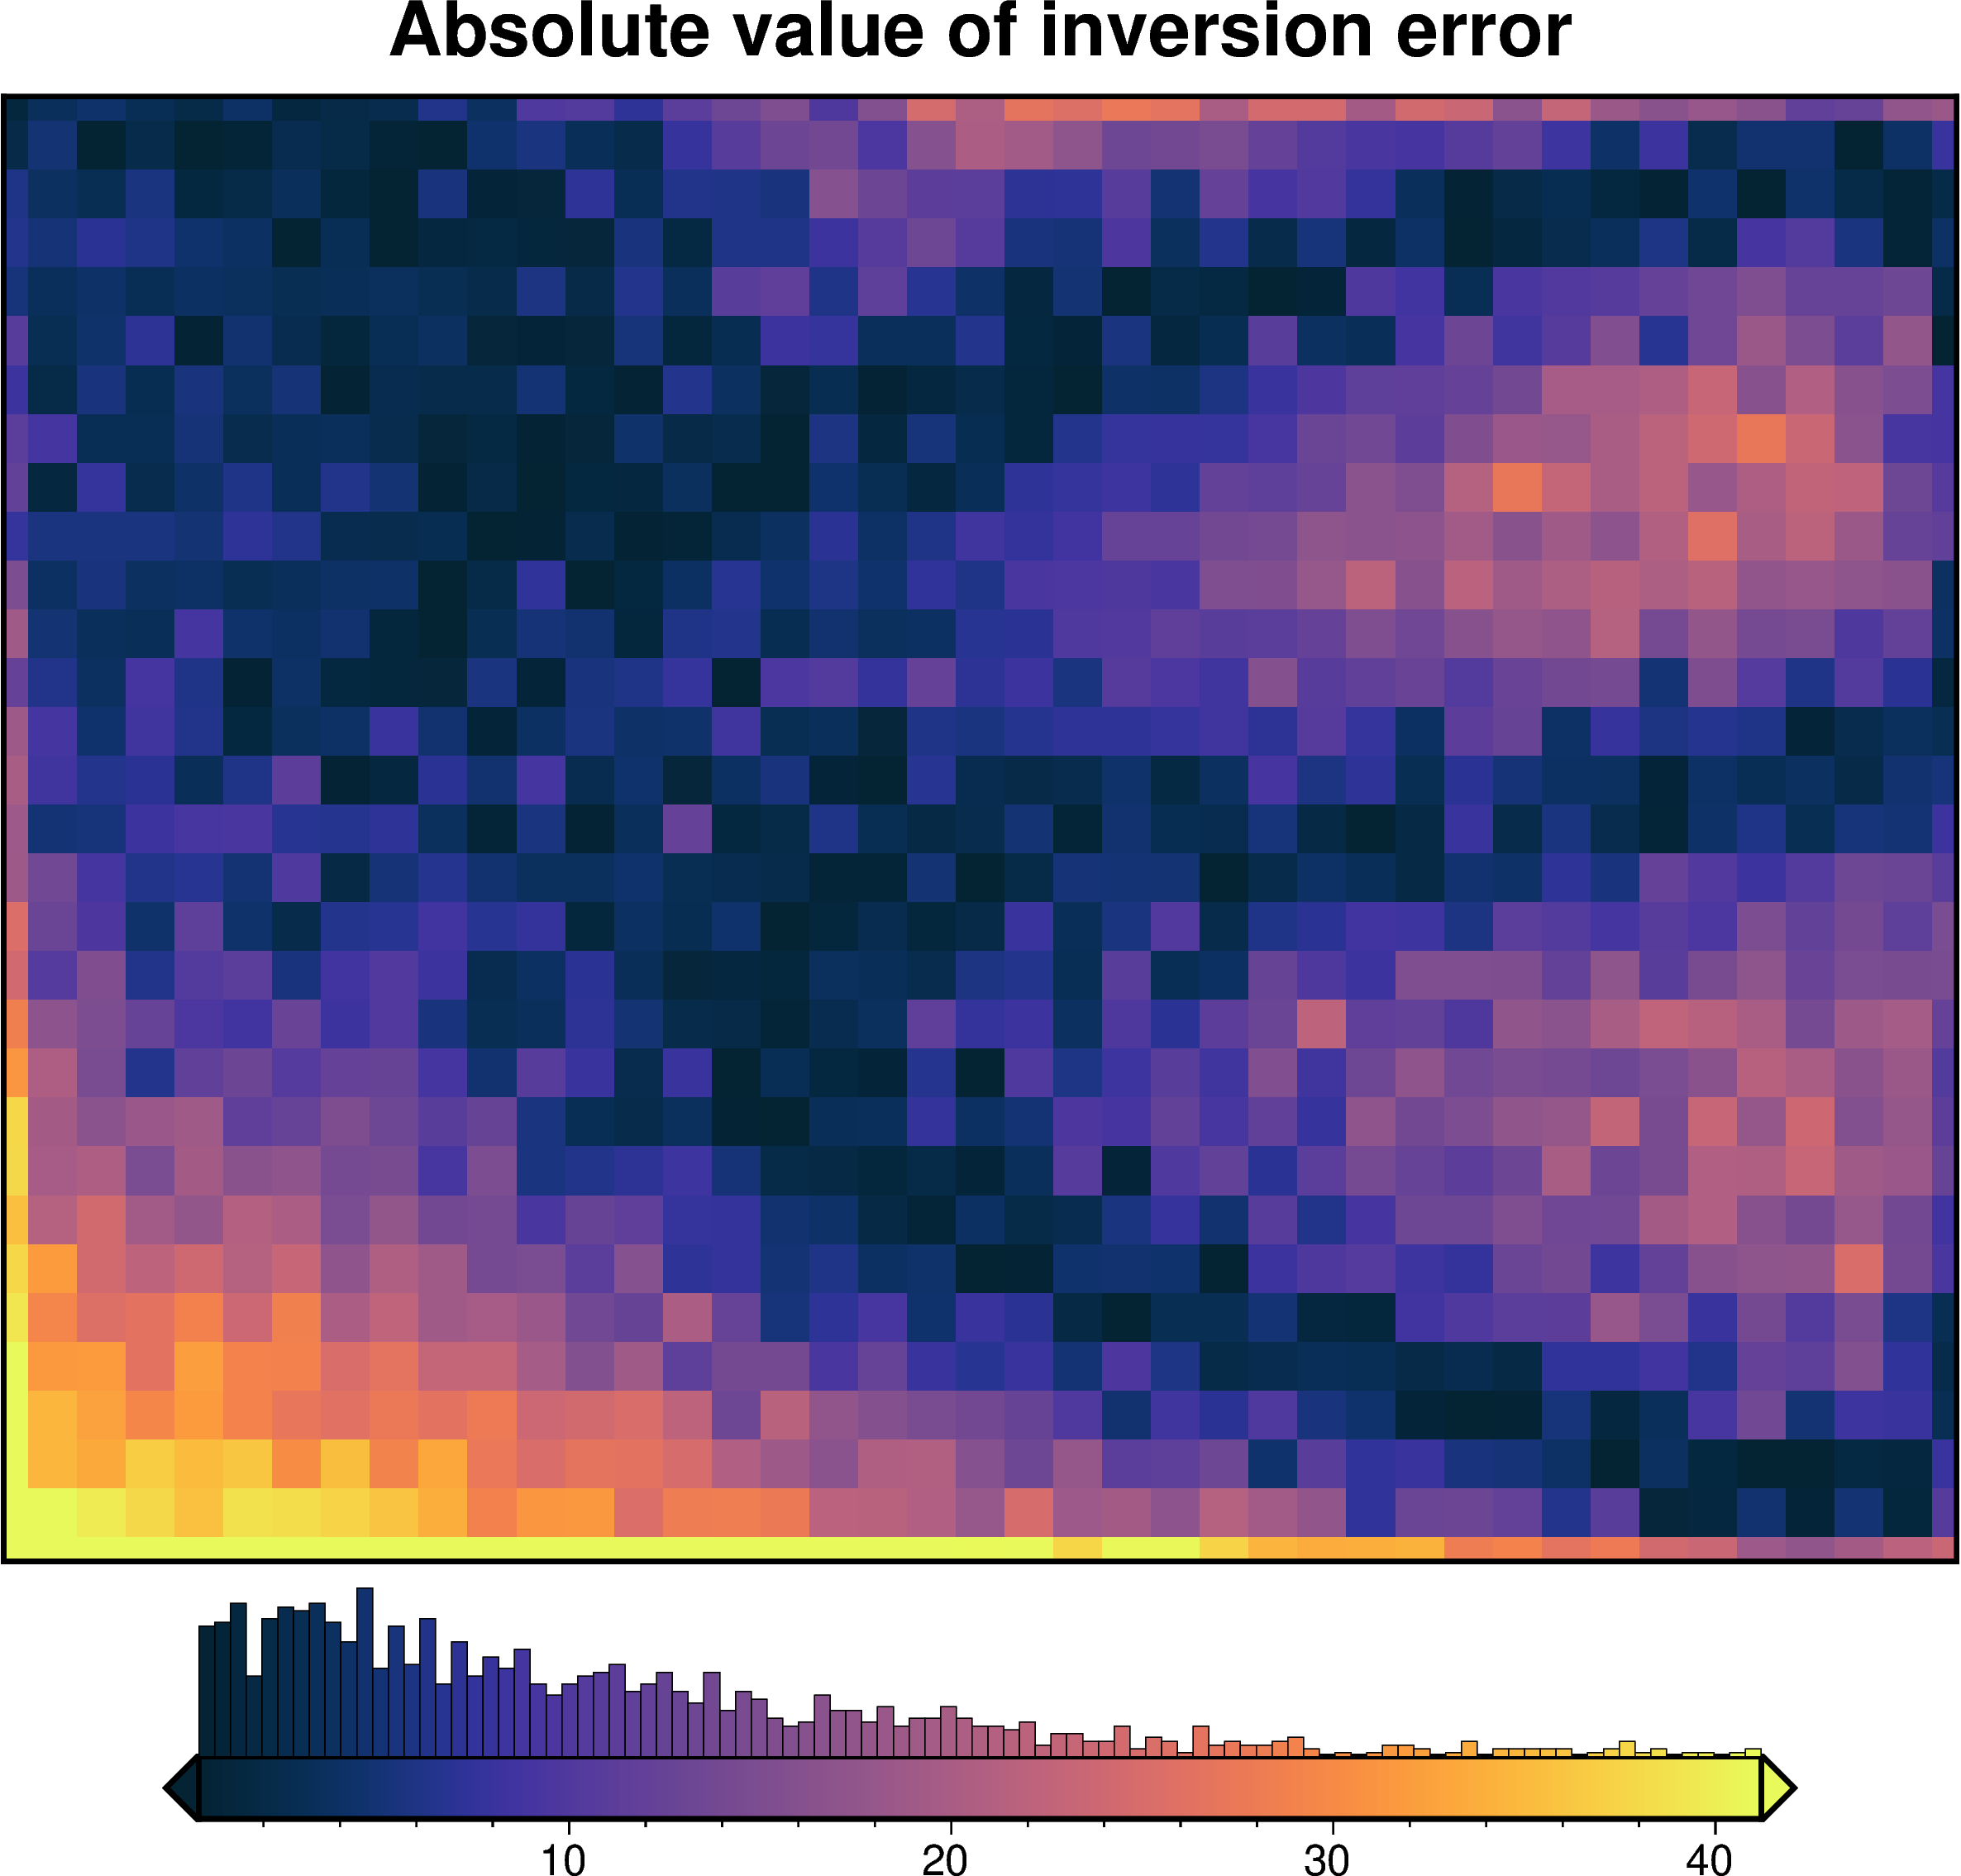

In [12]:
inversion_error = np.abs(true_topography - final_topography)
fig = maps.plot_grd(
    inversion_error.sel(
        {
            "easting": slice(*region[:2]),
            "northing": slice(*region[2:]),
        }
    ),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
)
fig.show()

## Starting topography uncertainty

Here we will estimate an uncertainty distribution for the spline damping value used in creating the starting topography.We then re-create the starting topography a number of times, each using a randomly sampled value for the the damping parameter from within it's uncertainty range. The cell-wise standard deviation of this ensemble will give us an idea of the uncertainty of the starting topography generation. Each repetition of the ensemble will also randomly sample the constraint depths from within their uncertainties.

In [13]:
# get best damping value used when creating grid
best_spline_damping = starting_topography.attrs["damping"]
best_spline_damping

np.float64(3.430469286314926e-07)

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 6.379332559602493e-07, min: 2.598077917117874e-08, max: 4.529548342955306e-06


starting topography ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

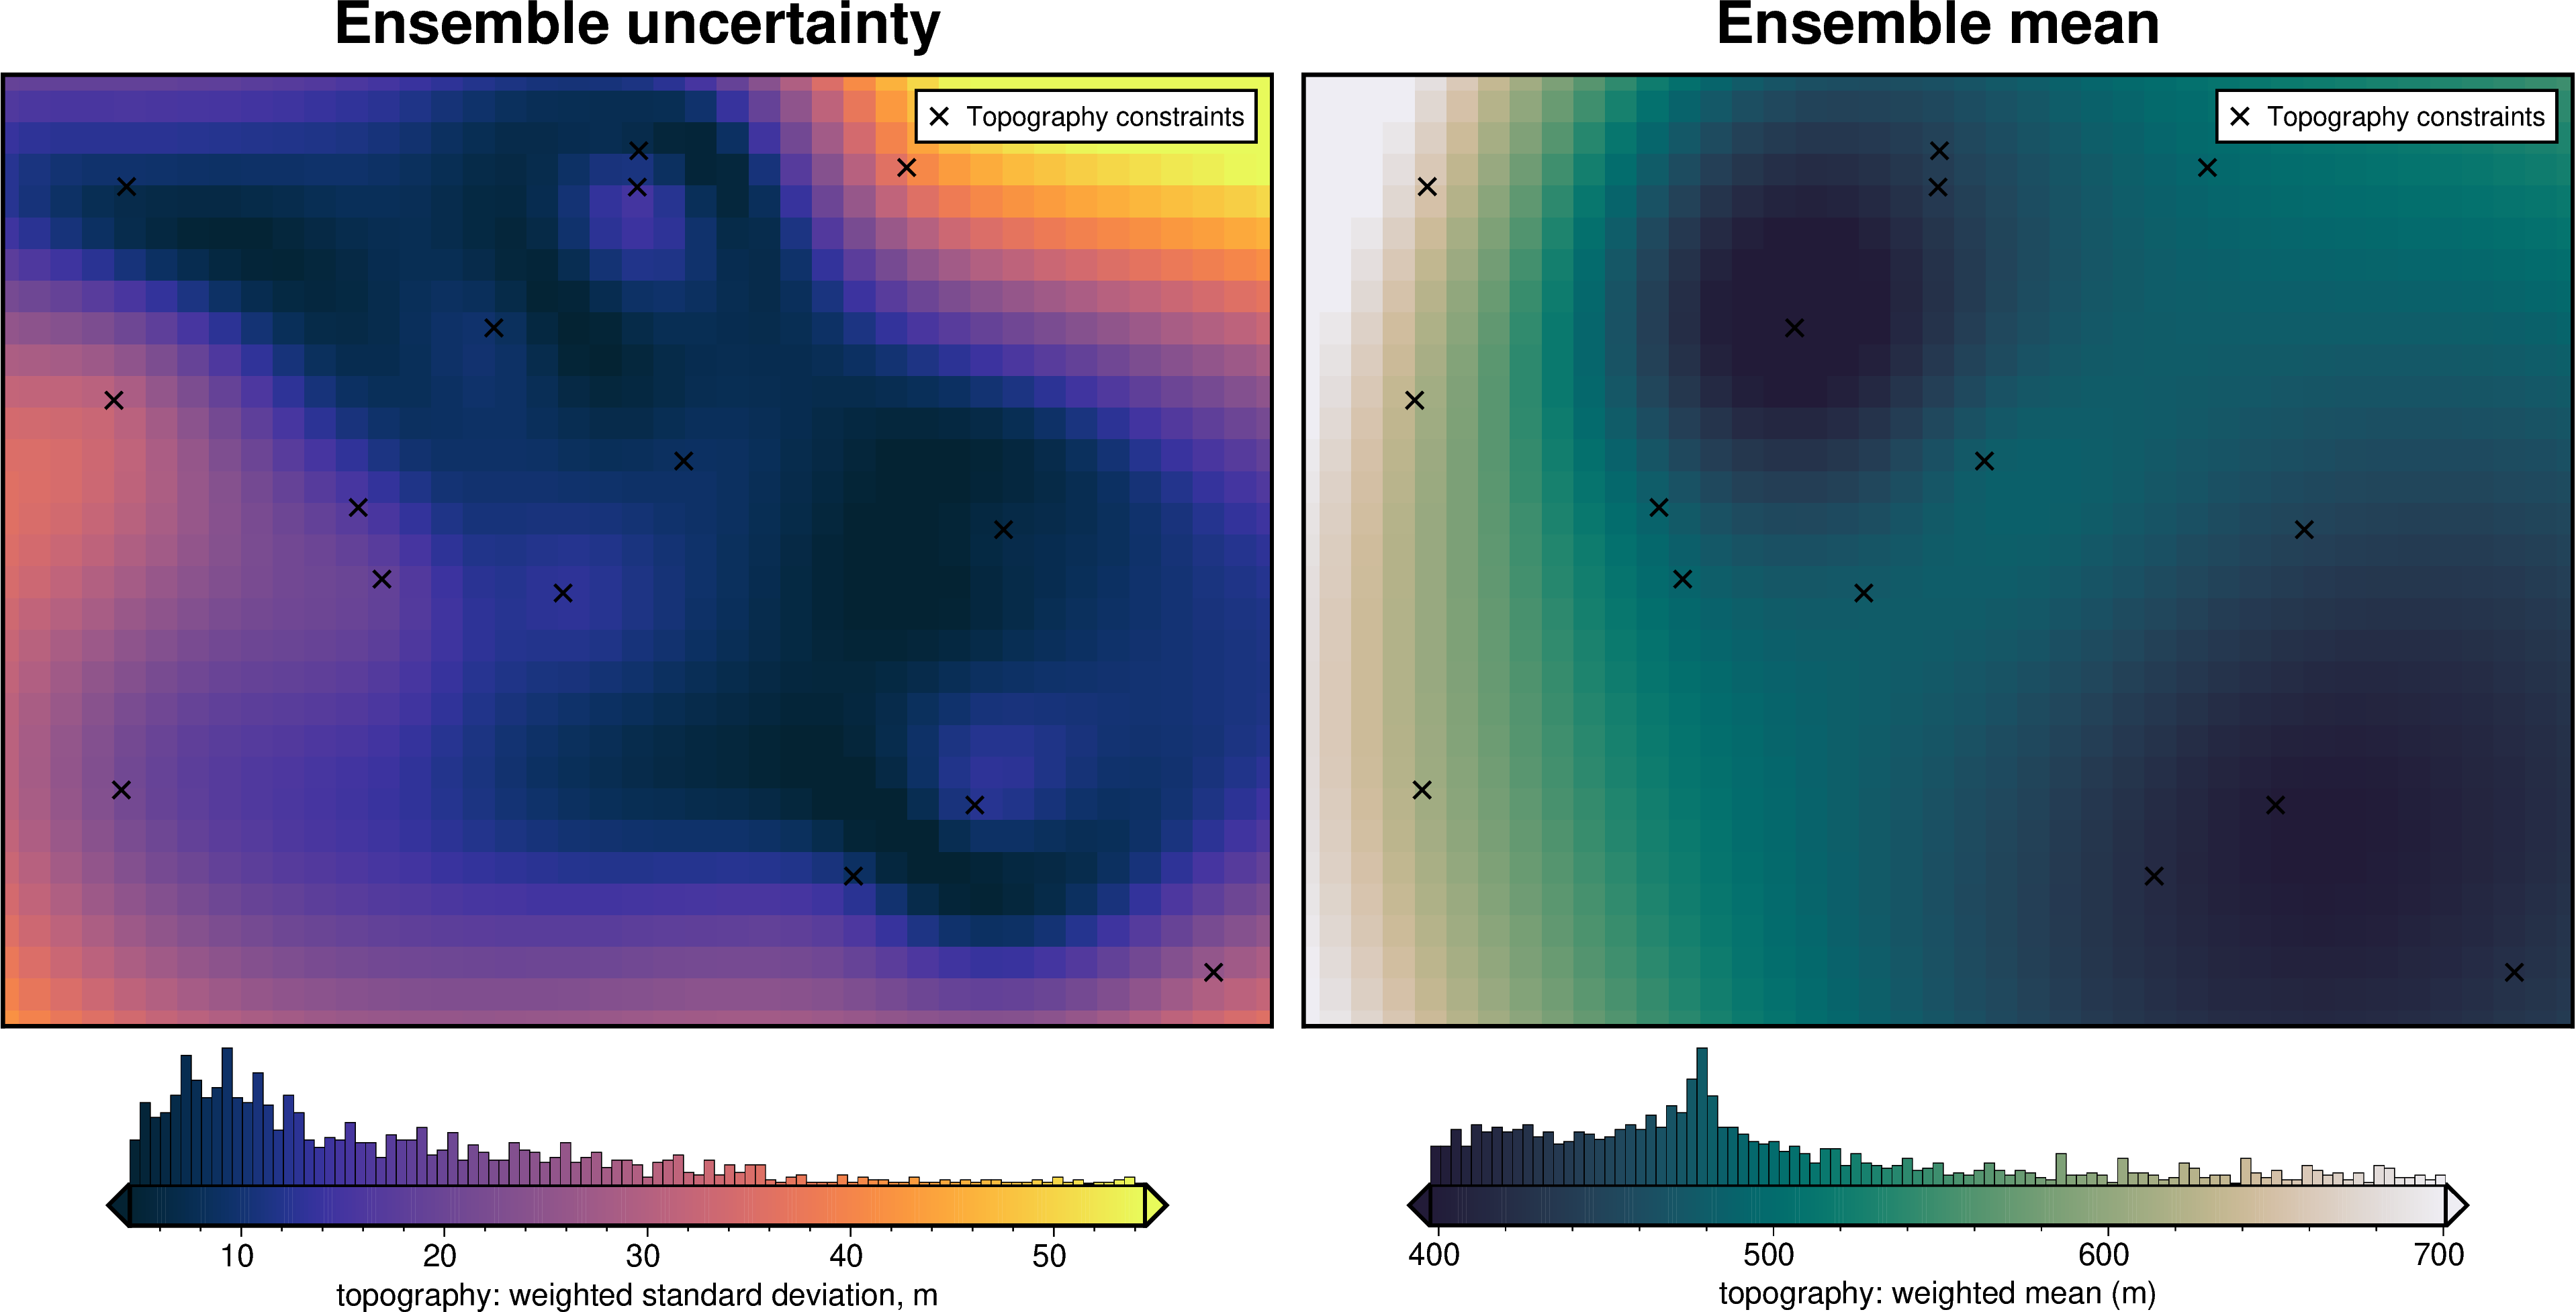

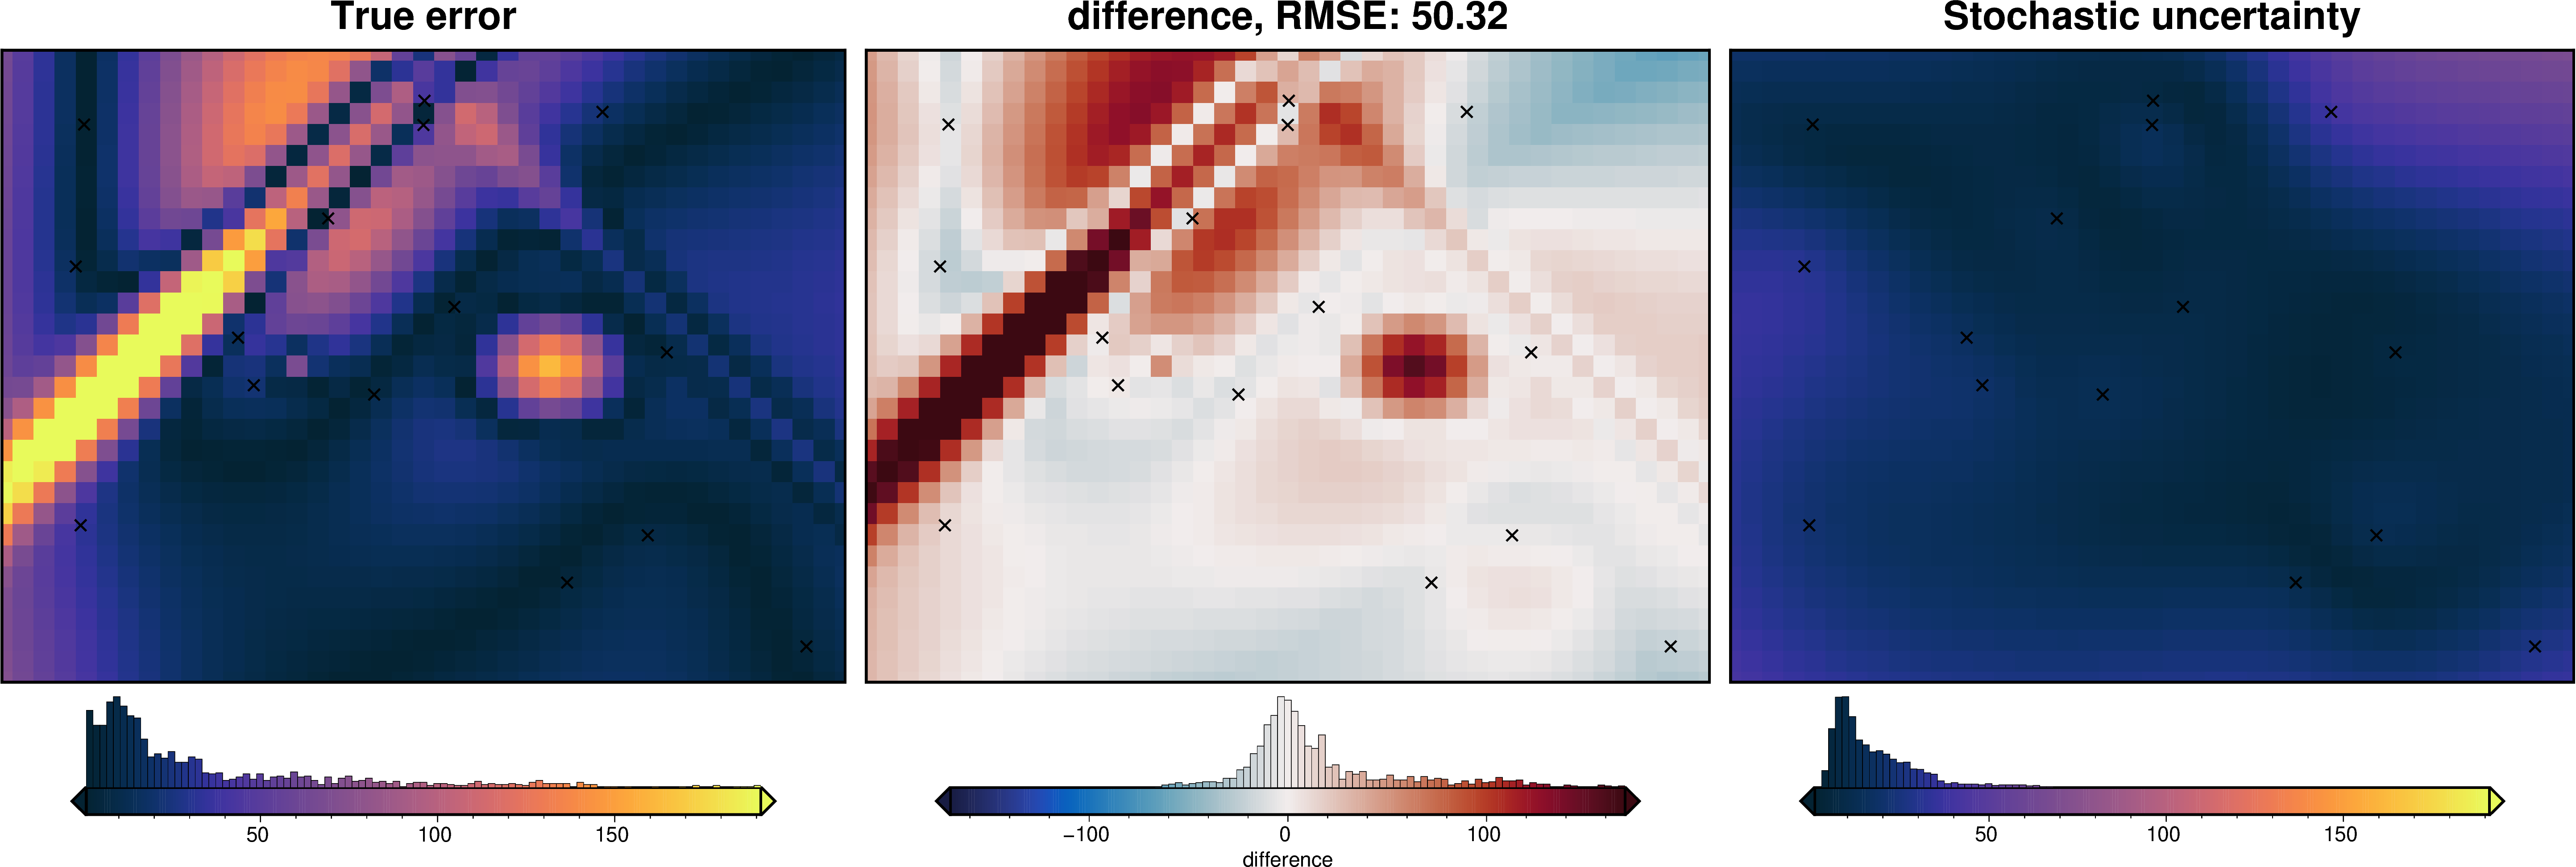

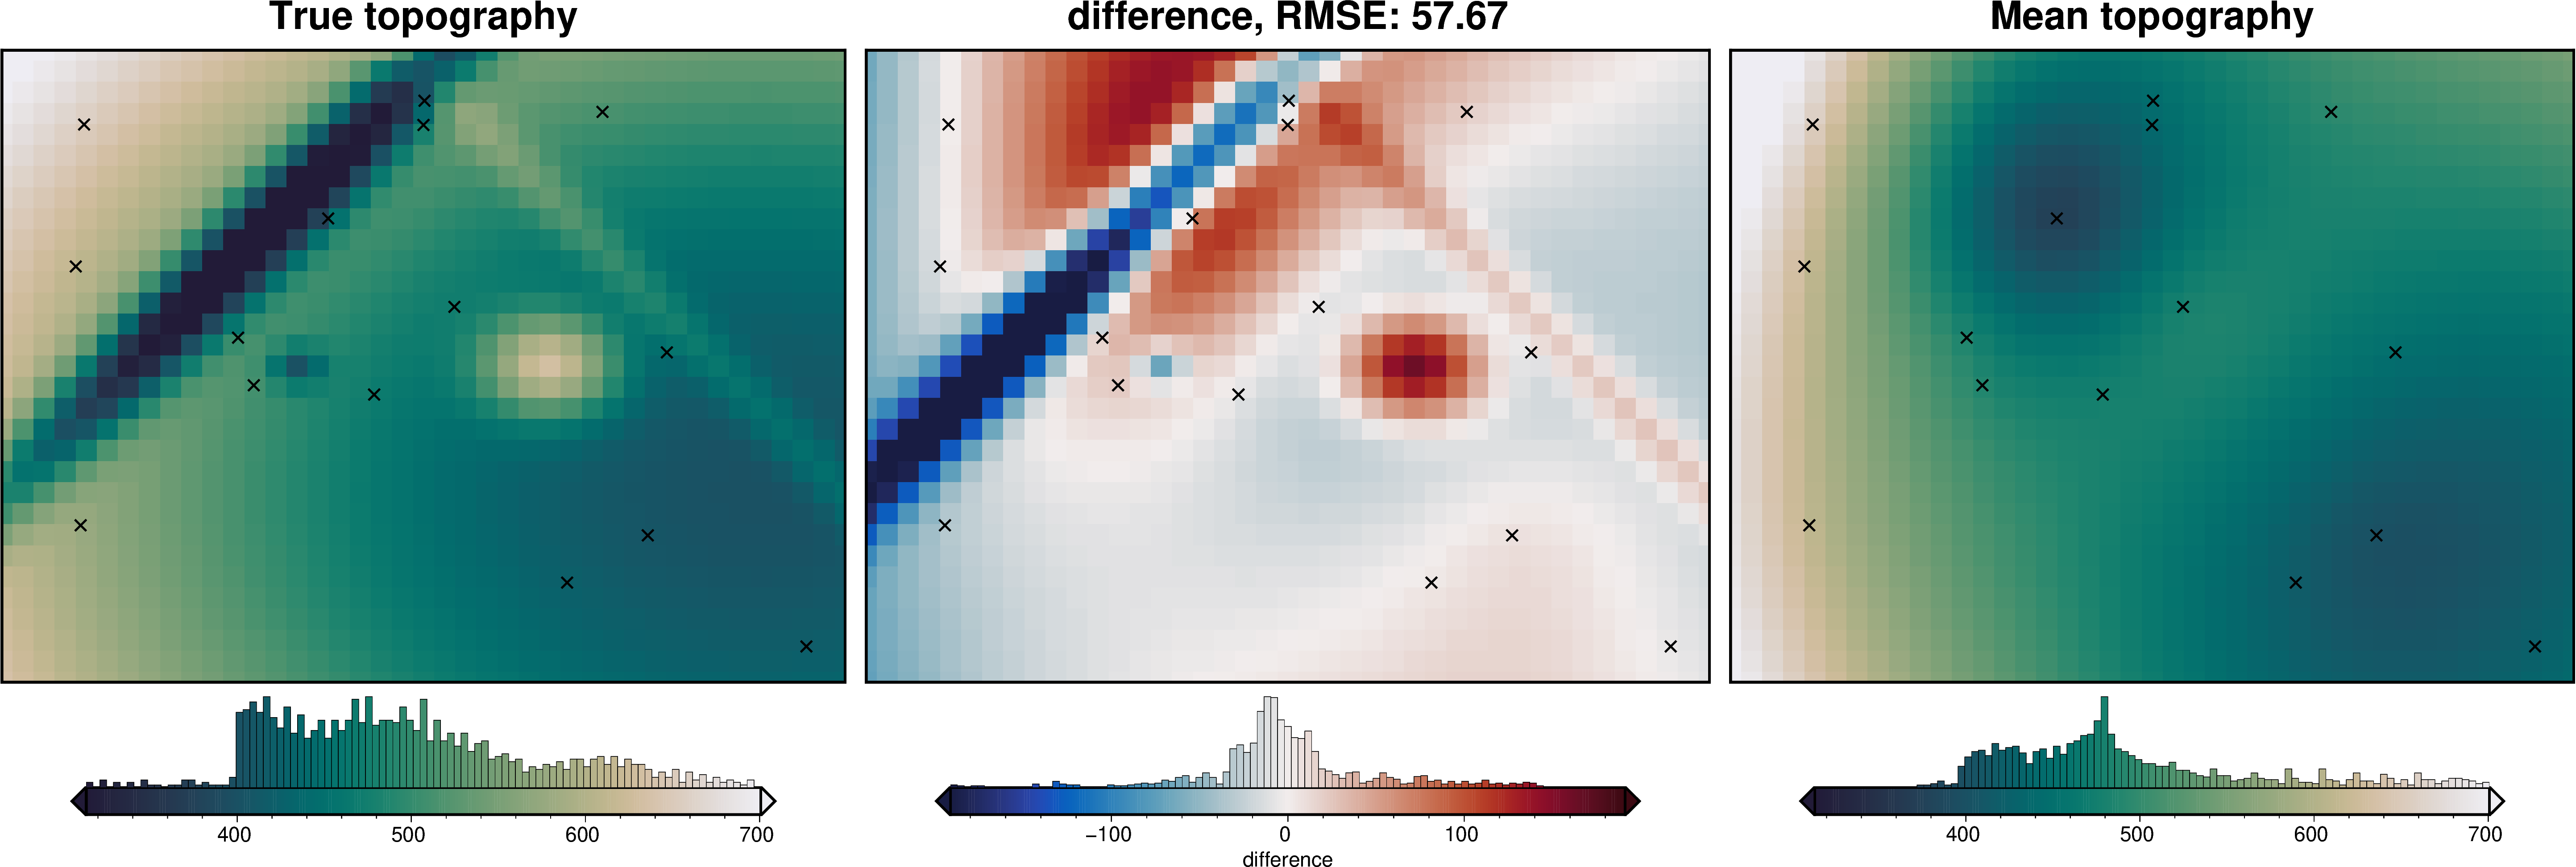

In [14]:
starting_topography_parameter_dict = {
    "dampings": {
        "distribution": "normal",
        "loc": np.log10(best_spline_damping),  # mean; base 10 exponent
        "scale": 0.5,  # standard deviation of exponent
        "log": True,
    },
}

starting_topo_stats = uncertainty.starting_topography_uncertainty(
    runs=40,
    sample_constraints=True,
    parameter_dict=starting_topography_parameter_dict,
    method="splines",
    dampings=best_spline_damping,
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    weights=constraint_points.weight,
    plot_region=region,
    true_topography=true_topography,
)

## Regional field estimation uncertainty

We will do the same thing for the regional estimation procedure. First we will re-separate the regional to see what equivalent source gridding parameter values were determined optimal. We then estimate an uncertainty distribution for these parameter values, and create an ensemble of regional models which each randomly sample both the parameter values and the gravity data. 

In [15]:
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 100,
  'damping_limits': (1e-20, 10),
  'depth_limits': (100, 100000.0),
  'progressbar': False,
  'fname': 'tmp/regional_sep'},
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   655.102400  656.749723  13.102048  0.005825   
 1   30636.914105   6974.789900   407.011208  405.935844   8.140224  0.015091   
 2   17659.550795  13659.470931   470.155613  476.177579   9.403112  0.011310   
 3   28491.676758  27073.768551   515.239653  516.320627  10.304793  0.009417   
 4   38163.601456   1697.178371   419.197817  414.706788   8.383956  0.014227   
 5   21462.843076  17815.369689   472.257595  475.672915   9.445152  0.011209   
 6   20042.577619  27603.626012   417.272882  428.155359   8.345458  0.014358   
 7    3737.943068   7448.480613   578.101458  5

In [16]:
# use the constraints to find the best regional field
_ = regional.regional_separation(grav_df=grav_df, **regional_grav_kwargs)

# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get("cv_kwargs").get("fname")}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
eq_damping

INFO:invert4geom:Current trial (#10, {'depth': 72203.35621143678, 'damping': 1.347092541549628e-14}) has a worse score (-94.13946326789824) than any of the combinations of parameter value limits, it might be best to stop the study and expand the limits.
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 43
INFO:invert4geom:	parameter: {'depth': 15041.577139067731, 'damping': 0.005076537418909756}
INFO:invert4geom:	scores: [-0.20668195127905858]


0.005076537418909756

In [17]:
# if depth="default" in EquivalentSources, it will use 4.5 times the mean distances
# between nearest points as the depth
# calculate that mean distance below.
mean_constraint_distance = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing), k_nearest=1
    )
)
mean_constraint_distance

np.float64(5599.156508868462)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 22396.626035473848, min: 6019.0932470335965, max: 38774.1588239141
INFO:invert4geom:Sampled 'damping' parameter values; mean: 4.622964070499353, min: 1.6701756069372796e-07, max: 154.30252997677107


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

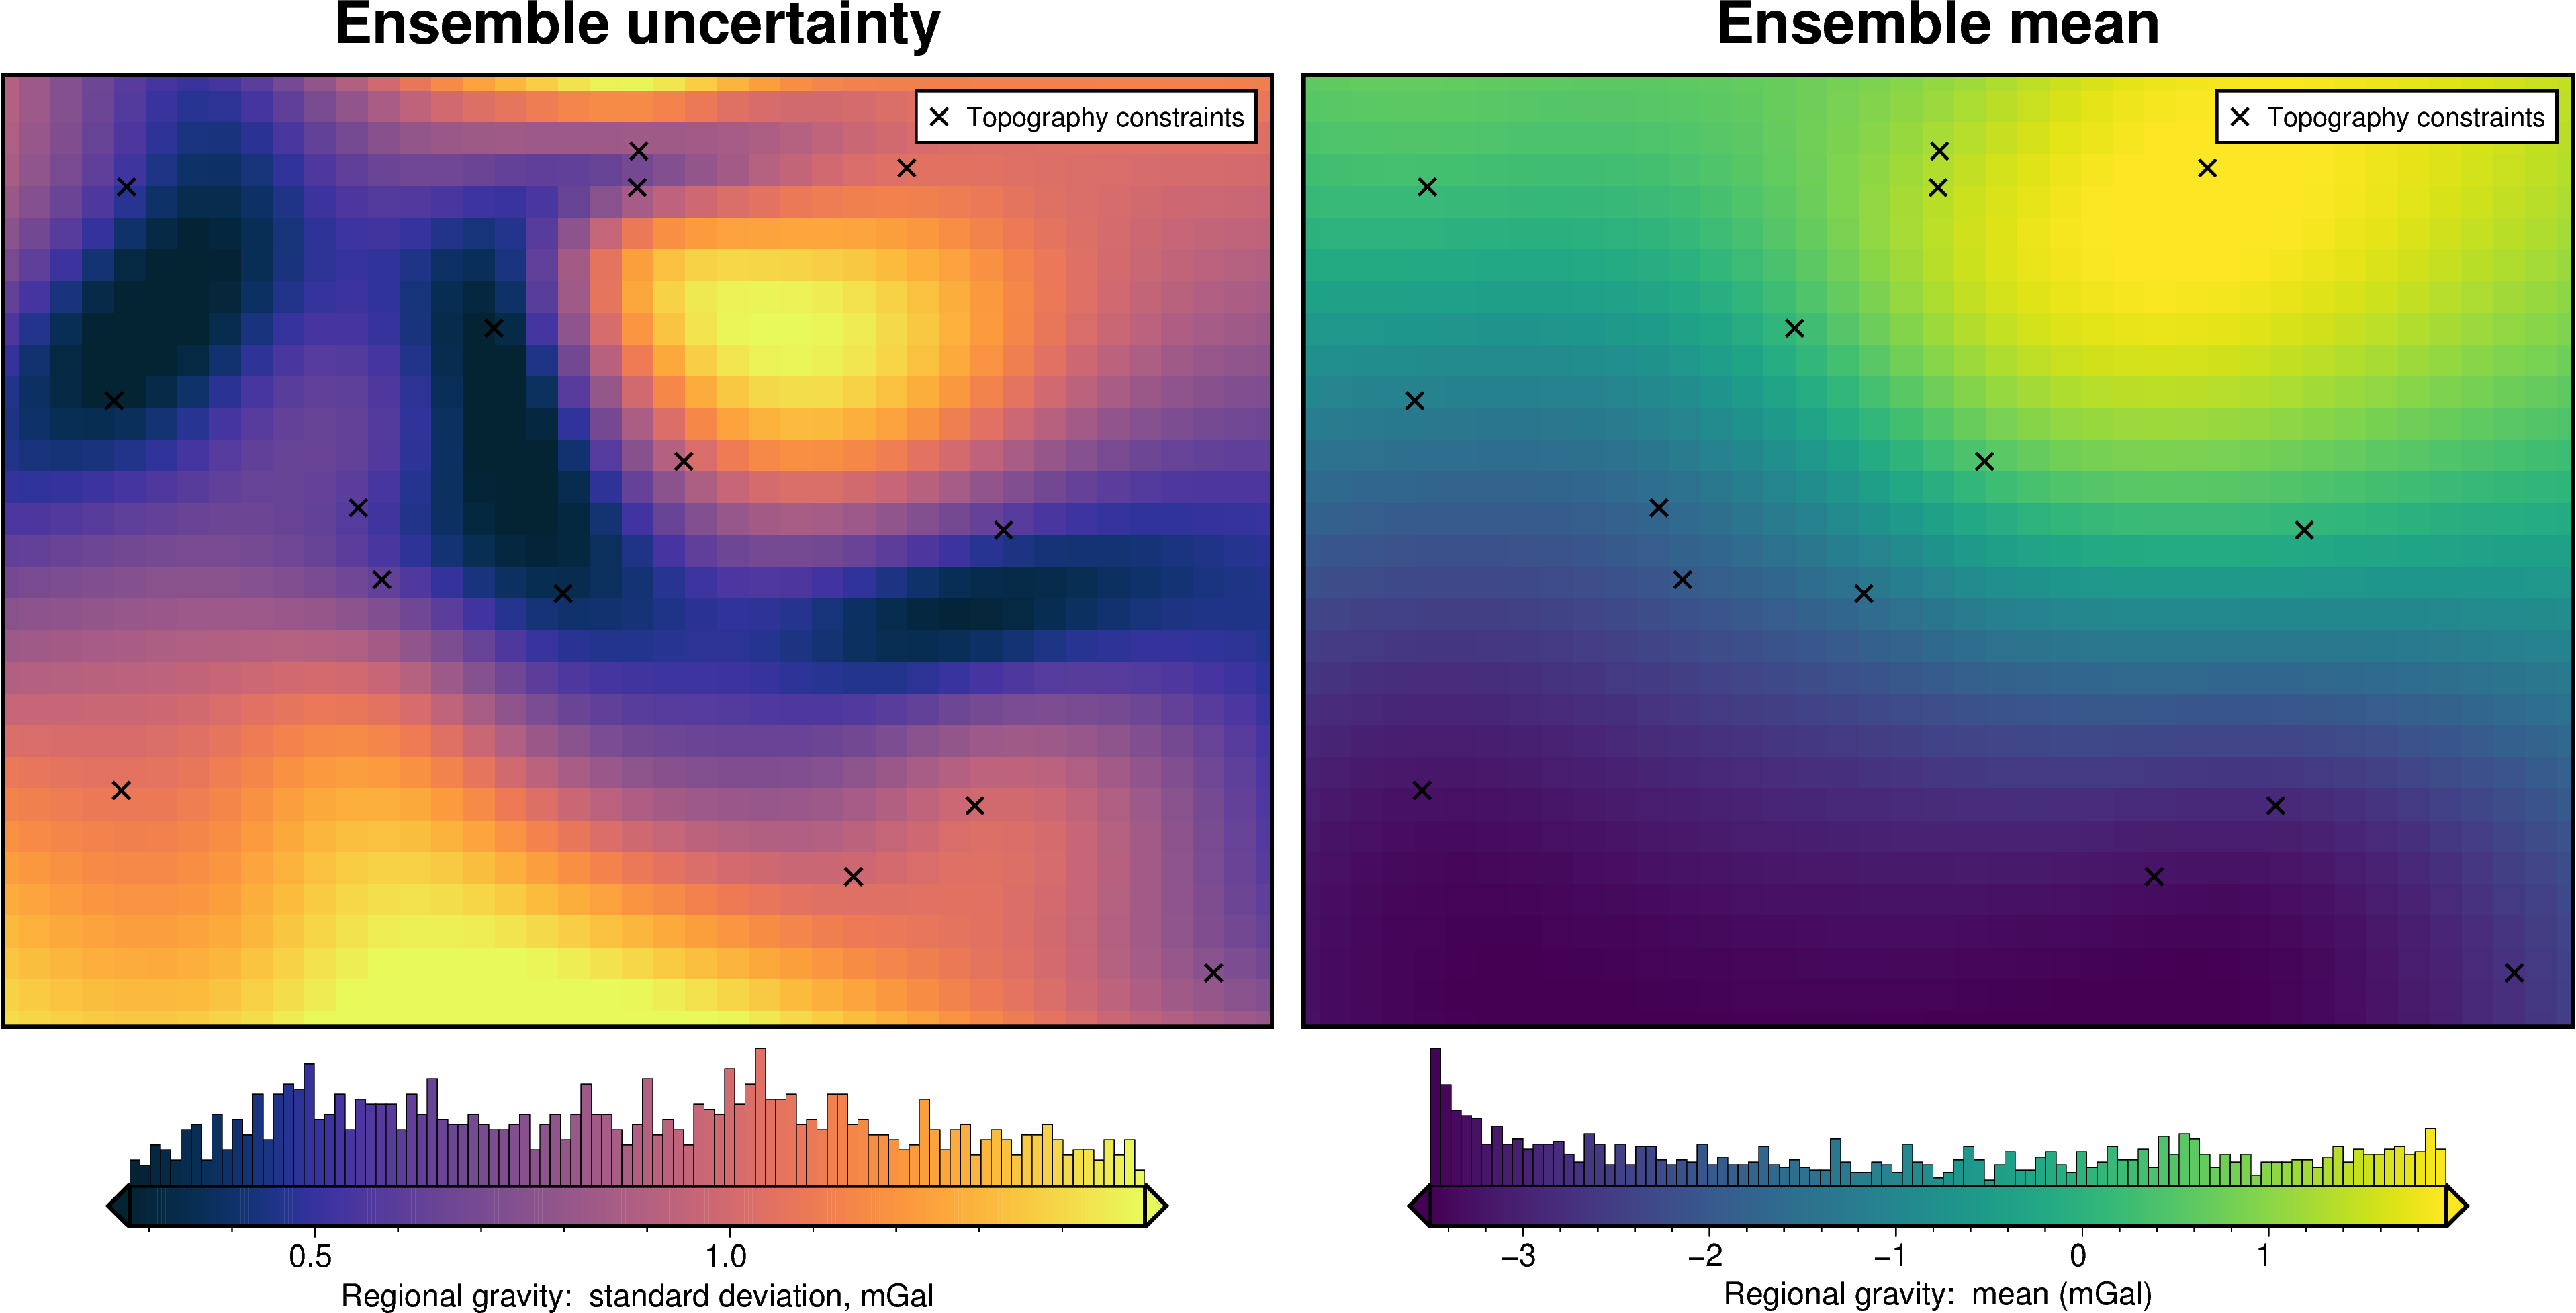

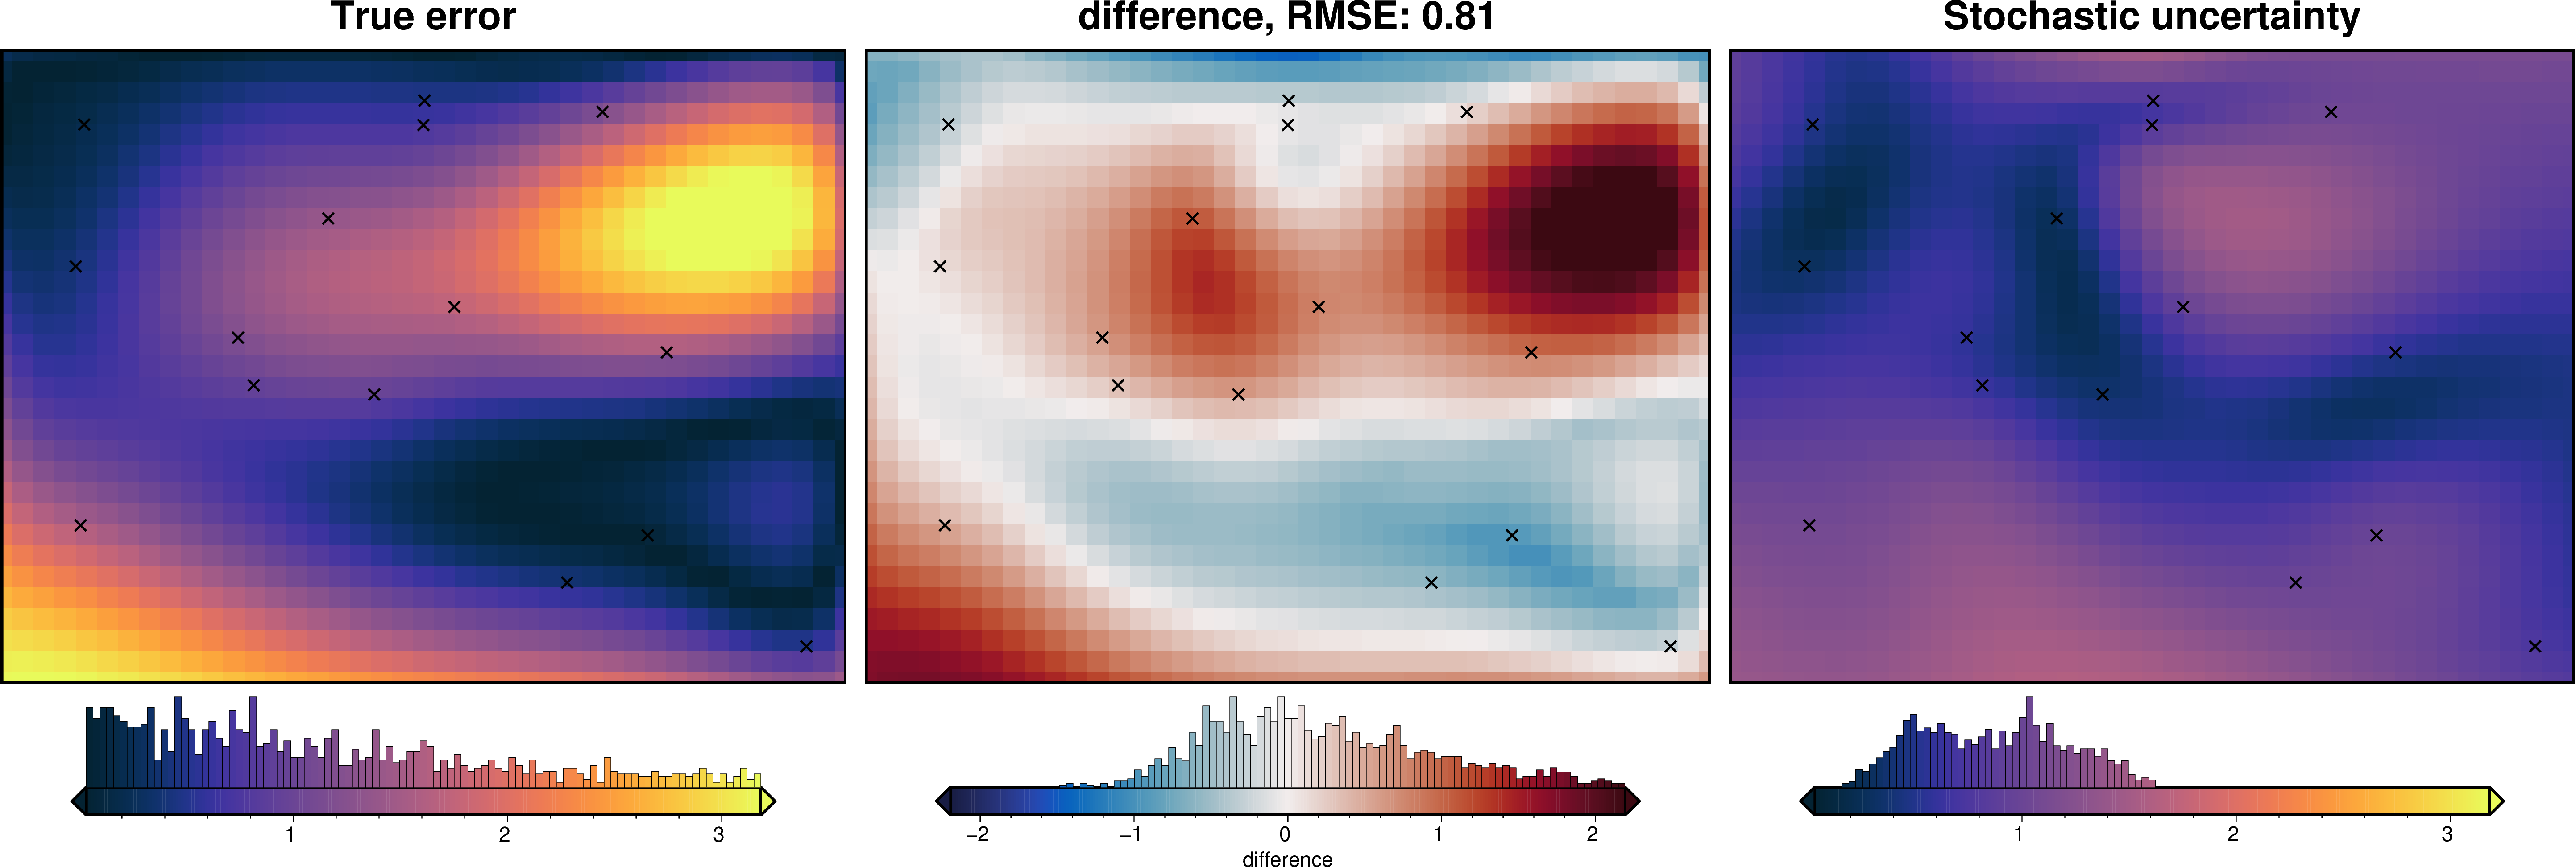

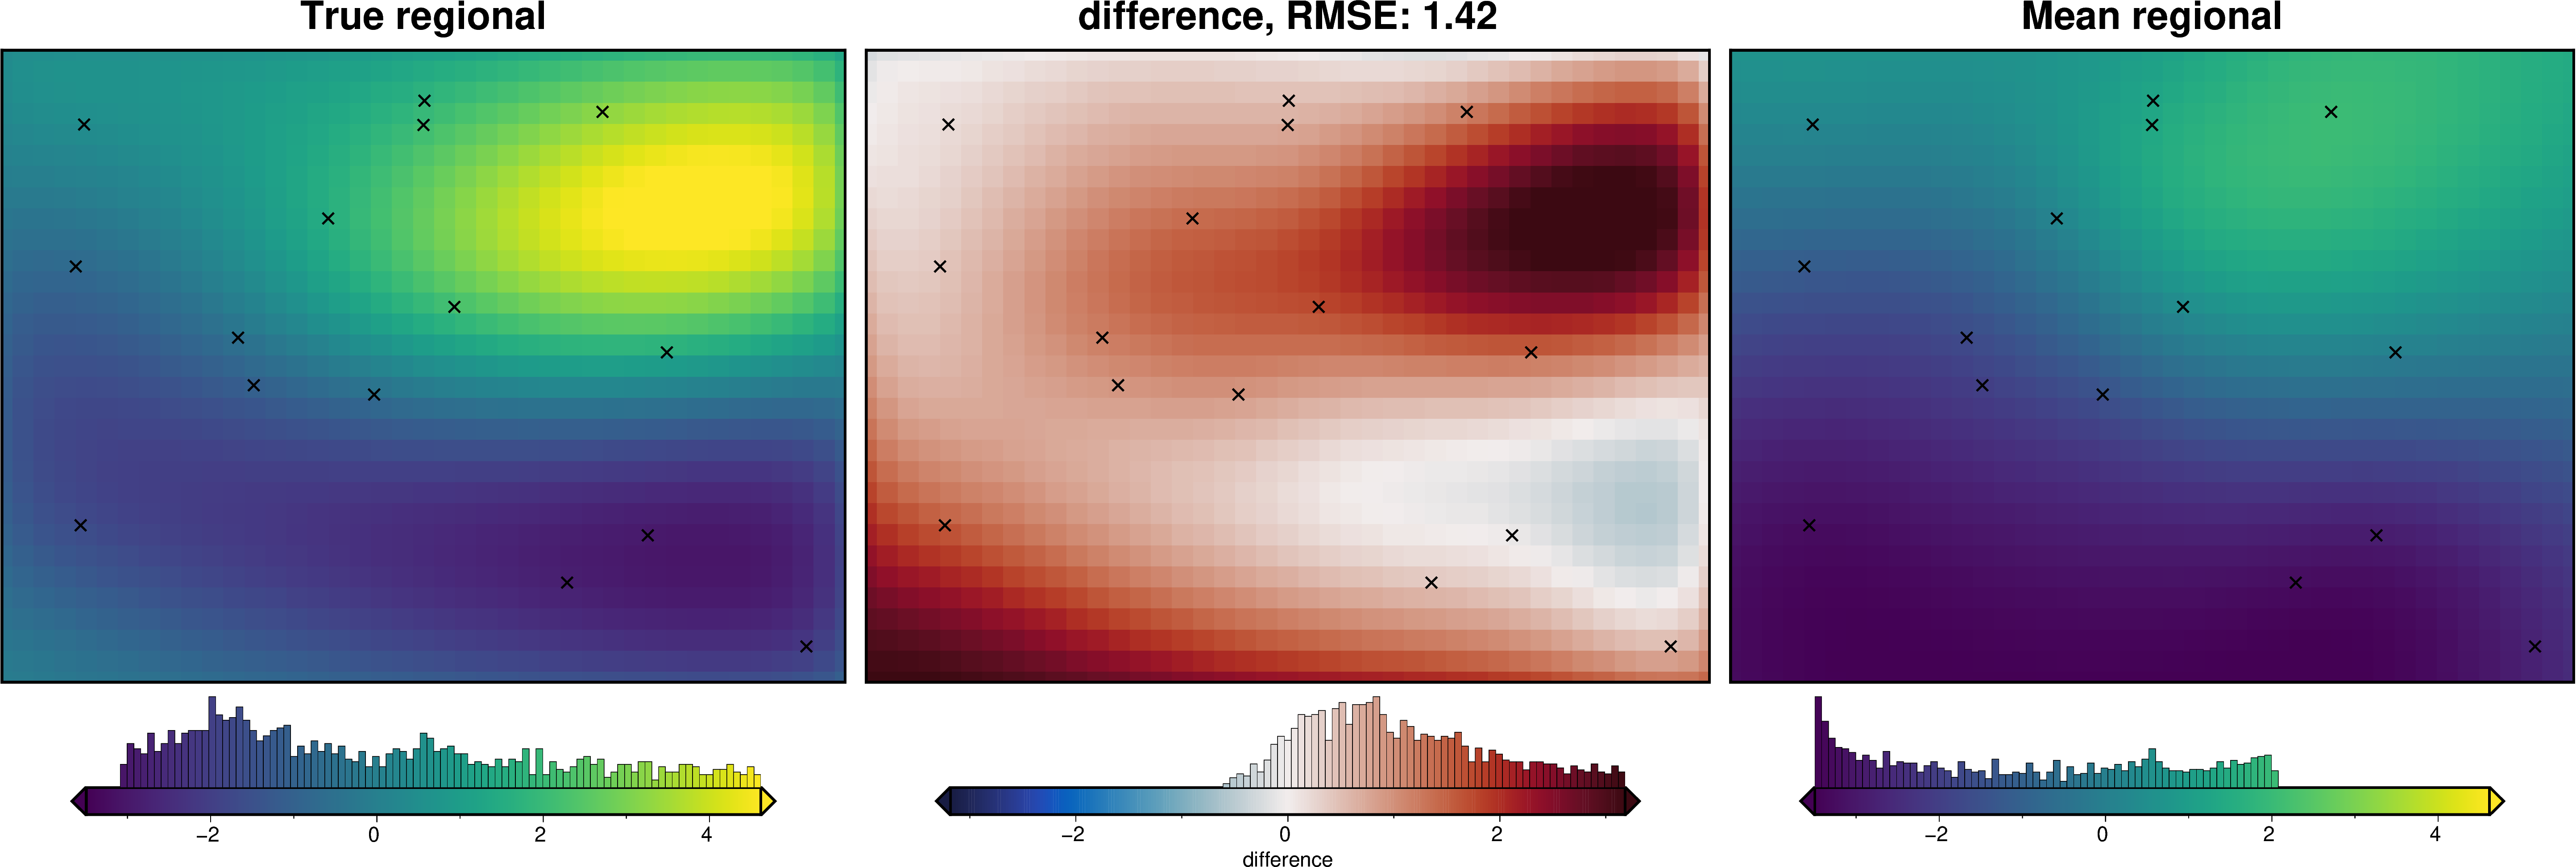

In [18]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "uniform",
        "loc": 1 * mean_constraint_distance,  # lower bound
        "scale": 6 * mean_constraint_distance,  # range, 2.5+3.5=6
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(eq_damping),  # mean base 10 exponent
        "scale": 2,  # standard deviation of exponent
        "log": True,
    },
}

# cant use a cross validation to find damping and depth or there will be no variation
regional_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    method="constraints",
    grid_method="eq_sources",
    # damping=eq_damping,
    # depth="default",
    block_size=None,
)

regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    parameter_dict=regional_misfit_parameter_dict,
    plot_region=region,
    true_regional=grav_grid.lower_surface_grav,
    **regional_kwargs,
)

## Sensitivity Analysis

Above we perform an uncertainty assessment using all the important parameters and data. Now, we can repeat this stochastic analysis isolated the uncertainty arising from each component. This should give us a sense of which parameters/data are the most important.

In [19]:
# plotting functions for uncertainty results
def uncert_plots(results):
    ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=region,
    )
    ds = ds.sel(
        {
            "easting": slice(*region[:2]),
            "northing": slice(*region[2:]),
        }
    )
    _ = polar_utils.grd_compare(
        true_topography,
        ds.weighted_mean,
        plot=True,
        region=region,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(true_topography - ds.weighted_mean),
        ds.weighted_stdev,
        plot=True,
        region=region,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

In [20]:
# parameters used in final inversion
density_contrast, zref, solver_damping, best_spline_damping

(2641.92282038,
 484.56202153982827,
 0.023193756214638702,
 np.float64(3.430469286314926e-07))

In [21]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    density_contrast=density_contrast,
    zref=zref,
    solver_damping=solver_damping,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    # kwargs
    starting_topography_kwargs={
        "method": "splines",
        "region": region,
        "spacing": spacing,
        "constraints_df": constraint_points,
        "dampings": best_spline_damping,
        "weights": constraint_points.weight,
    },
    # use cross validation for equivalent sources during regional estimation
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

#### Density contrast component

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2641.9228203799994, min: 2347.9282226989917, max: 2935.9174180610084
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_density'



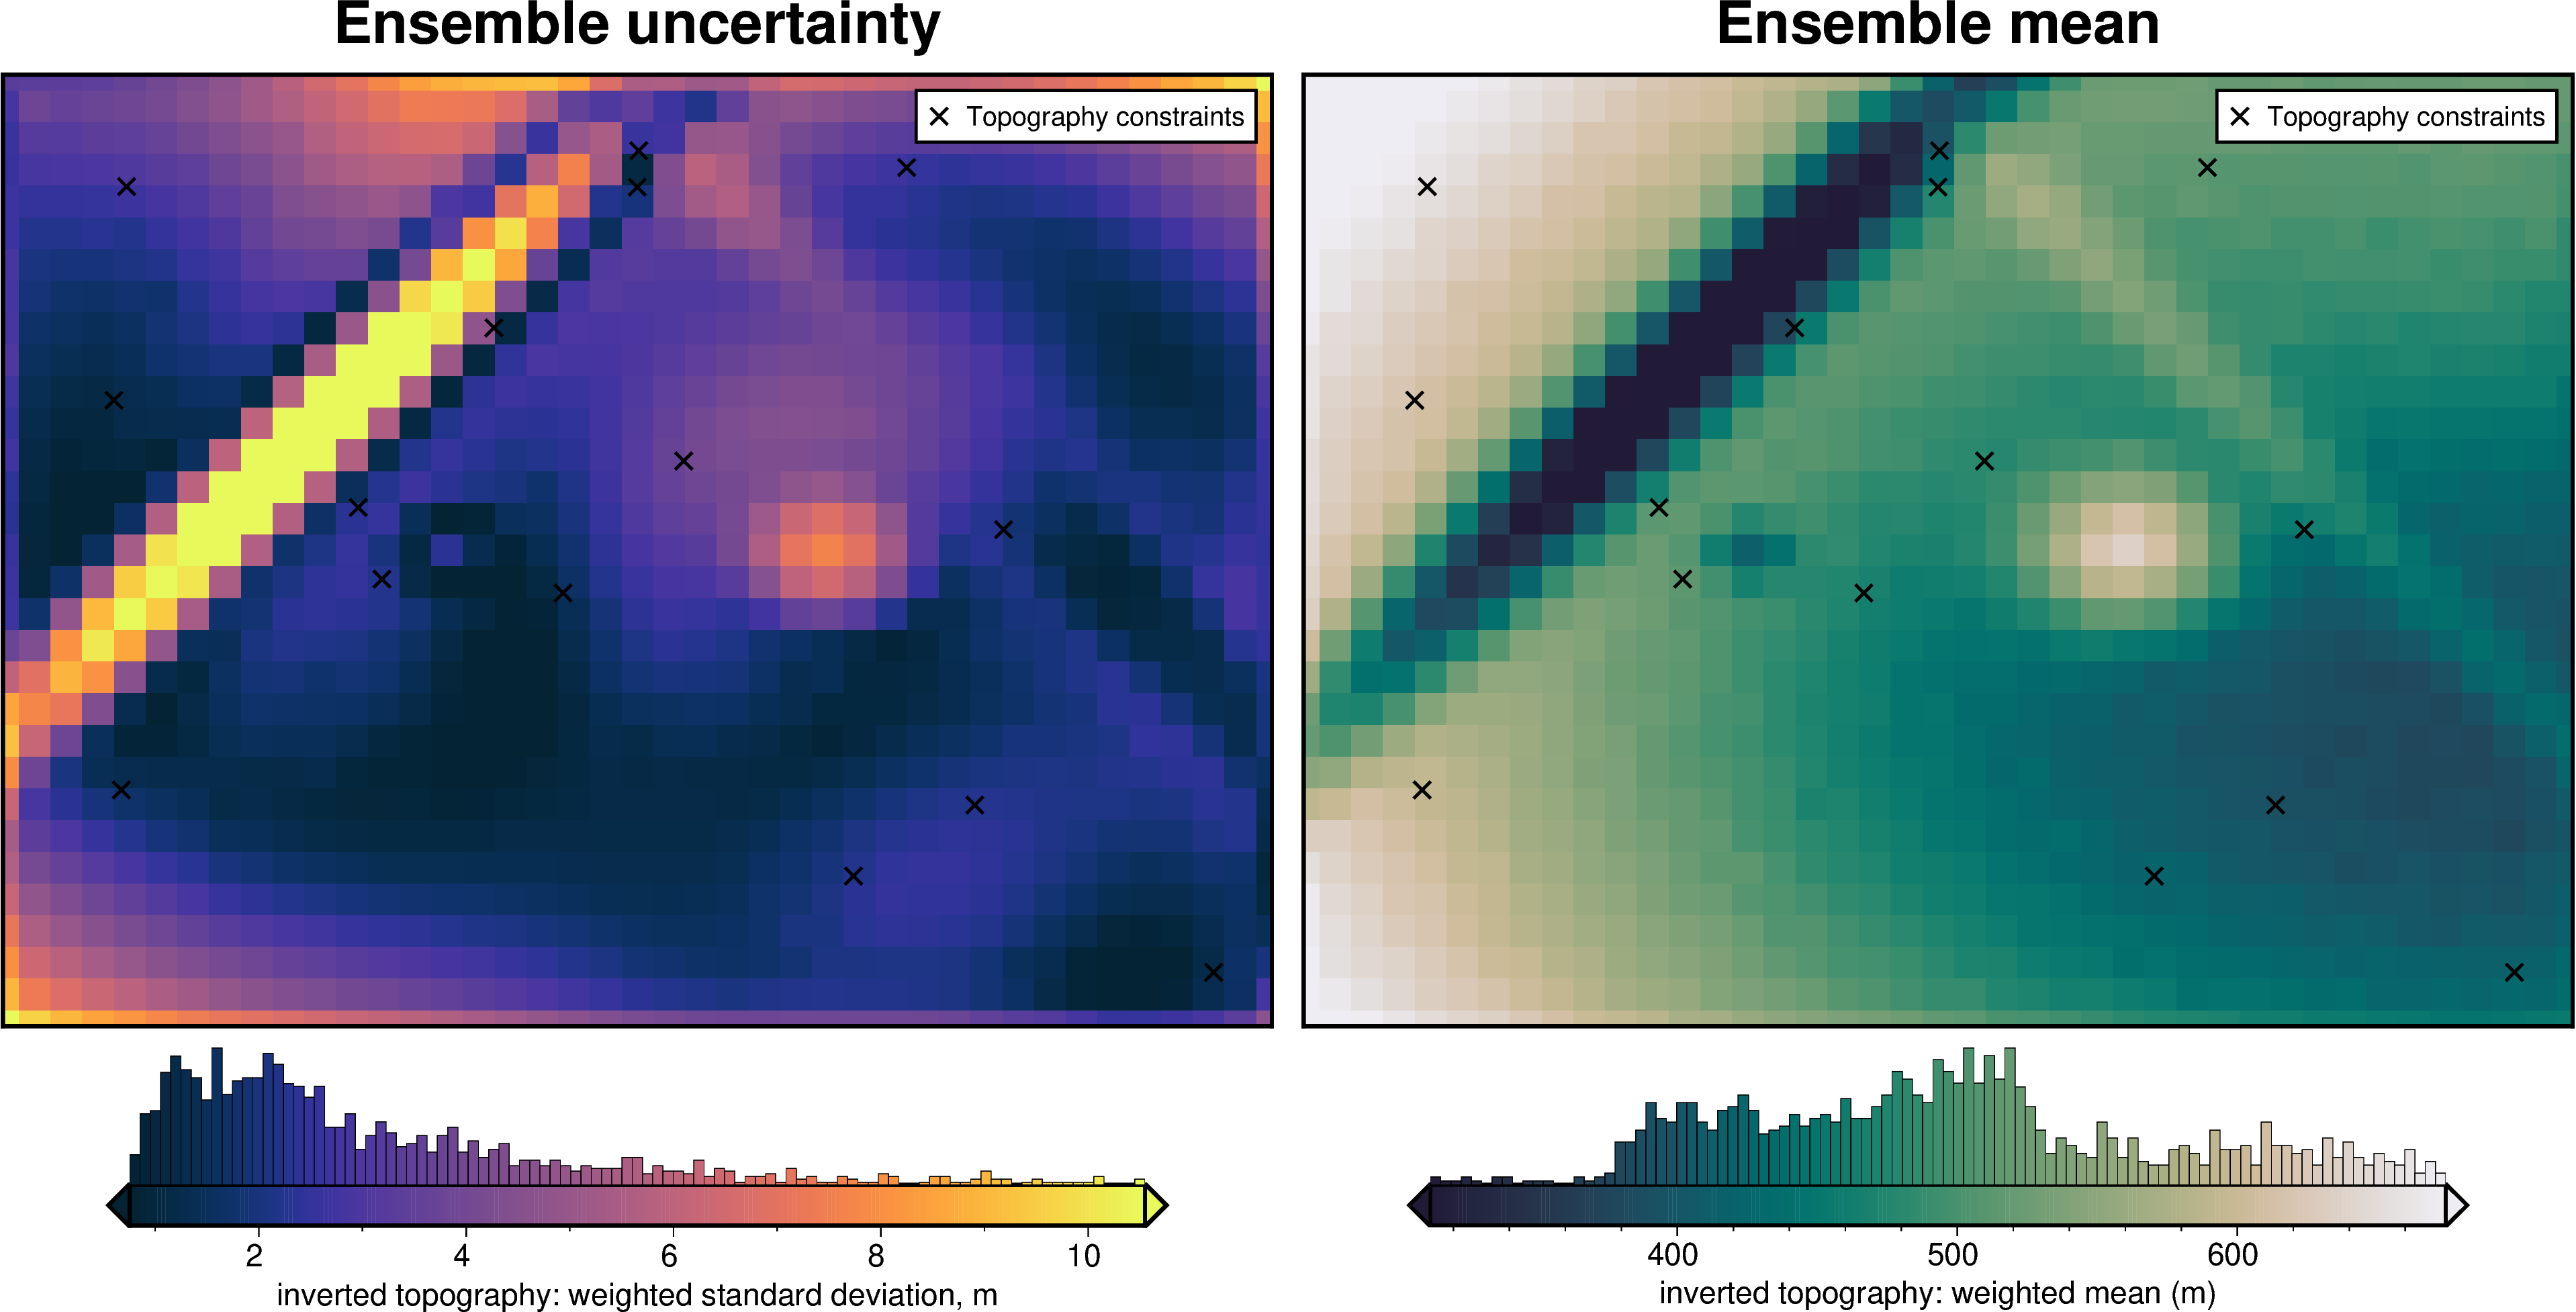

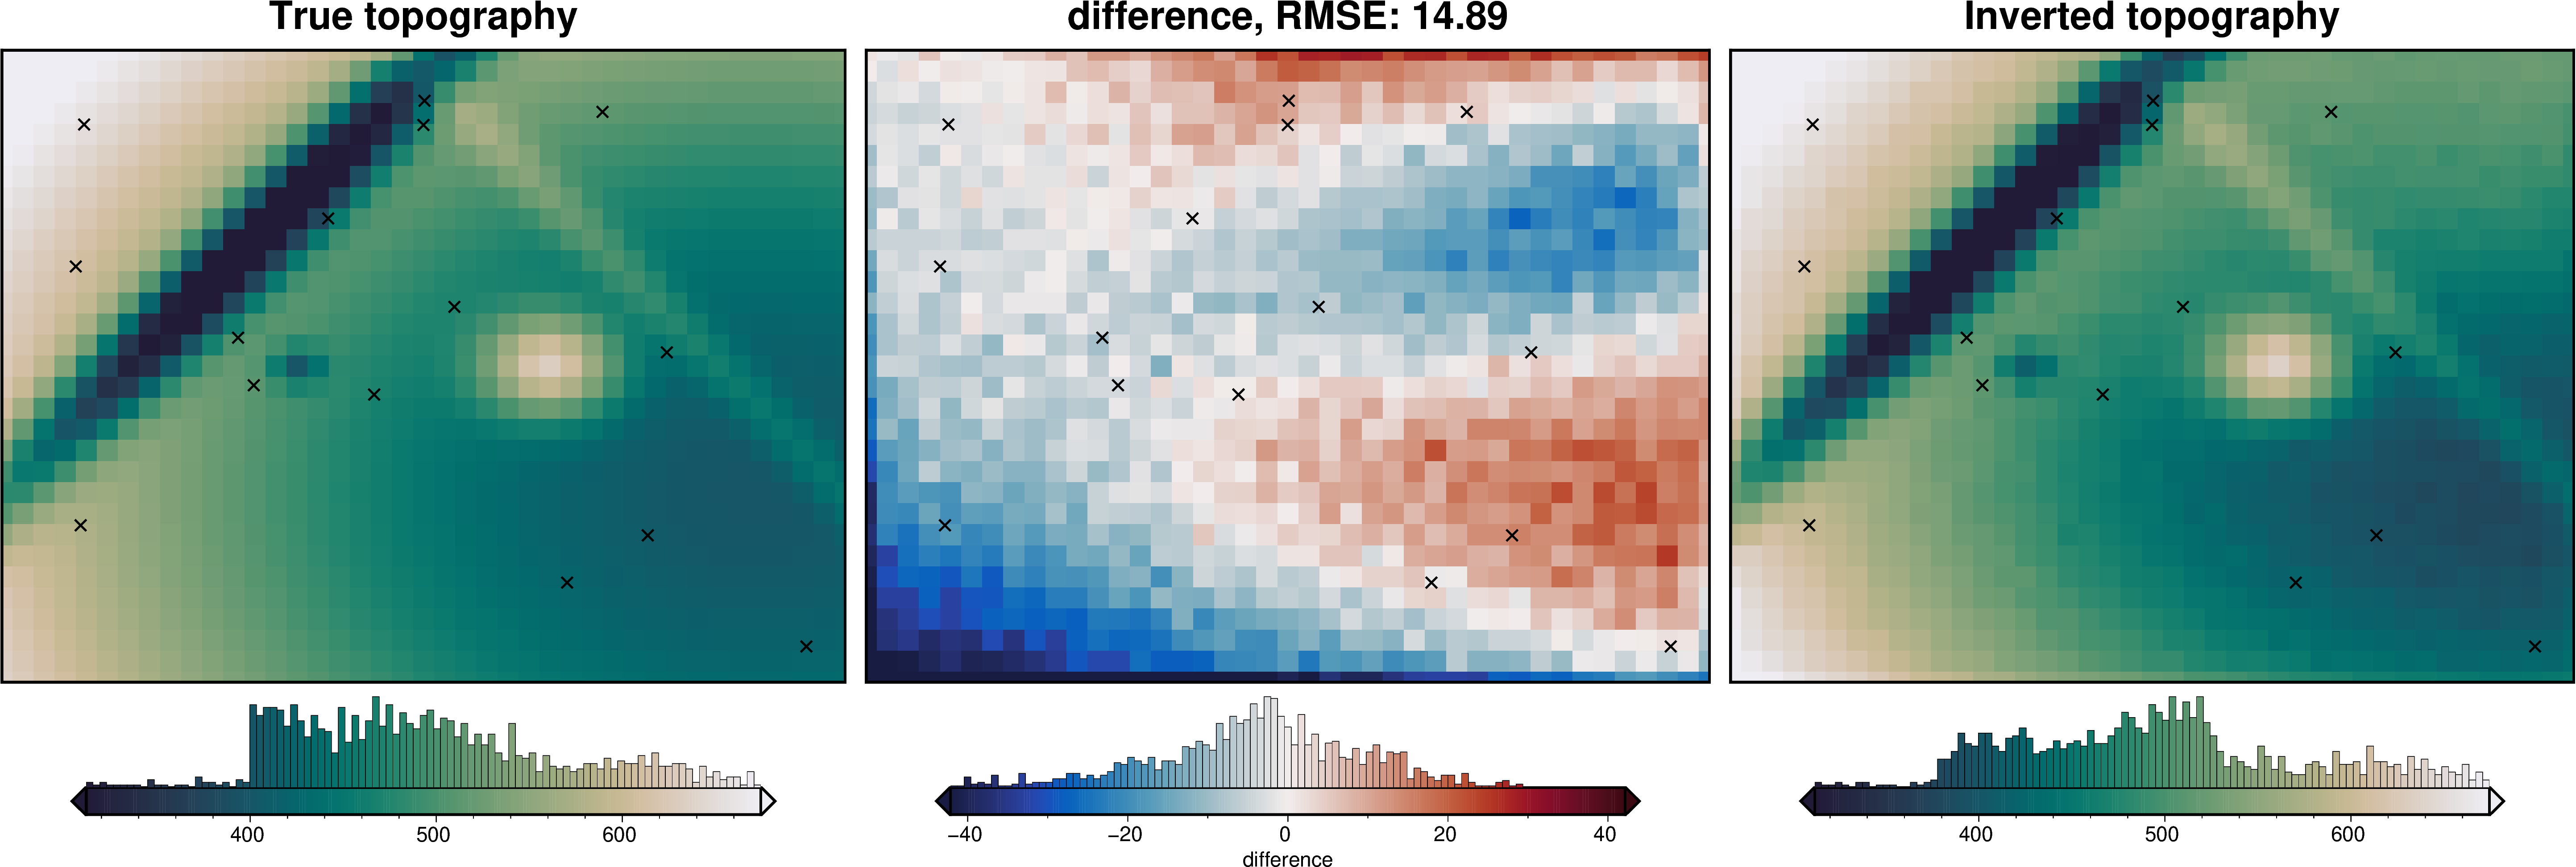

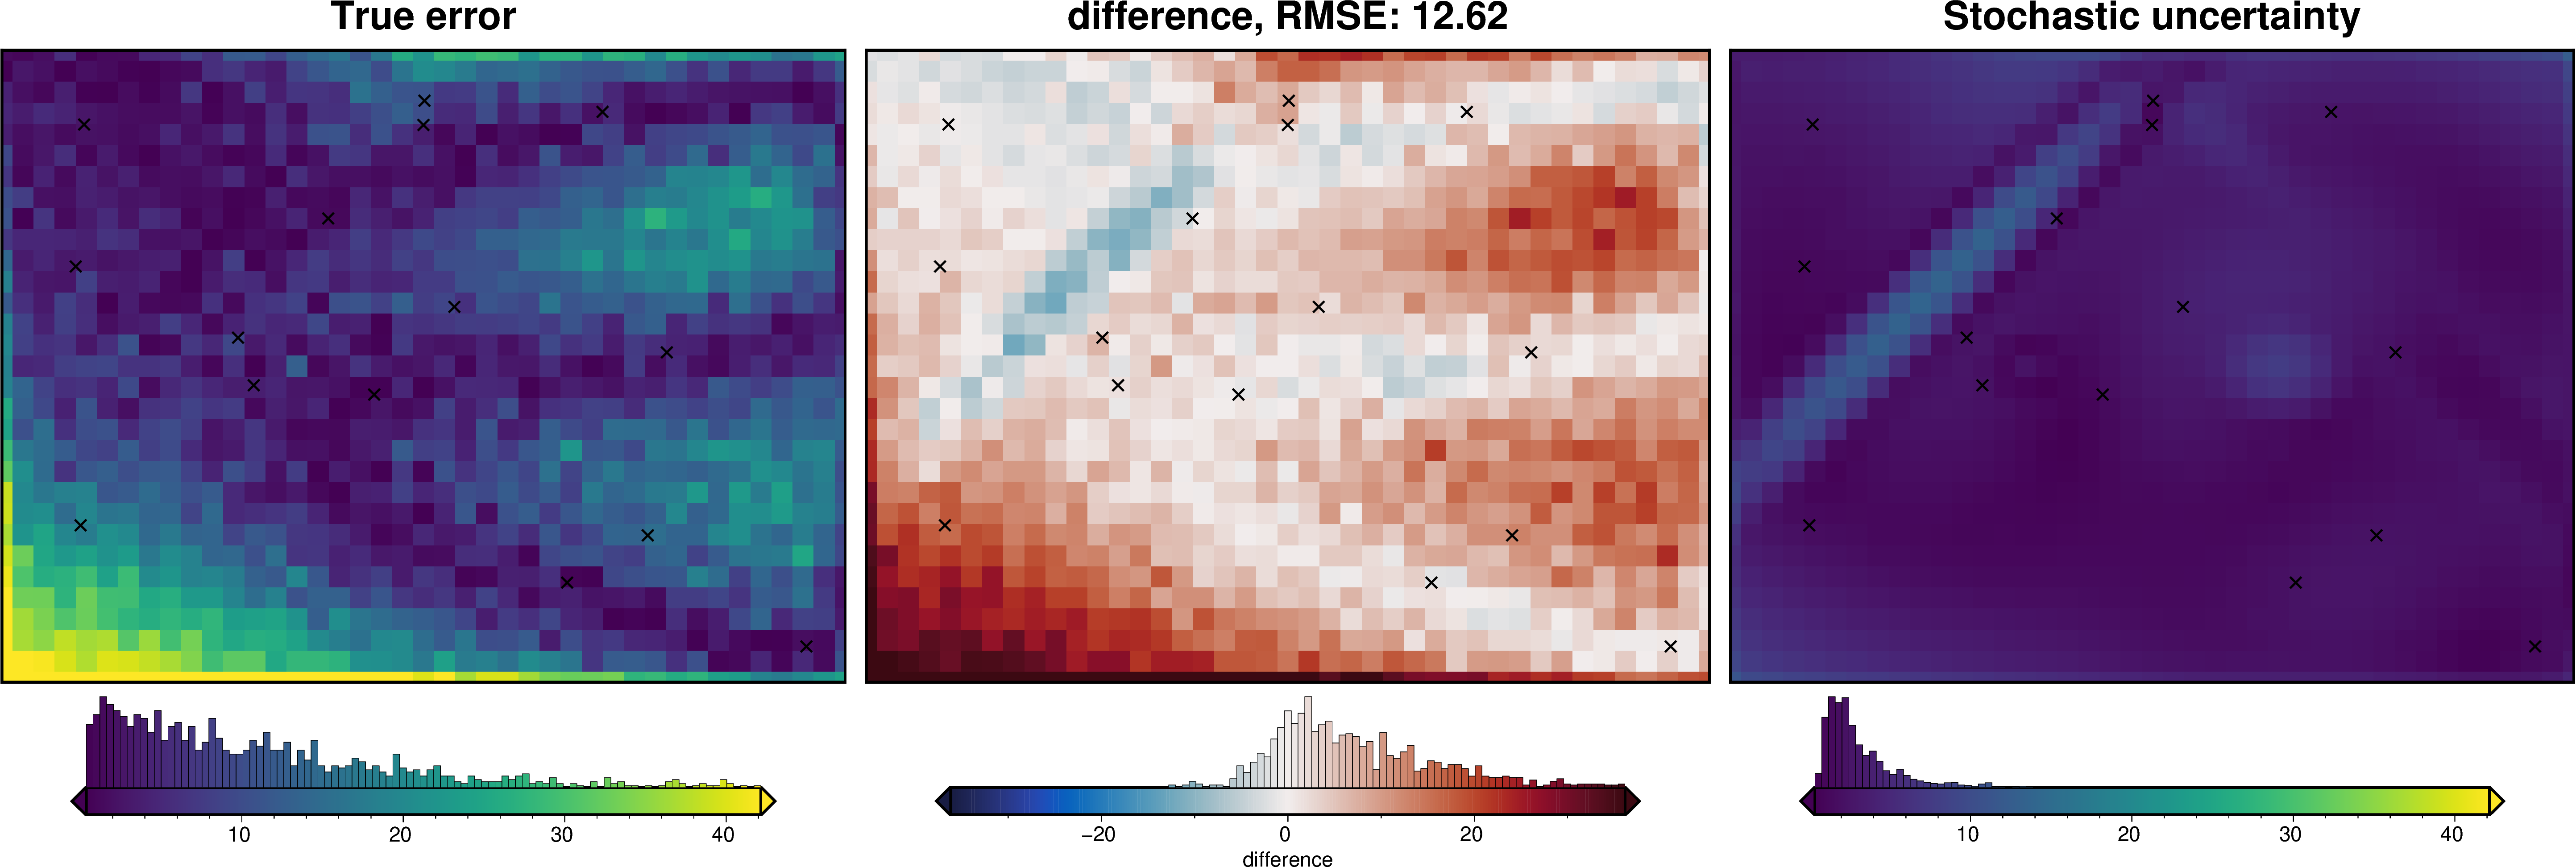

In [22]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": density_contrast,
        "scale": 150,
    },
}

fname = "tmp/uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=density_dict,
    # choose what to do
    # create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_density_results)

#### Solver damping component

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.025600141316290063, min: 0.00940542210866402, max: 0.057195766561986244
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_damping'



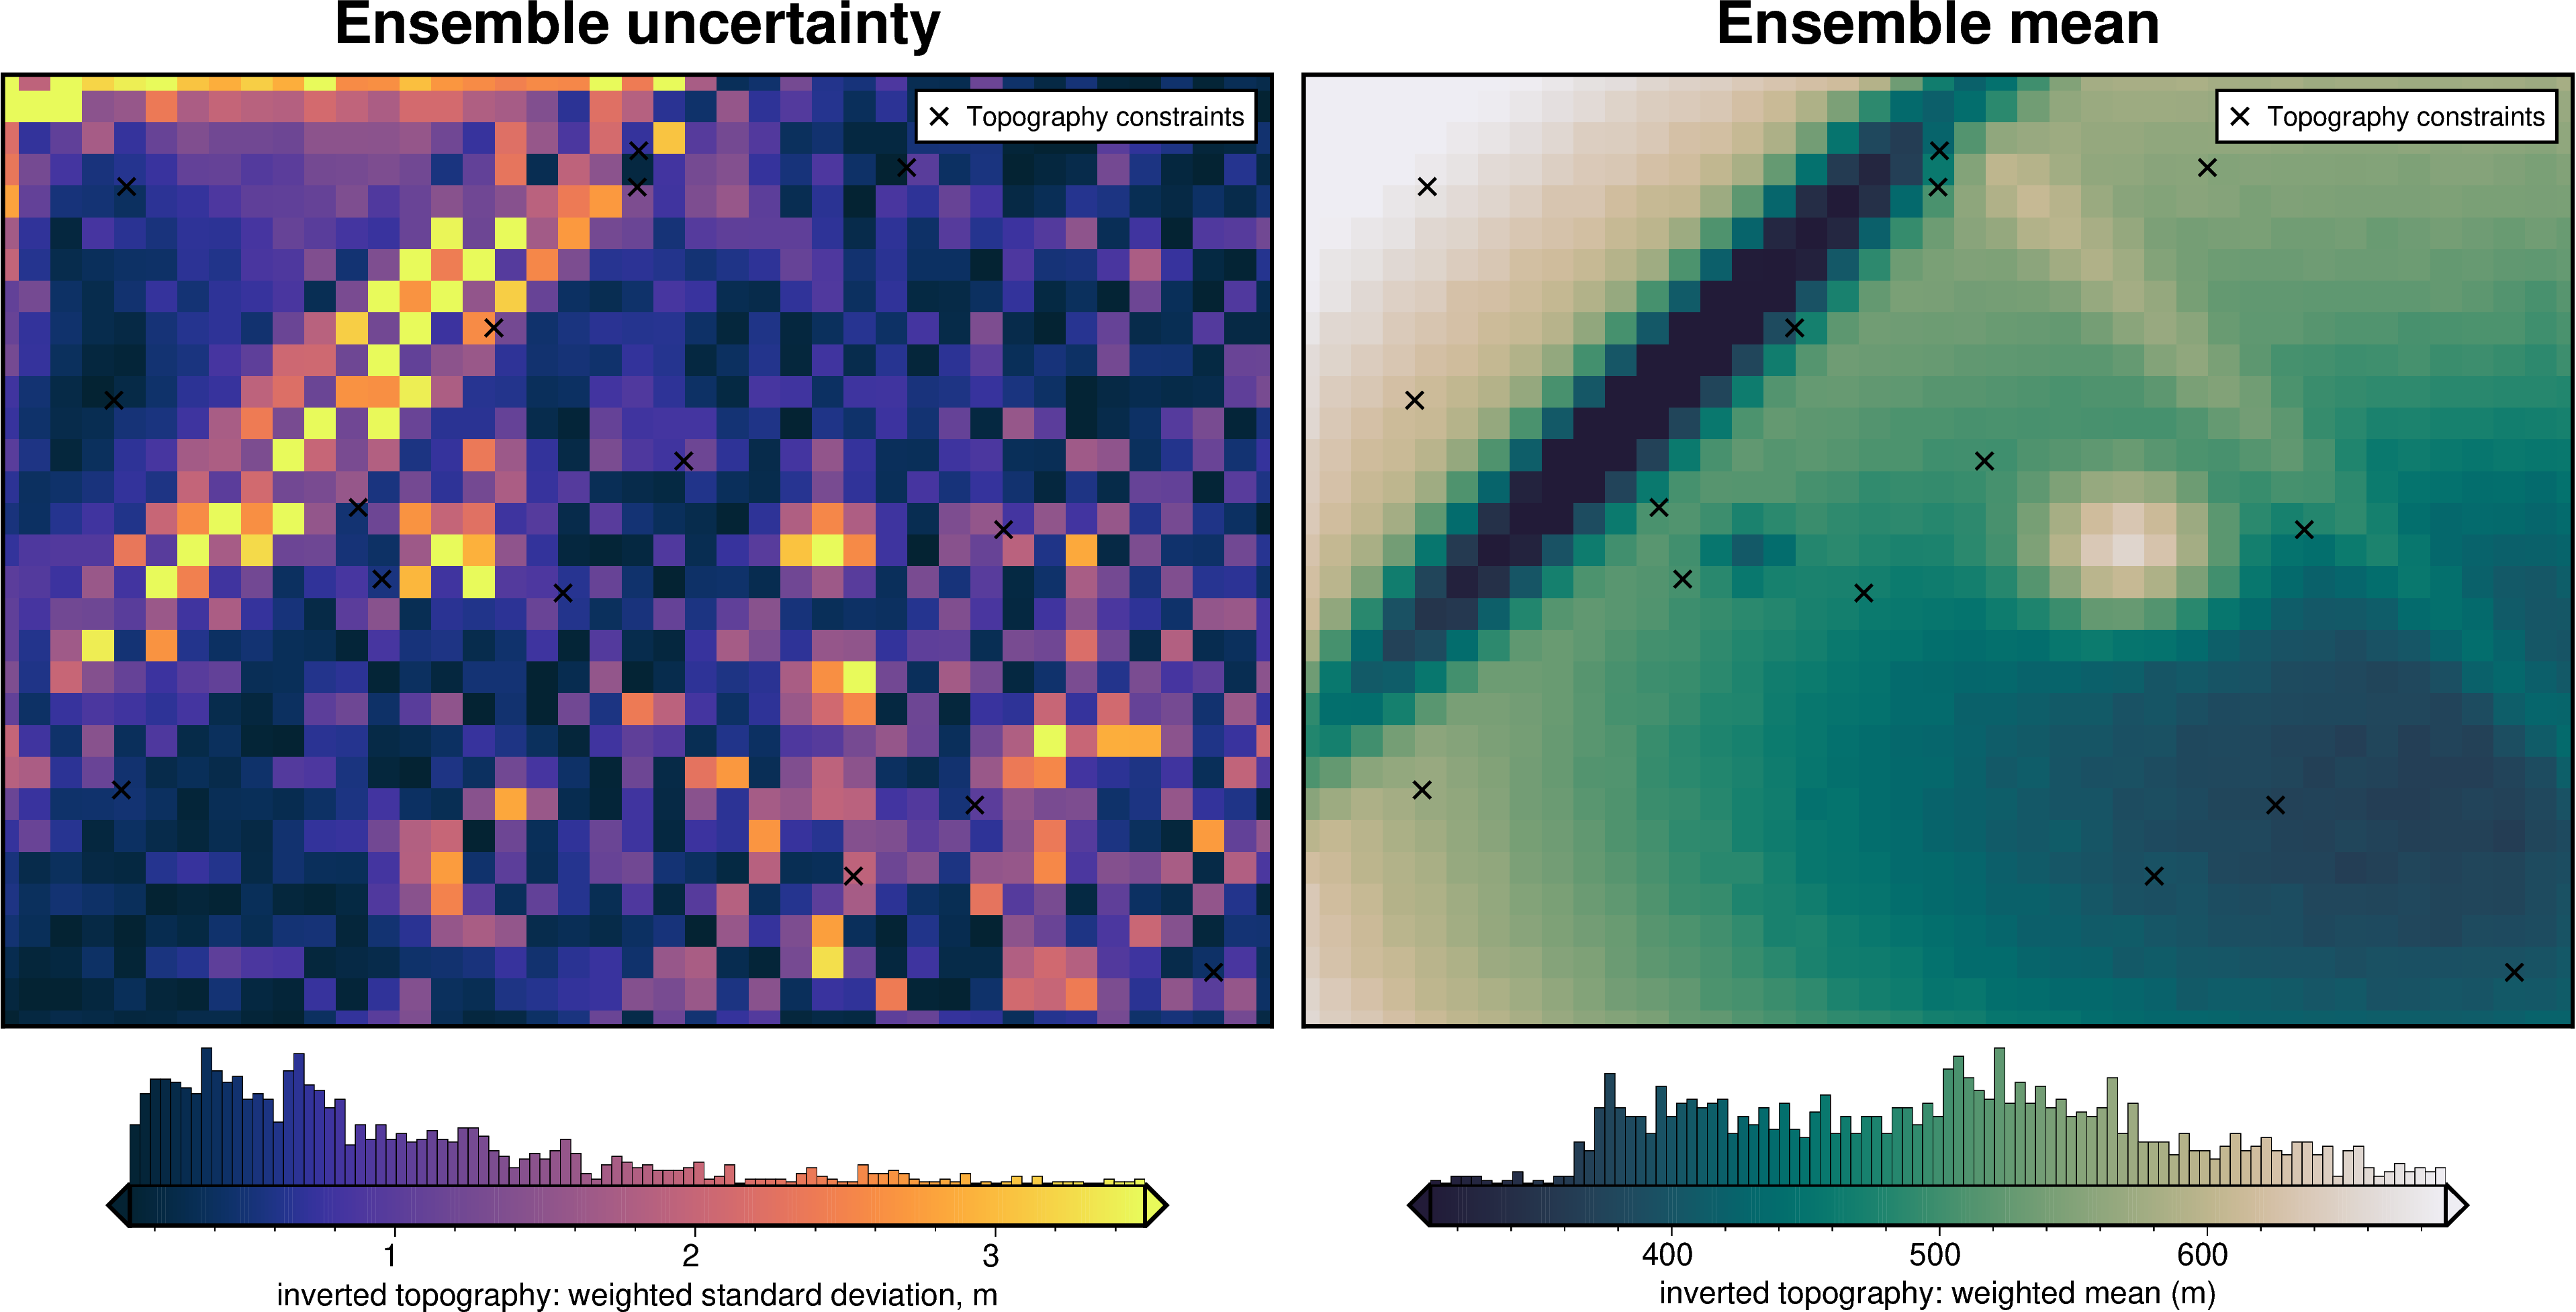

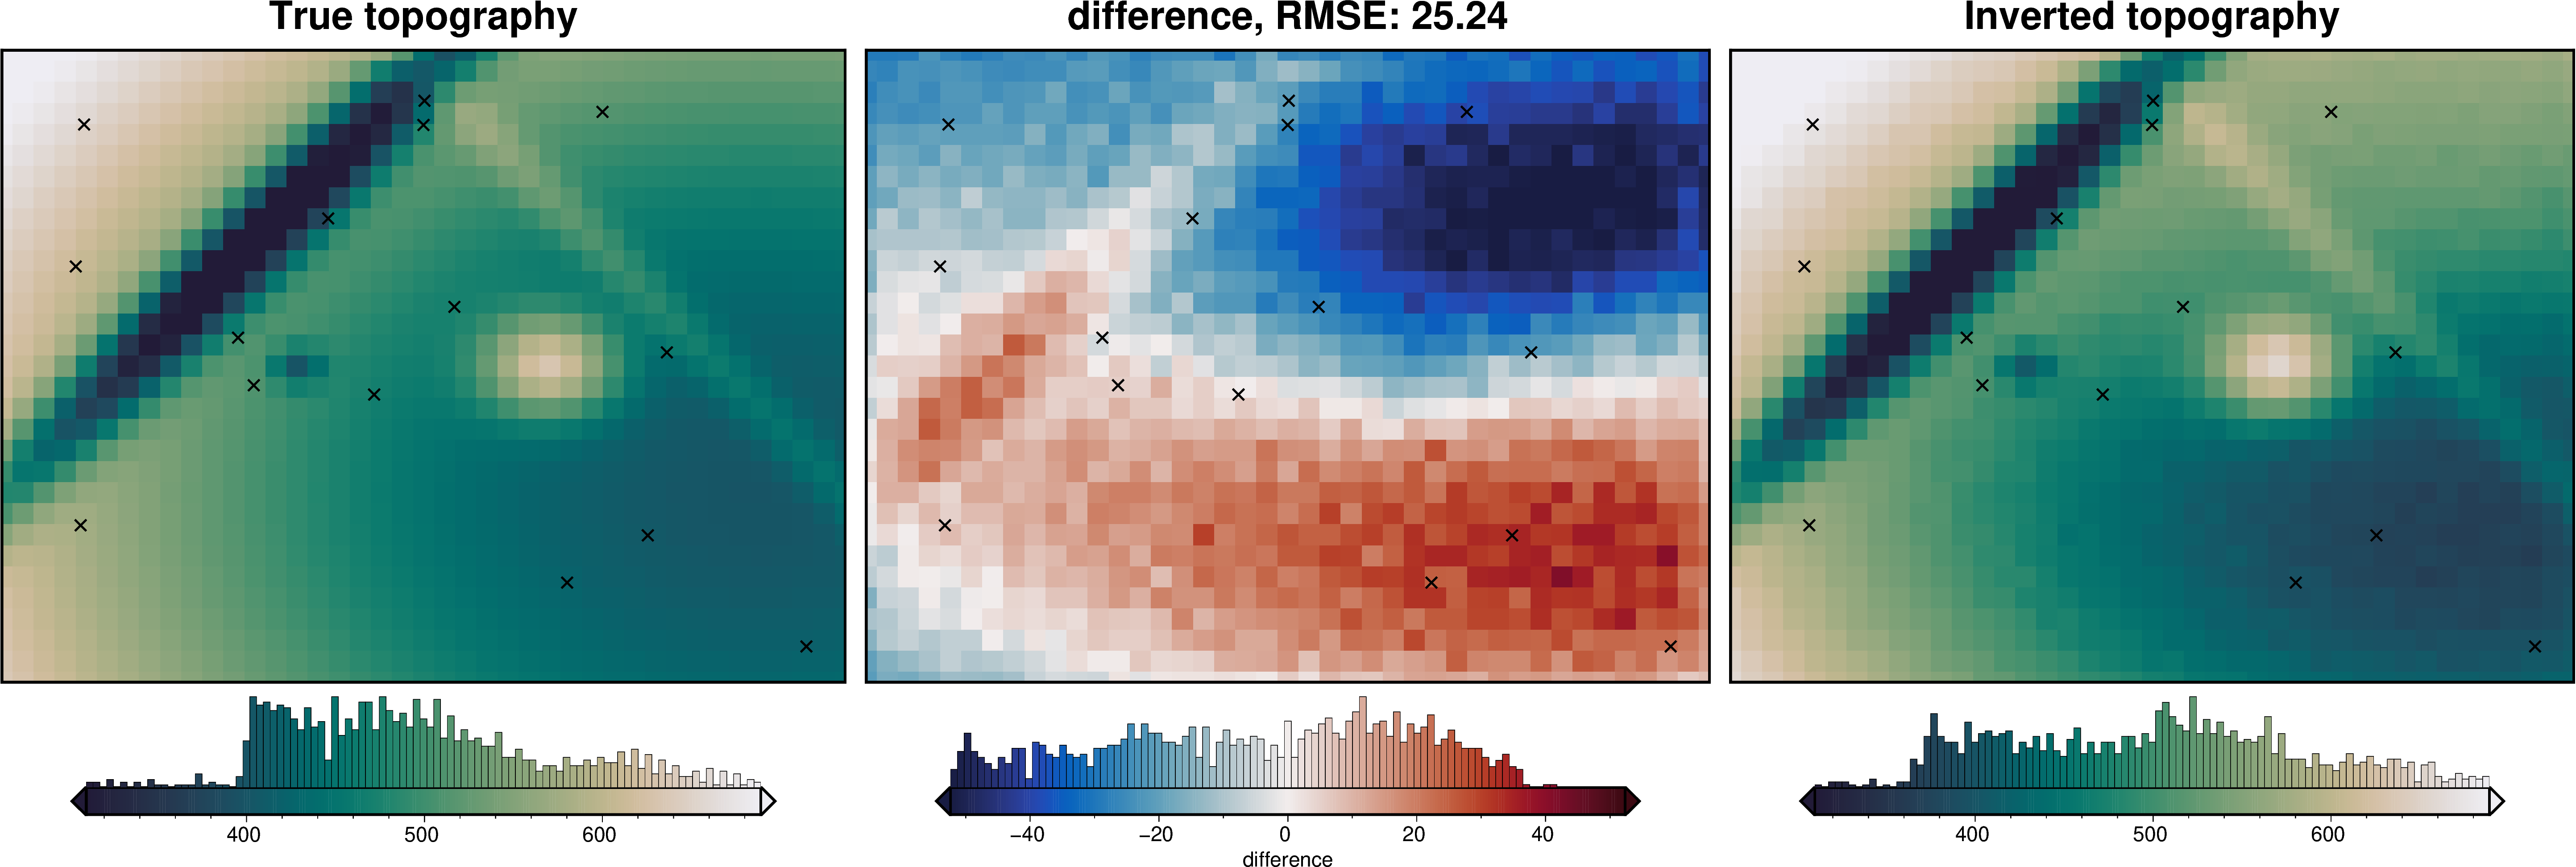

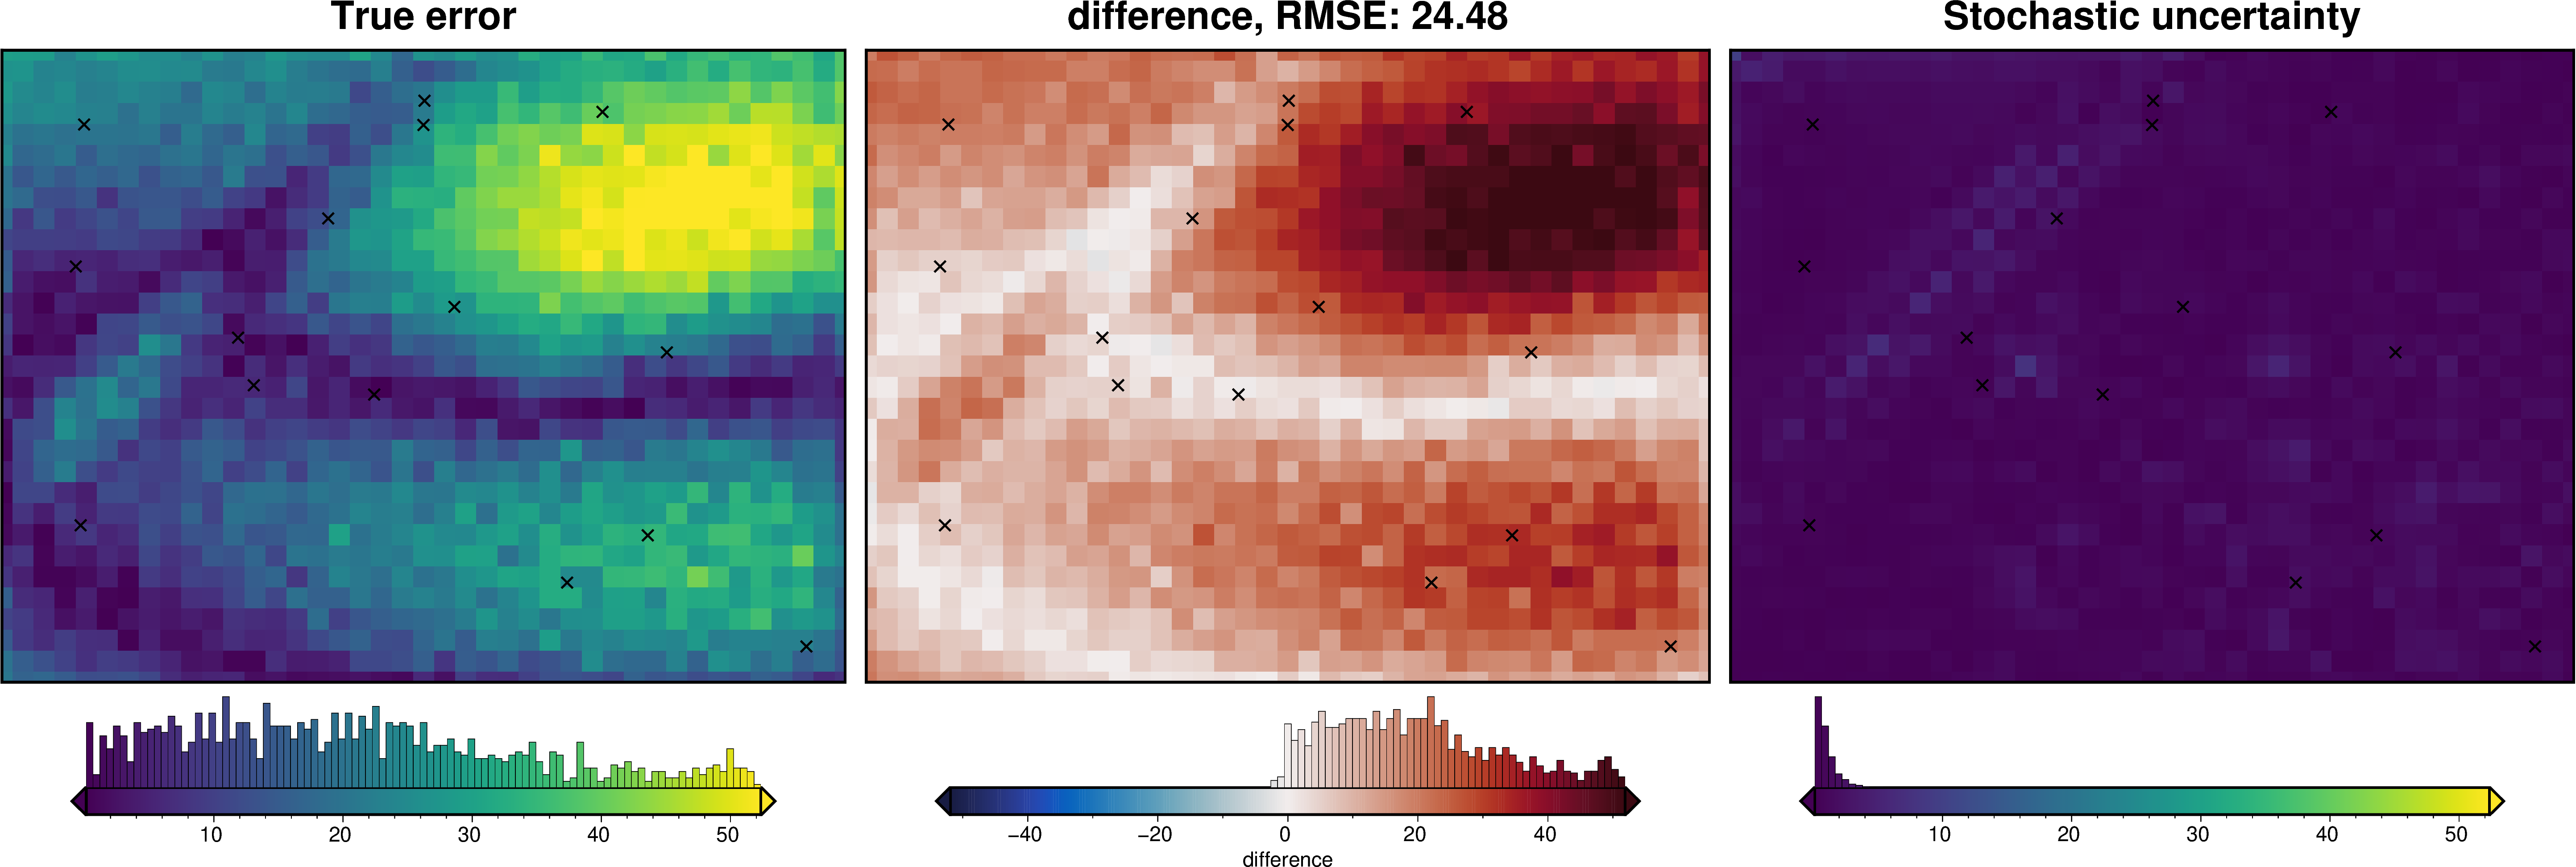

In [23]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(solver_damping),  # mean of base 10 exponent
        "scale": 0.2,  # standard deviation of base 10 exponent
        "log": True,
    },
}

fname = "tmp/uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=solver_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    # calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_damping_results)

#### Gravity component

INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_grav'



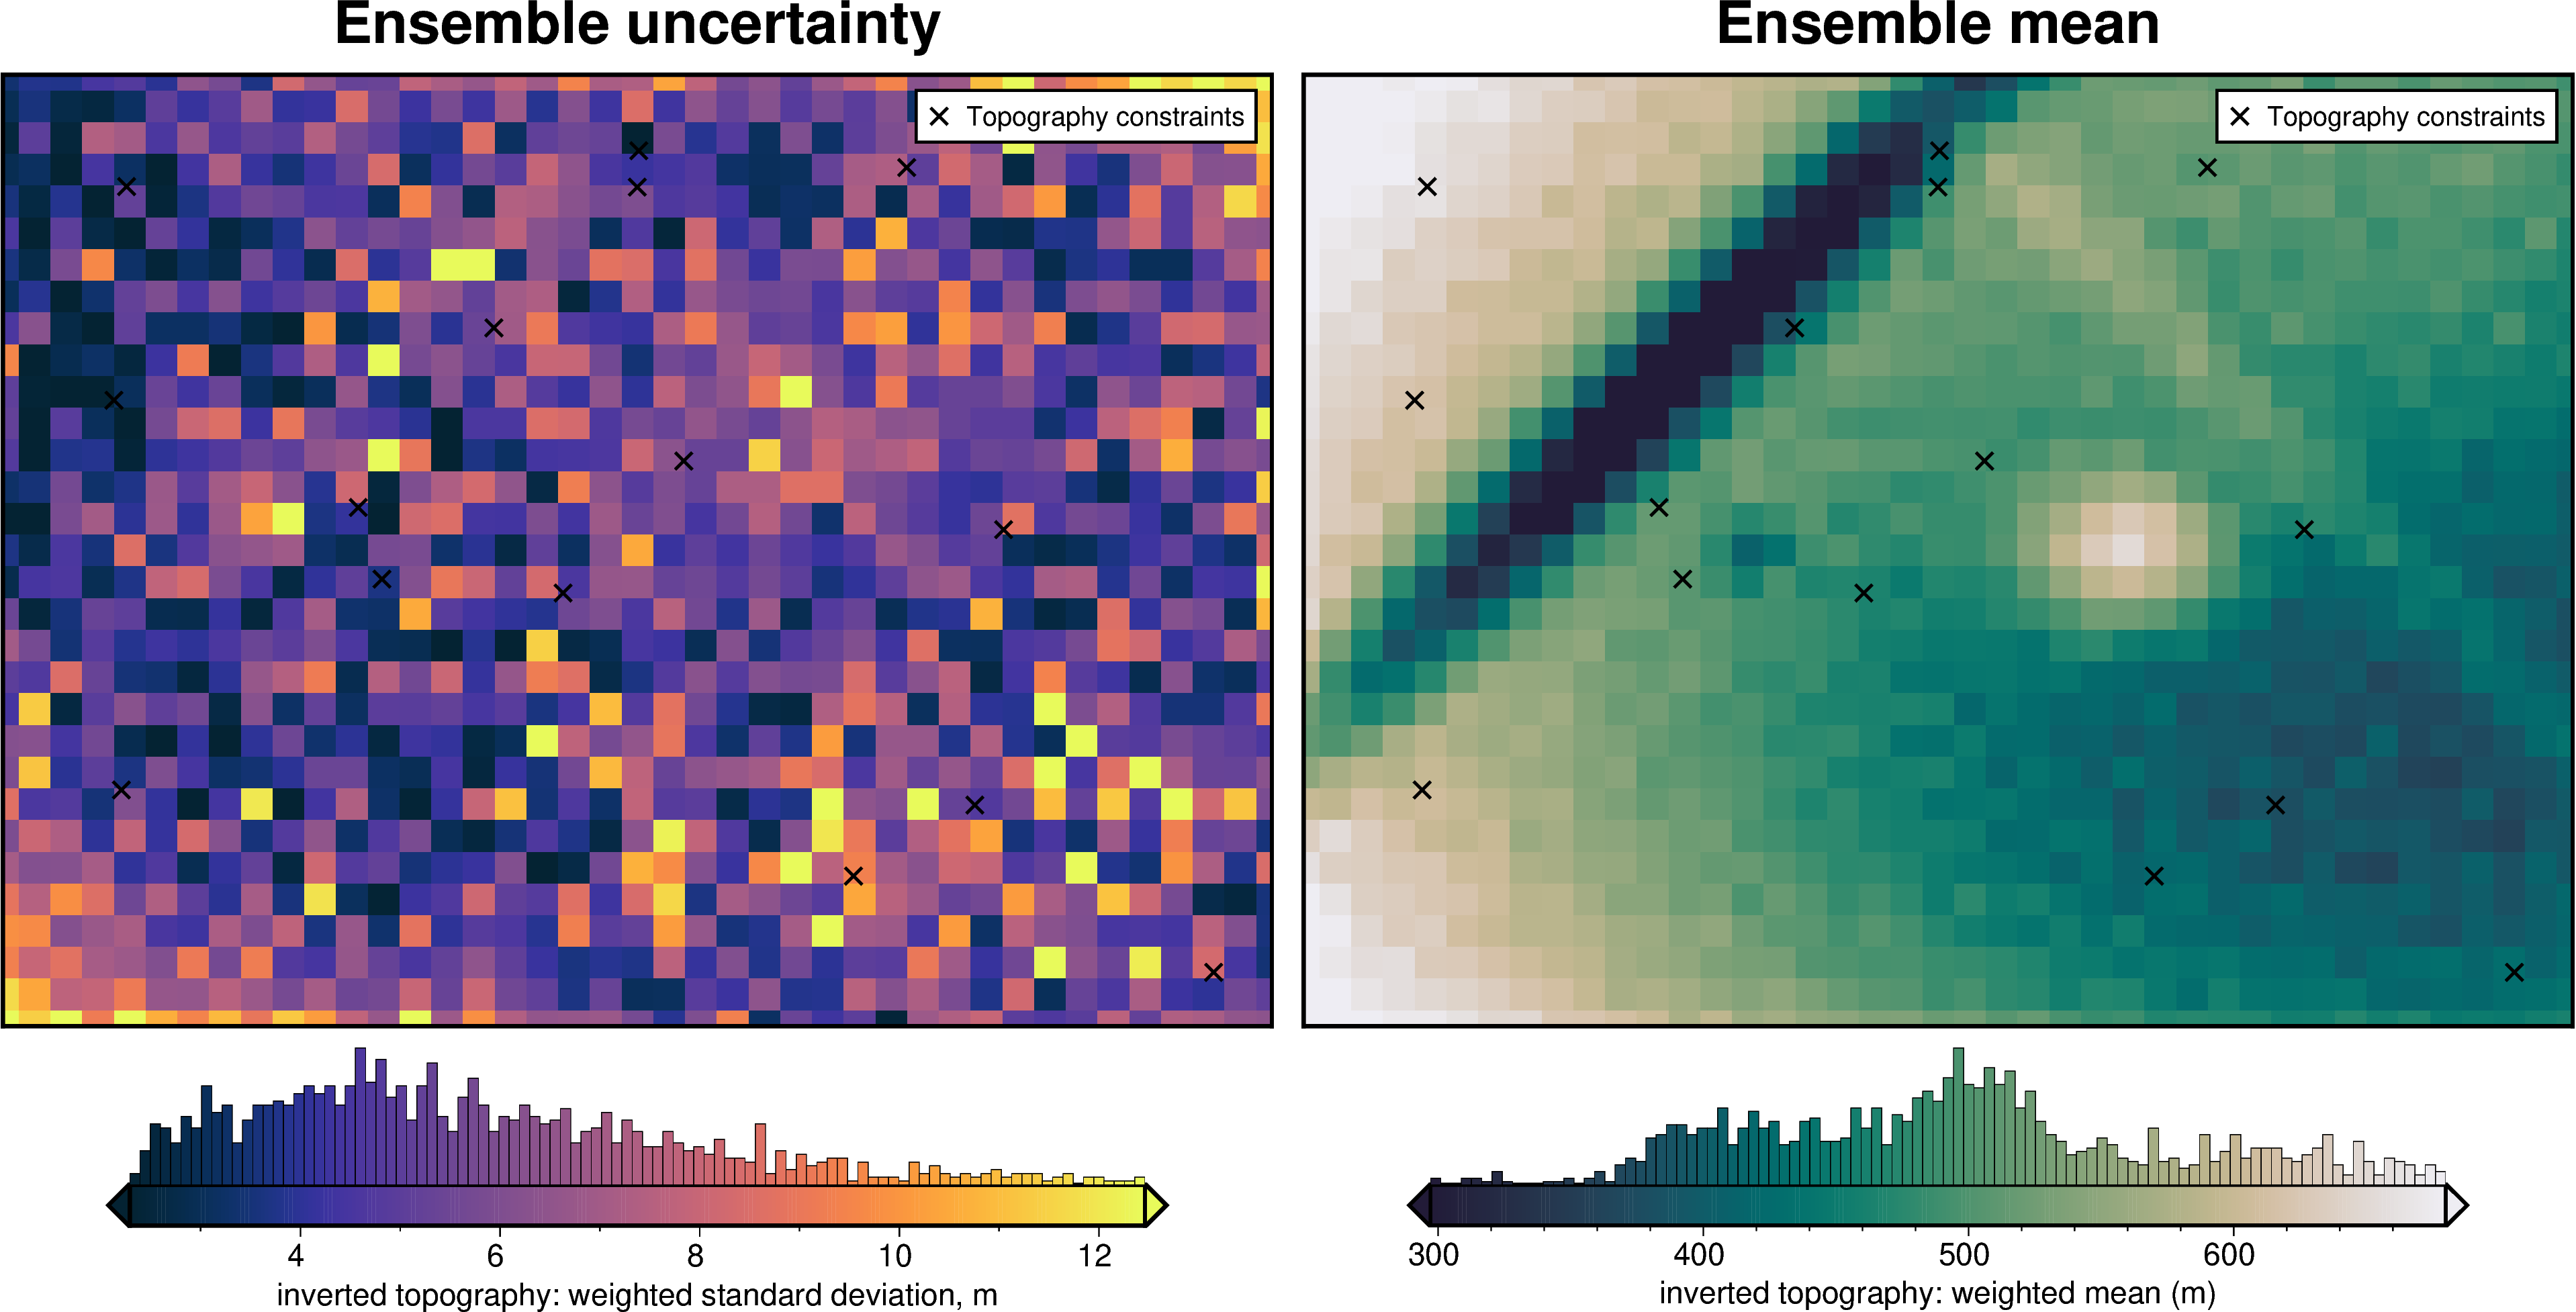

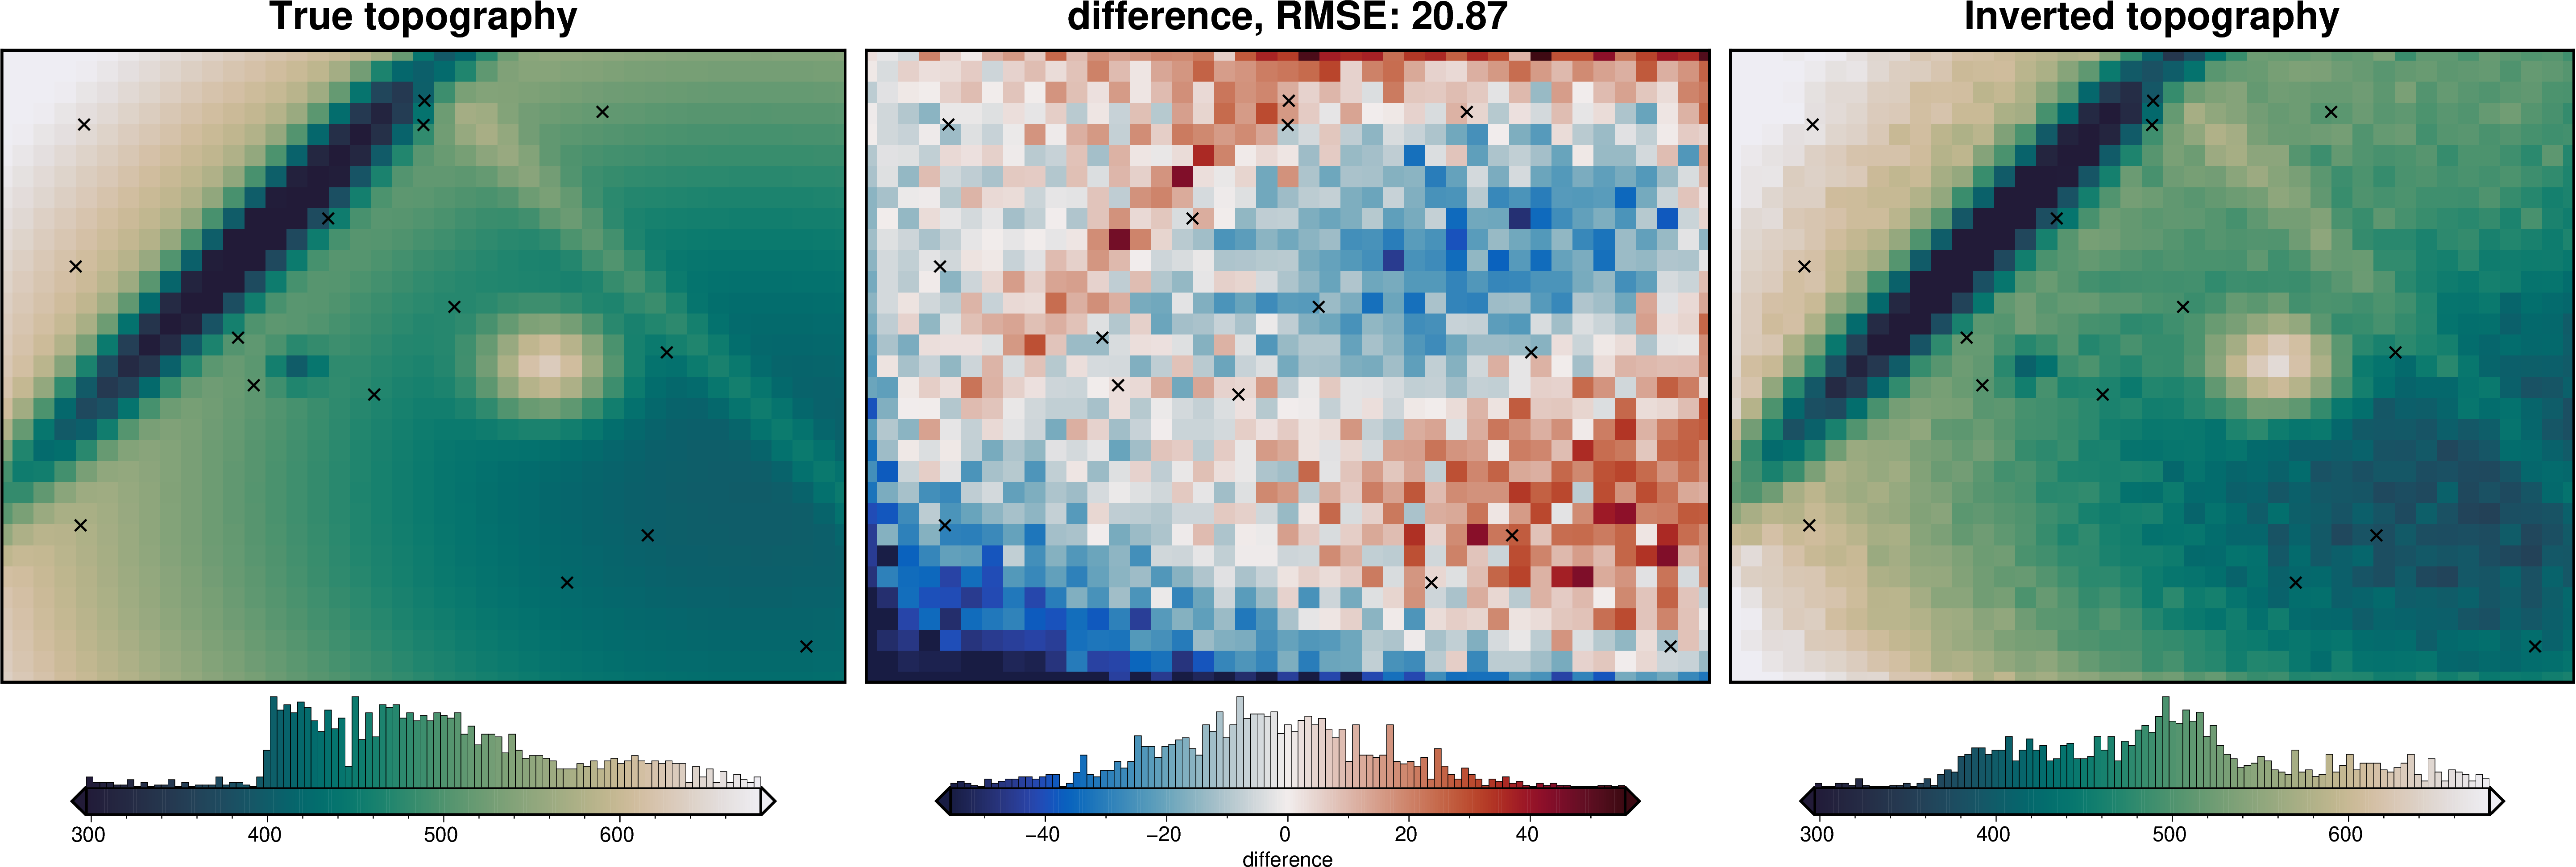

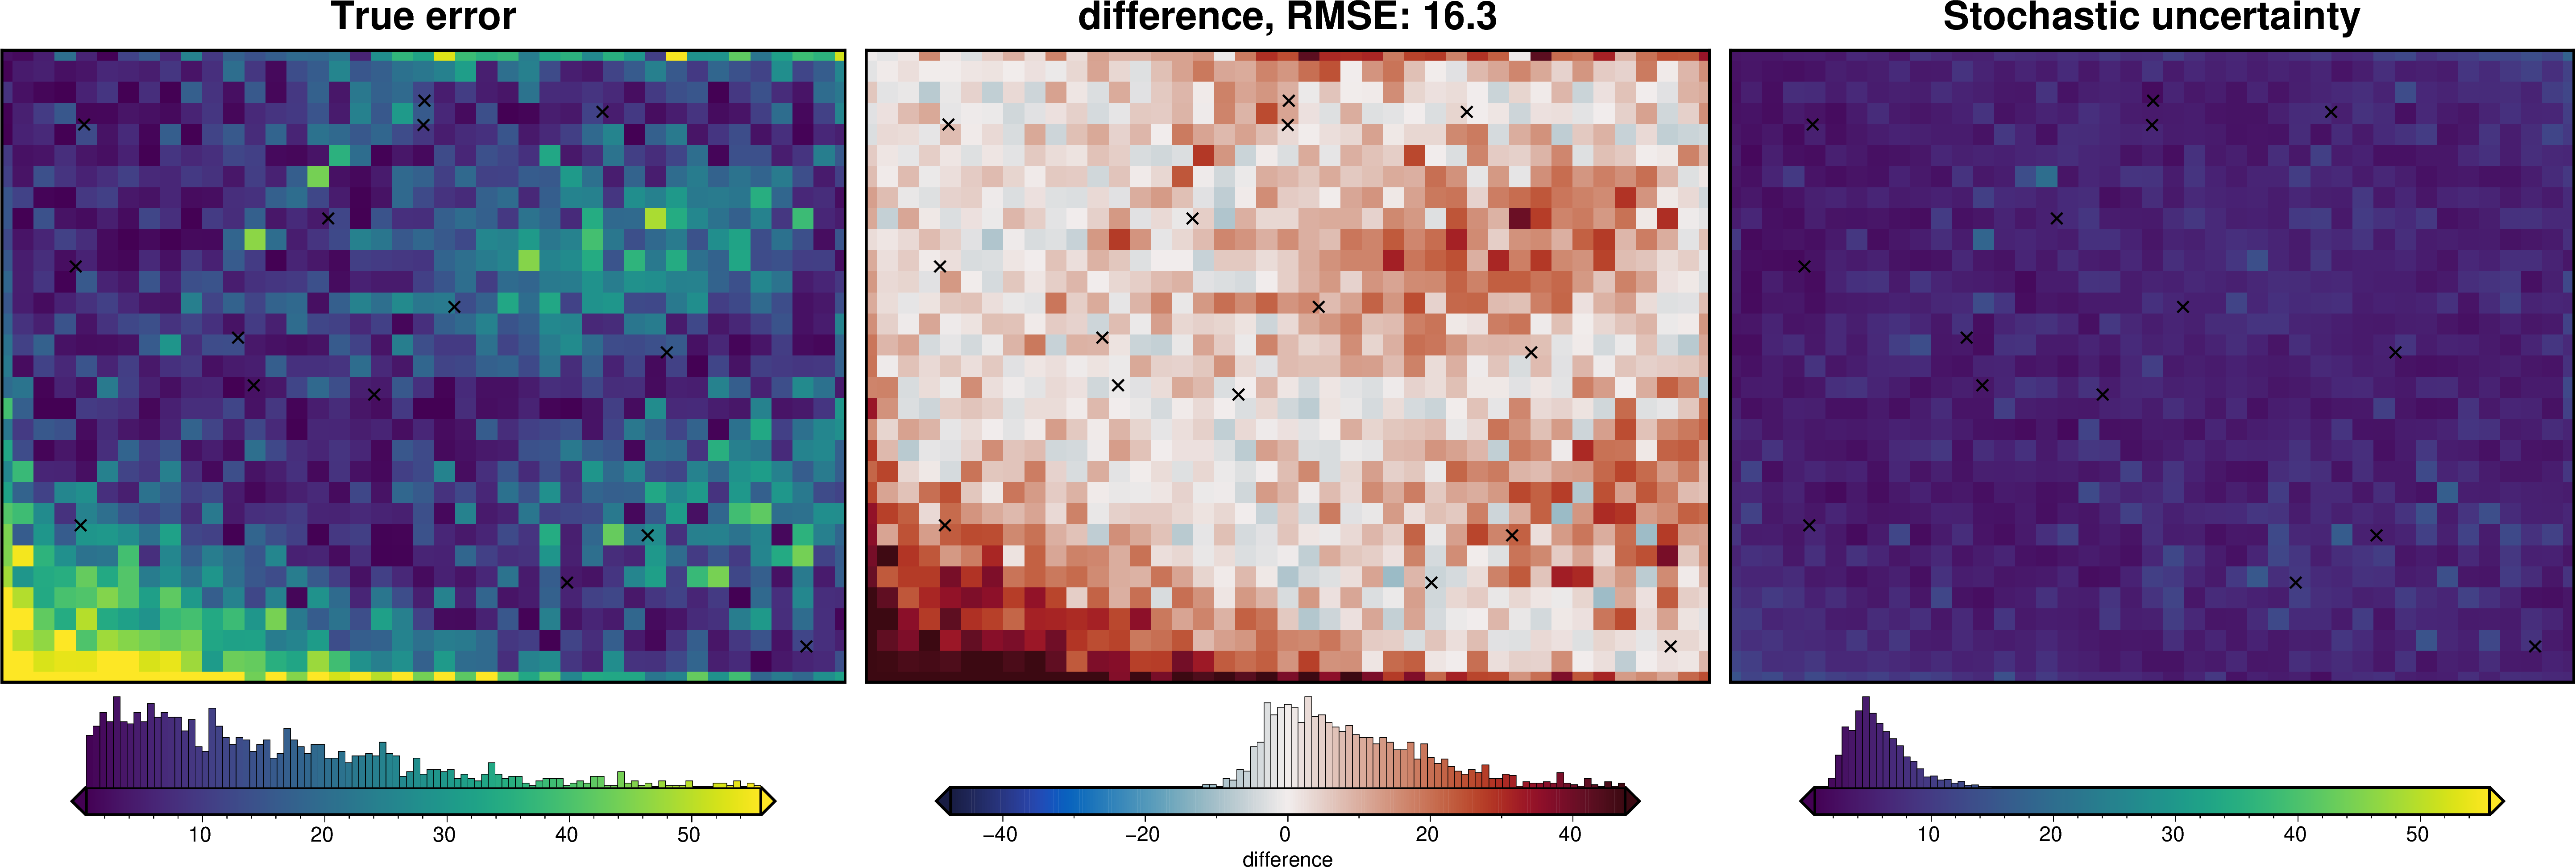

In [24]:
fname = "tmp/uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    sample_gravity=True,
    # sample_constraints=True,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_grav_results)

#### Constraints component

INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_constraints'



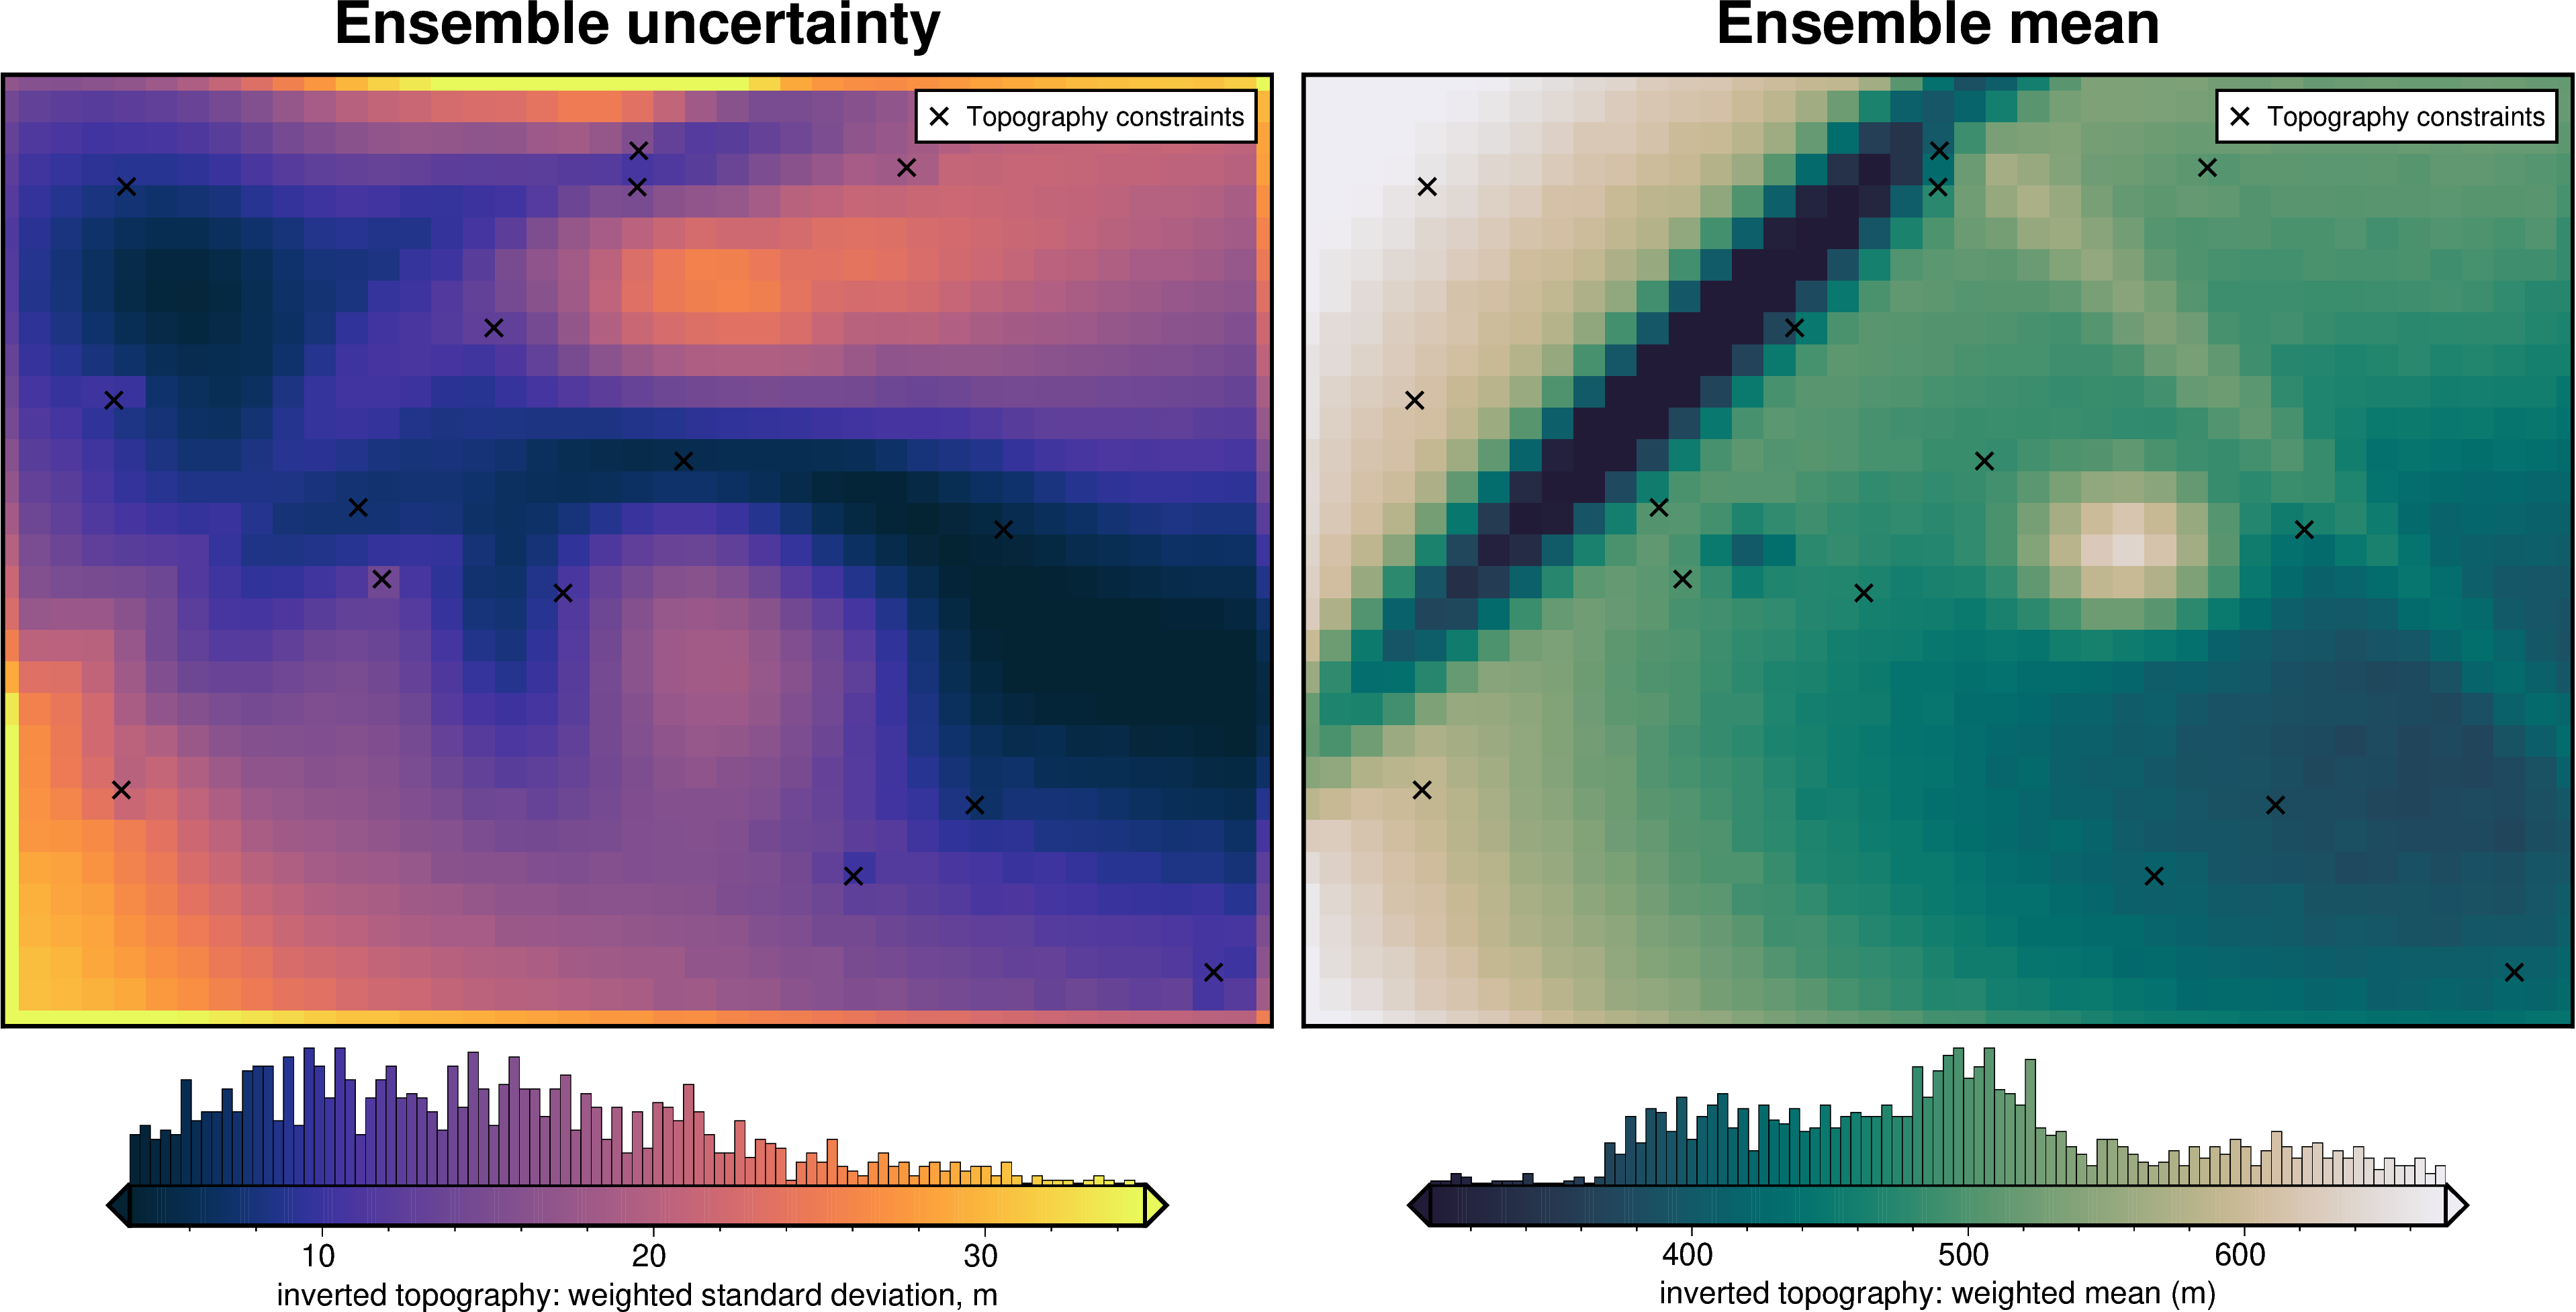

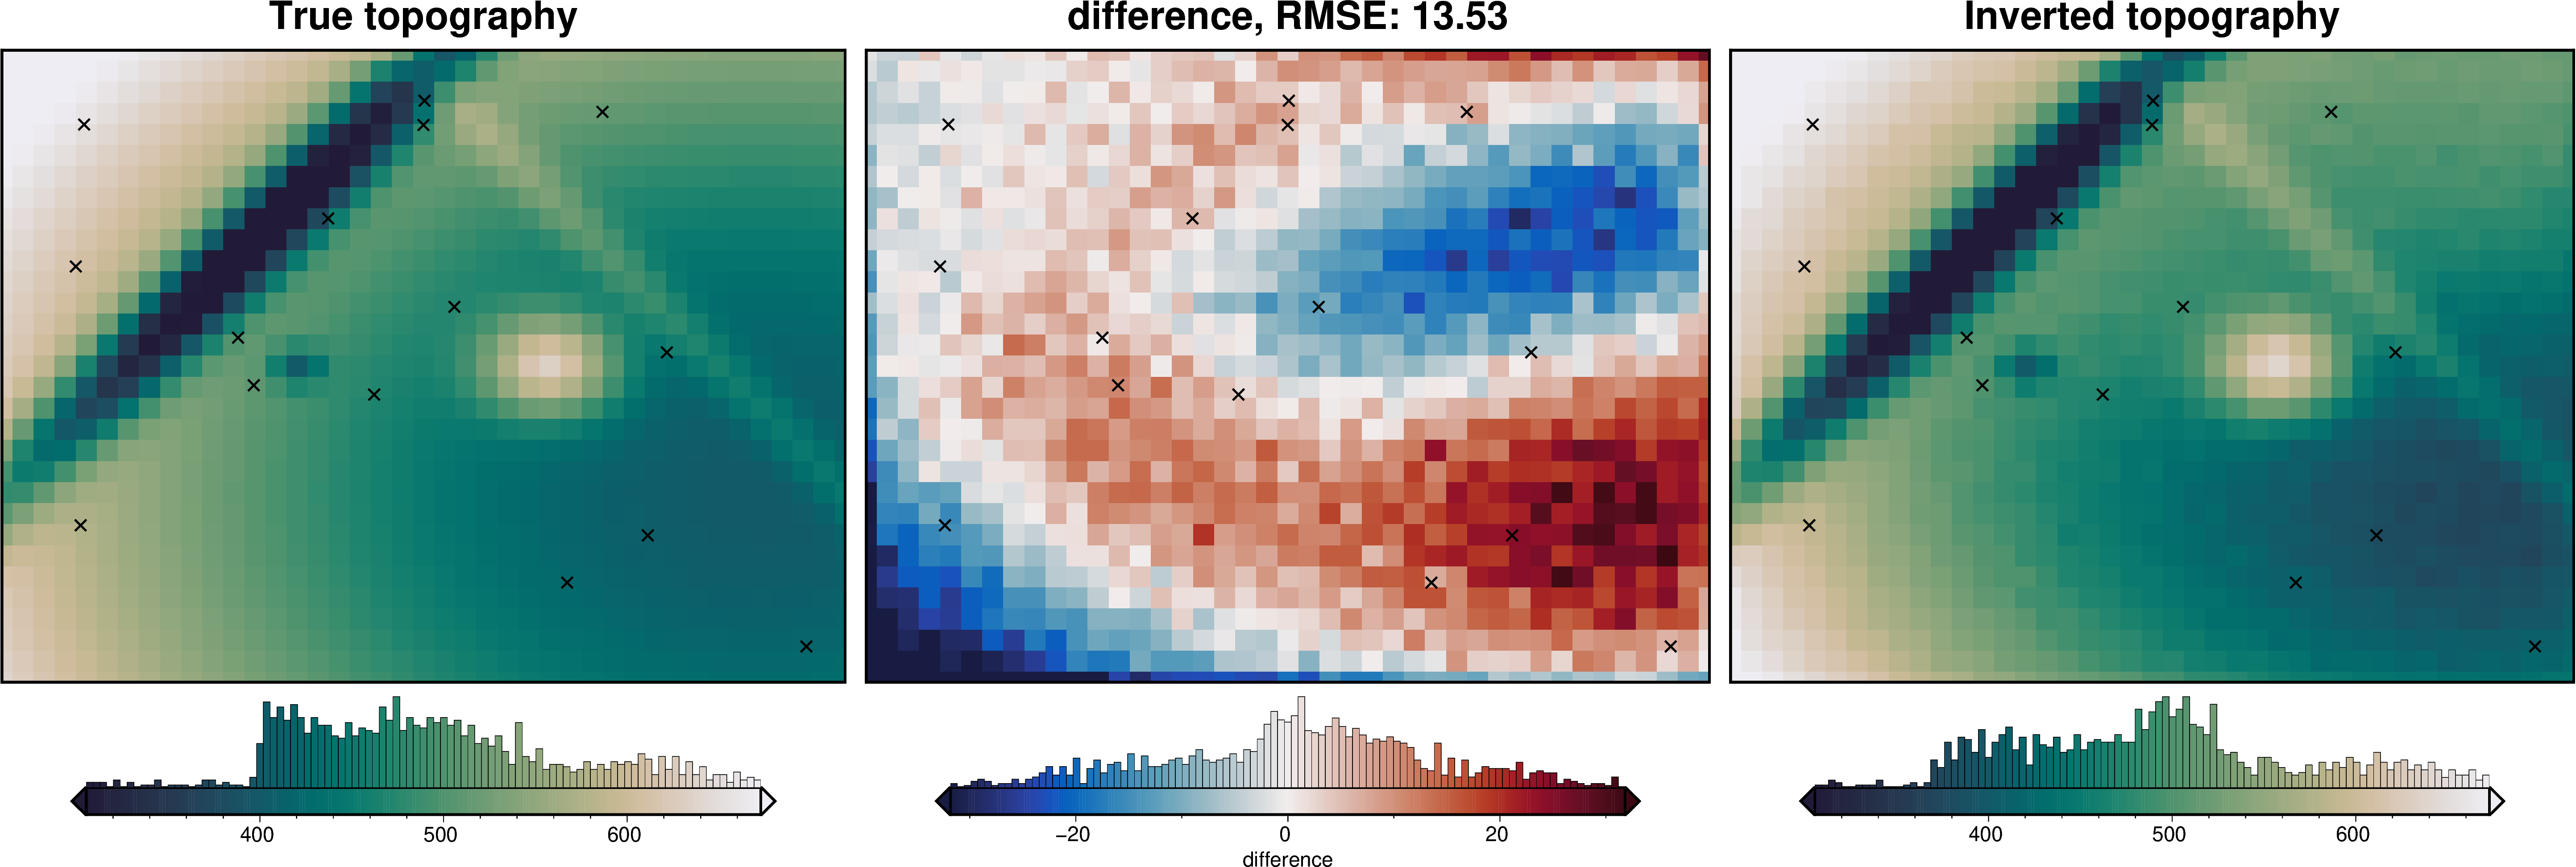

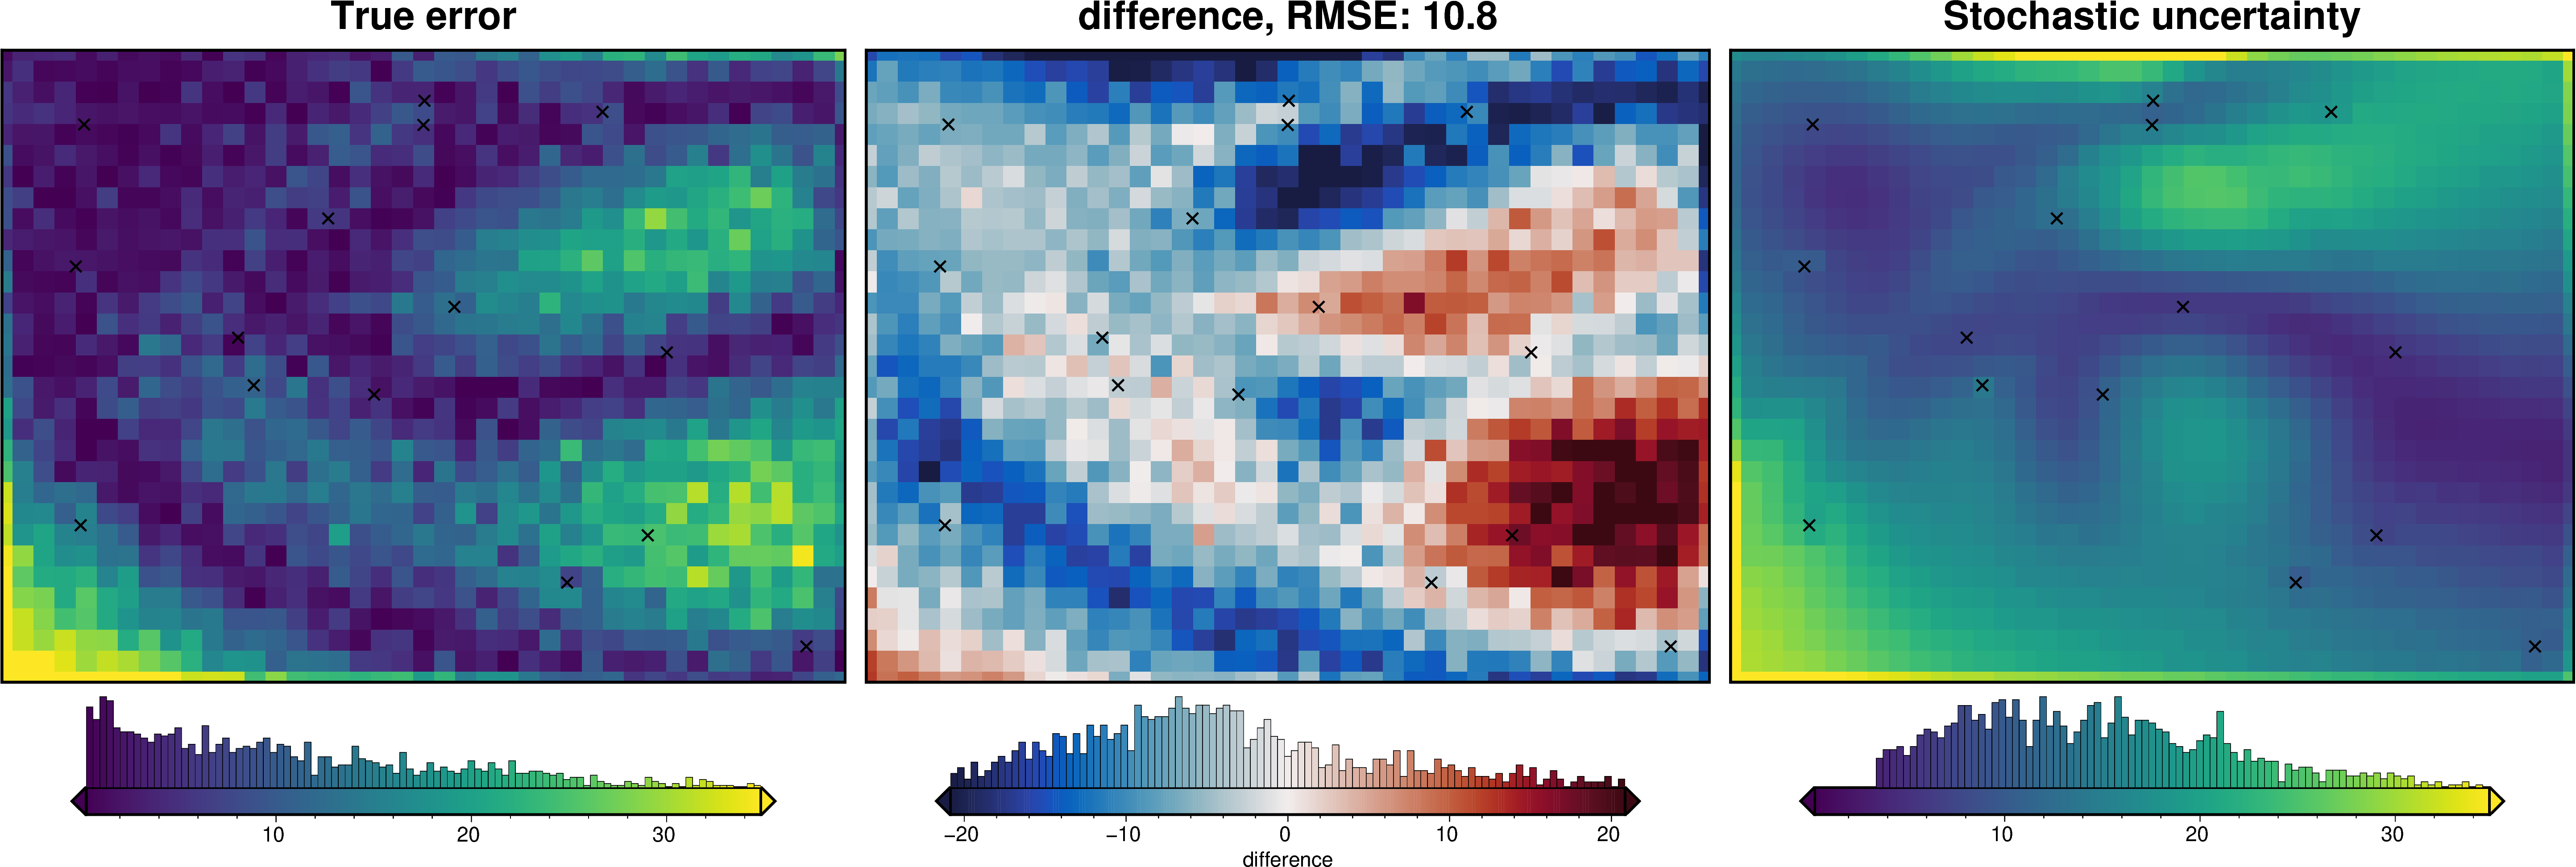

In [25]:
fname = "tmp/uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    sample_constraints=True,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_constraints_results)

### Starting topography component

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 6.201568177573411e-07, min: 3.592291271776981e-08, max: 3.2759368976582972e-06
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_starting_topo' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_starting_topo'



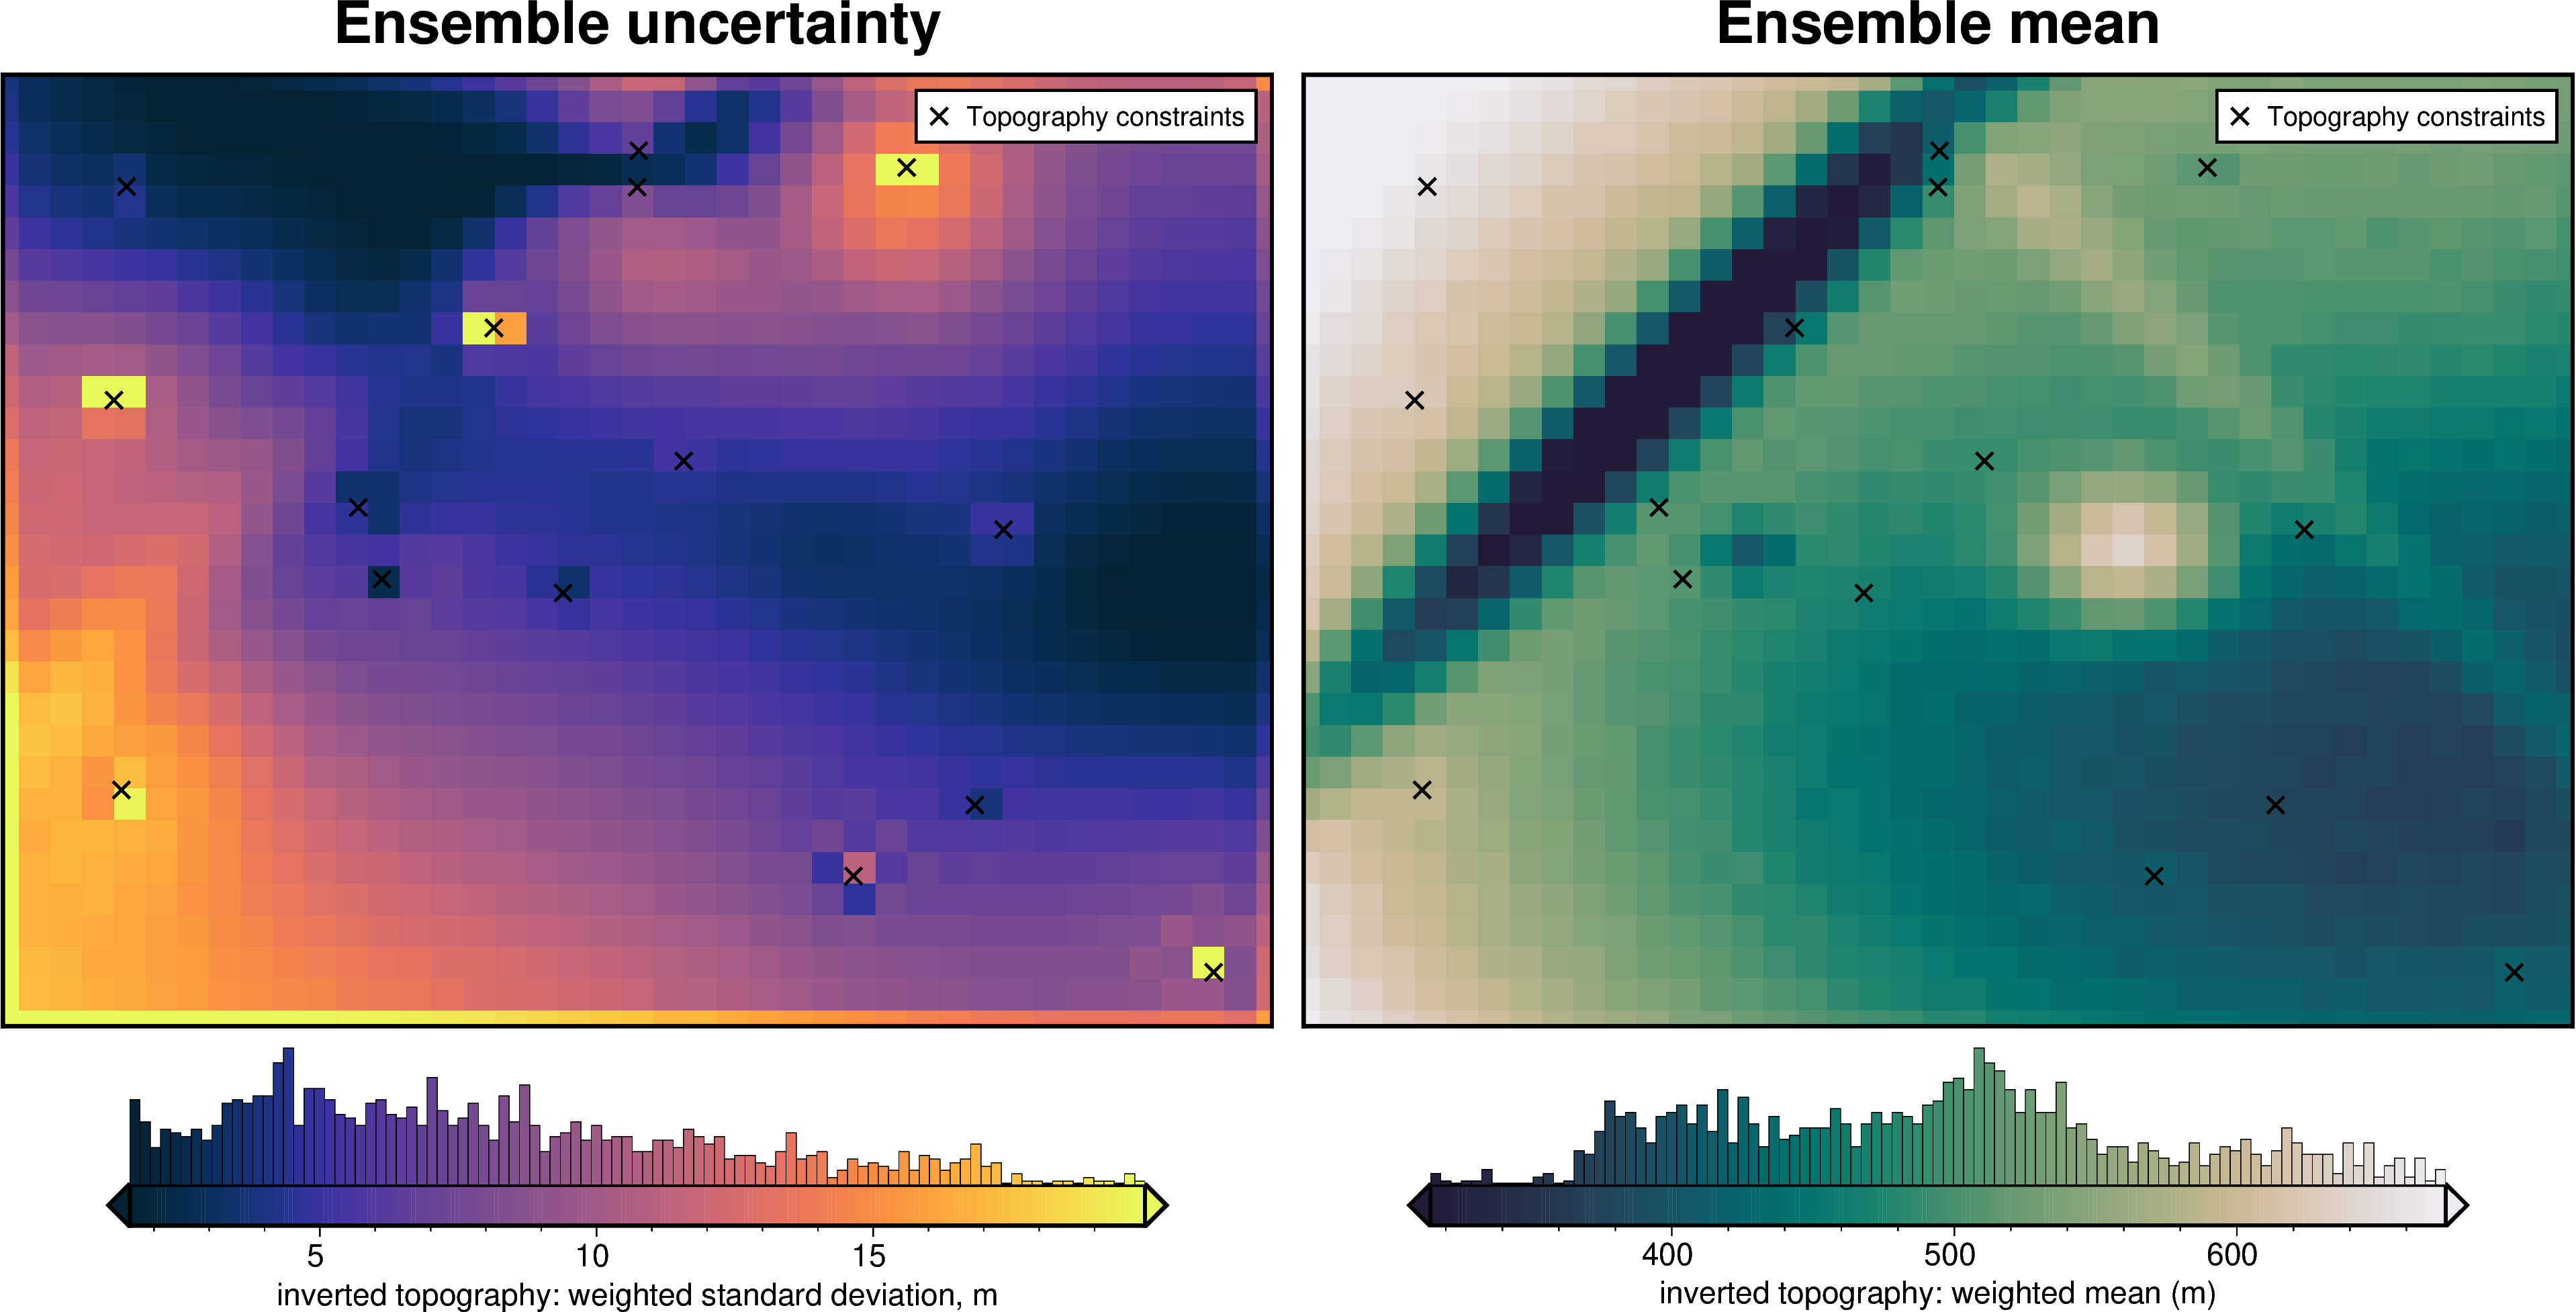

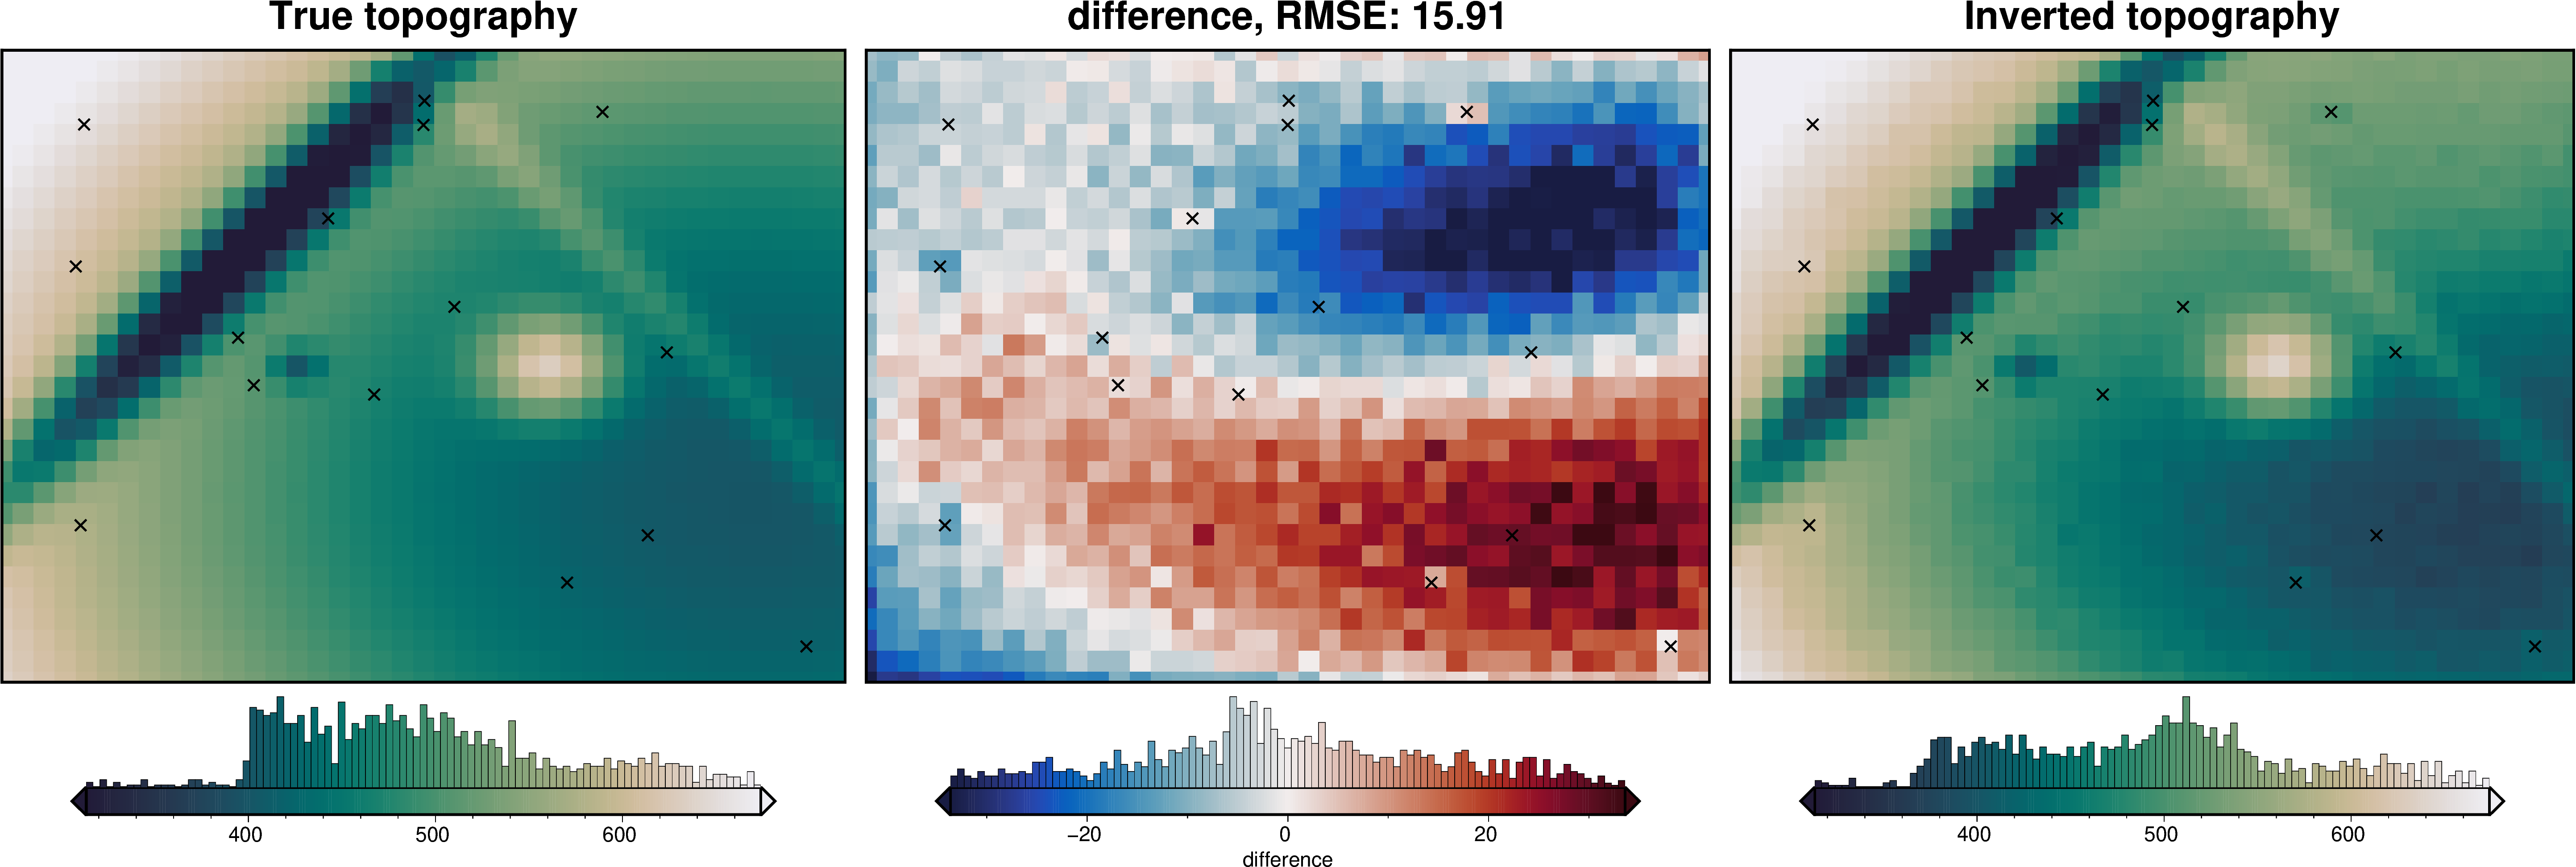

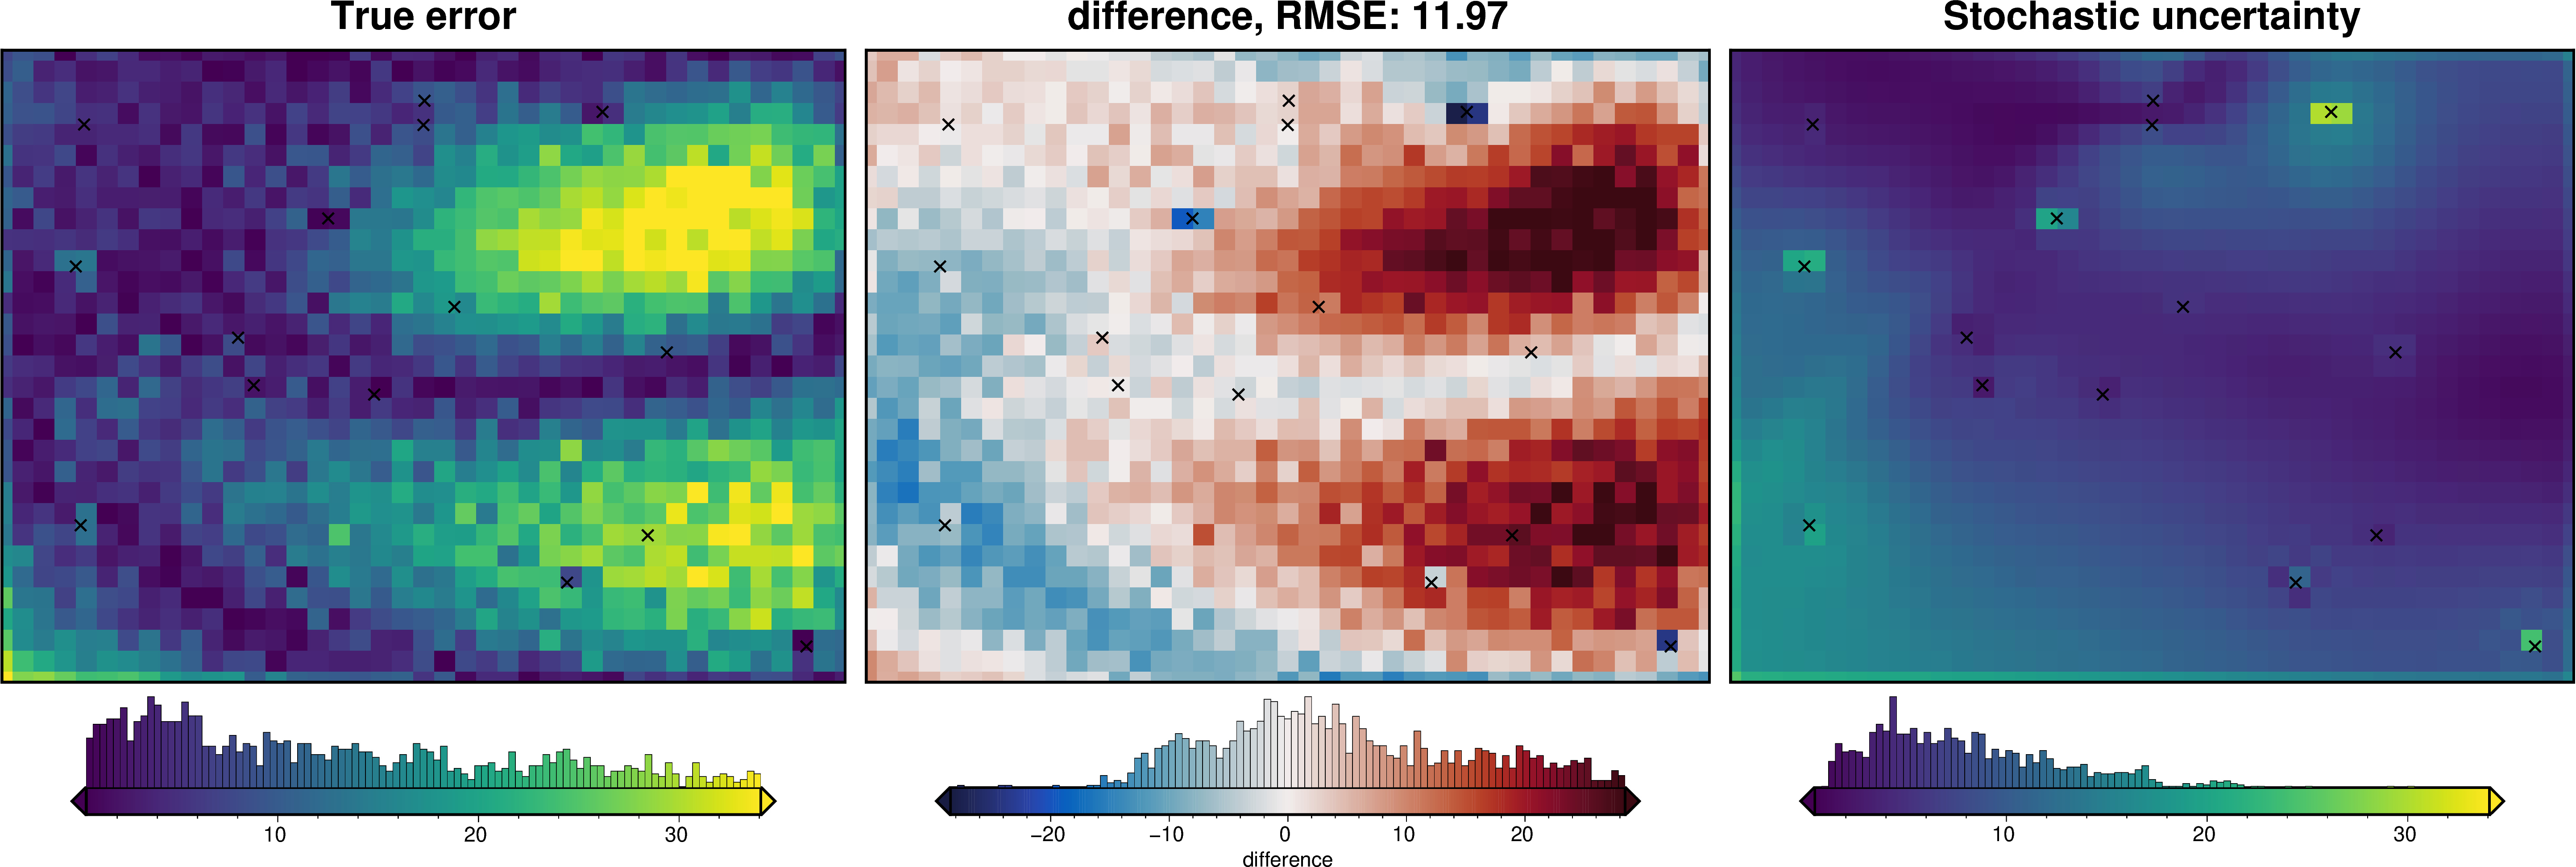

In [26]:
fname = "tmp/uncertainty_starting_topo"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_starting_topo_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_starting_topo_results)

### Regional gravity component

INFO:invert4geom:Sampled 'depth' parameter values; mean: 22396.626035473848, min: 6439.029985198731, max: 38354.22208574897
INFO:invert4geom:Sampled 'damping' parameter values; mean: 2.389253898148588, min: 6.104352757406244e-07, max: 42.21779636559106
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_regional'



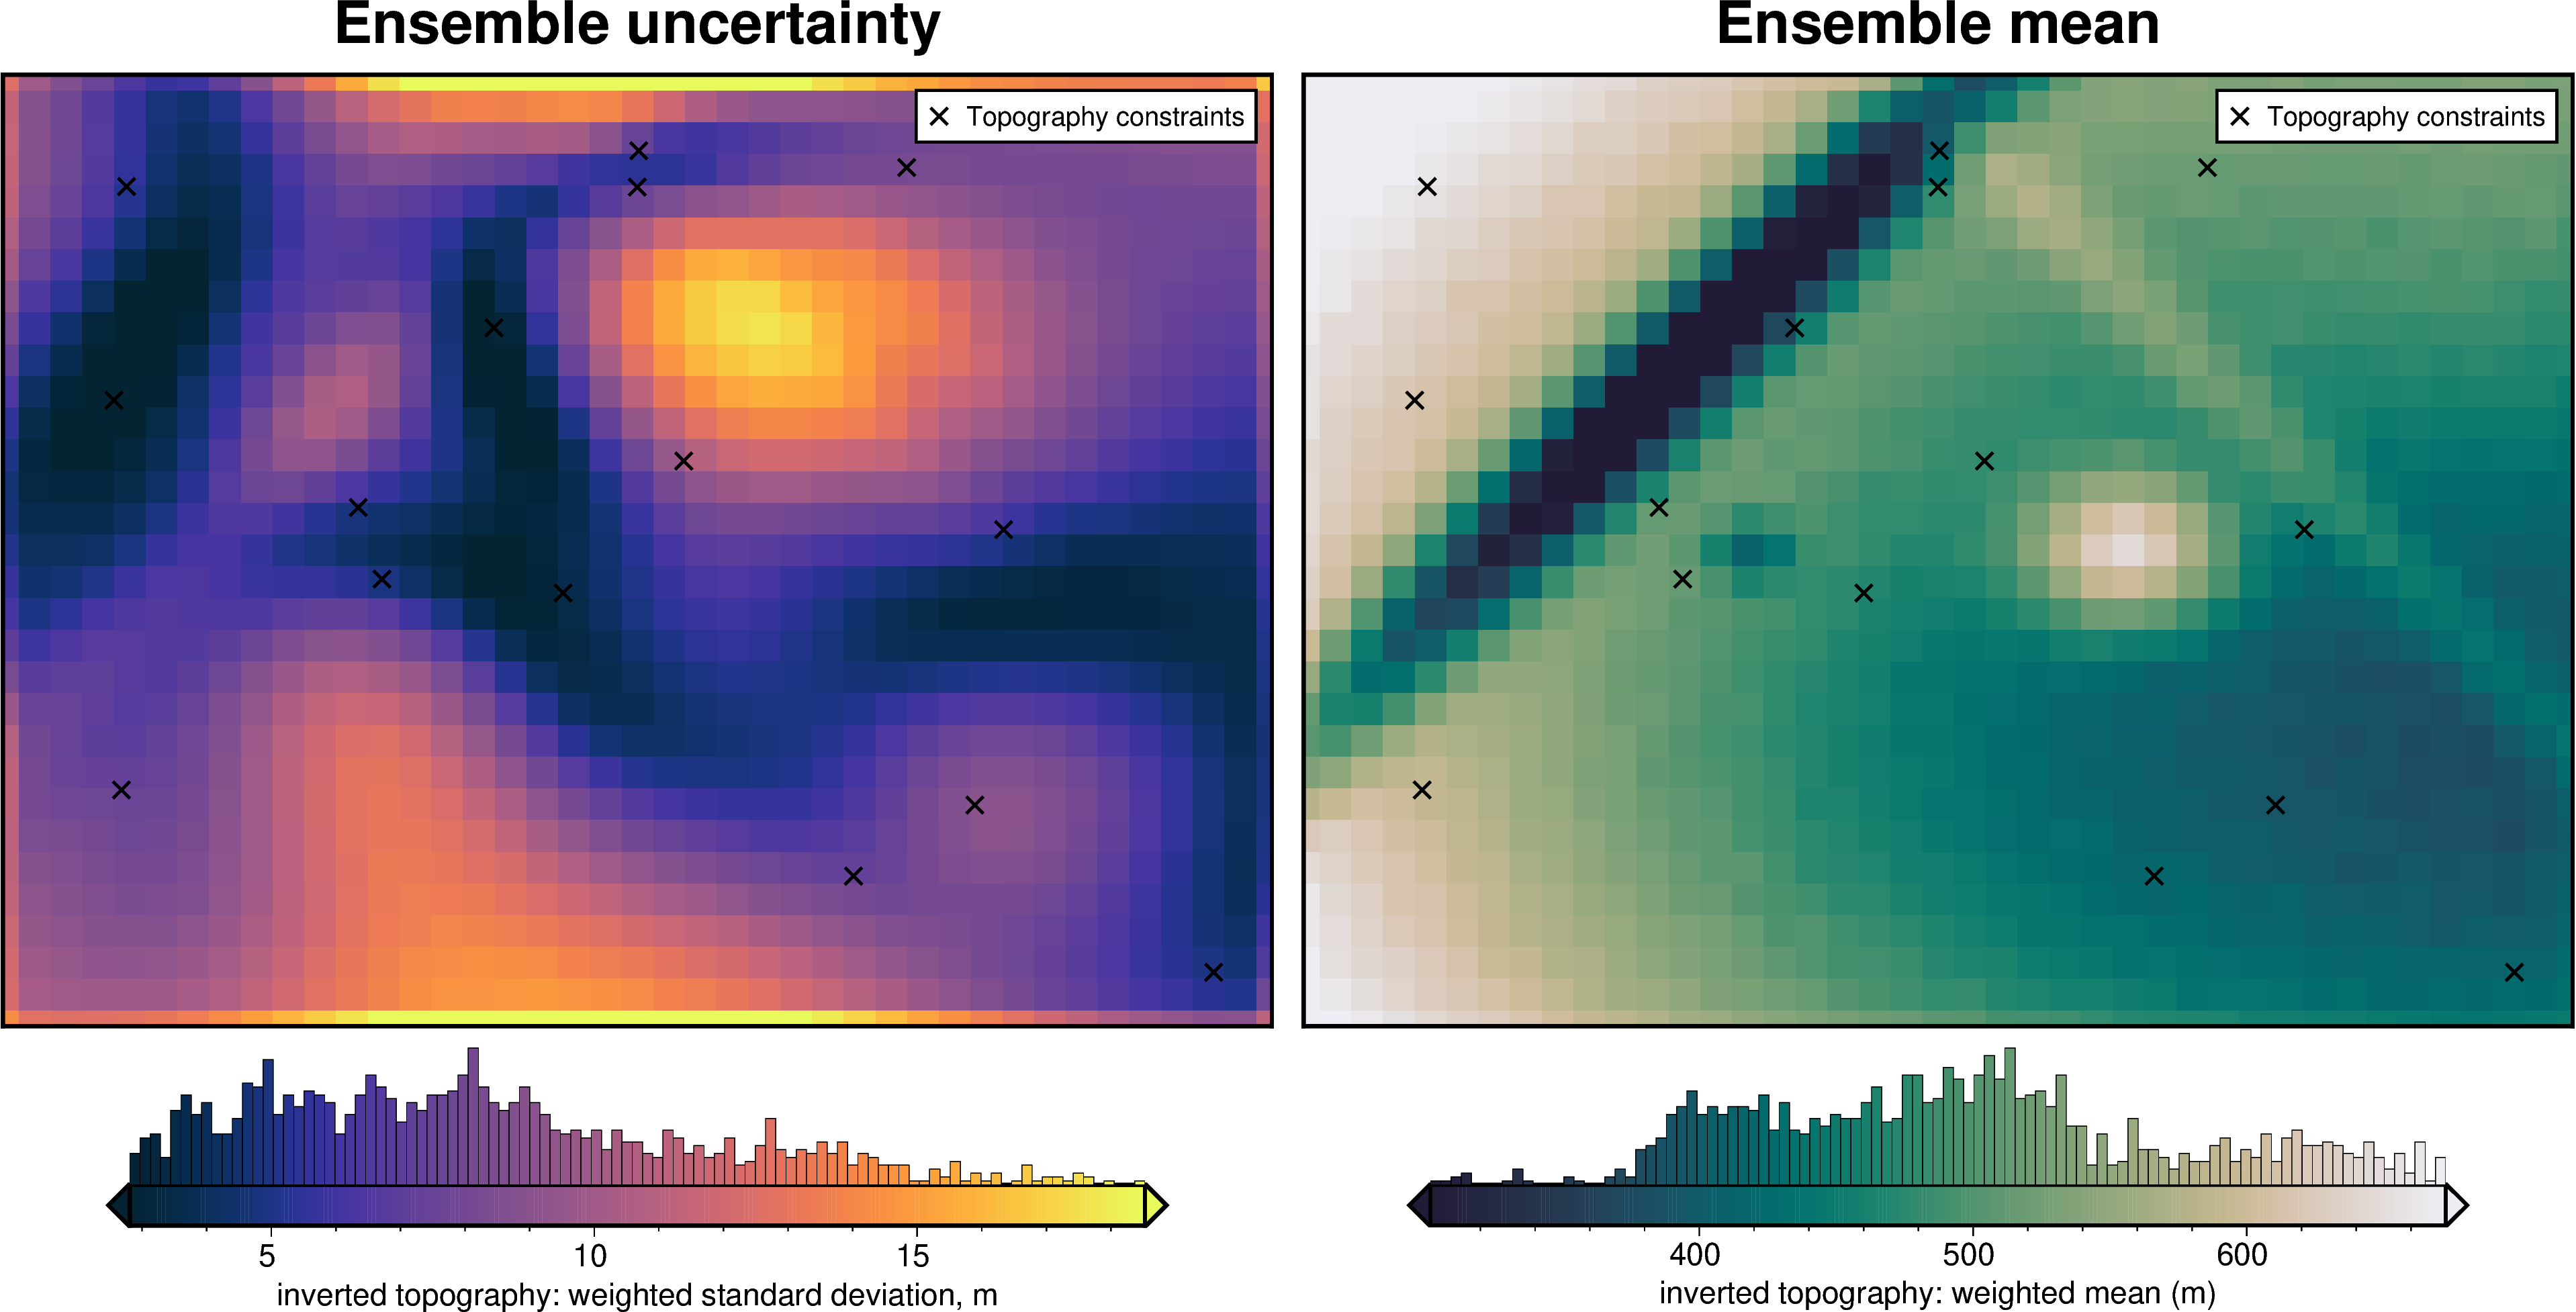

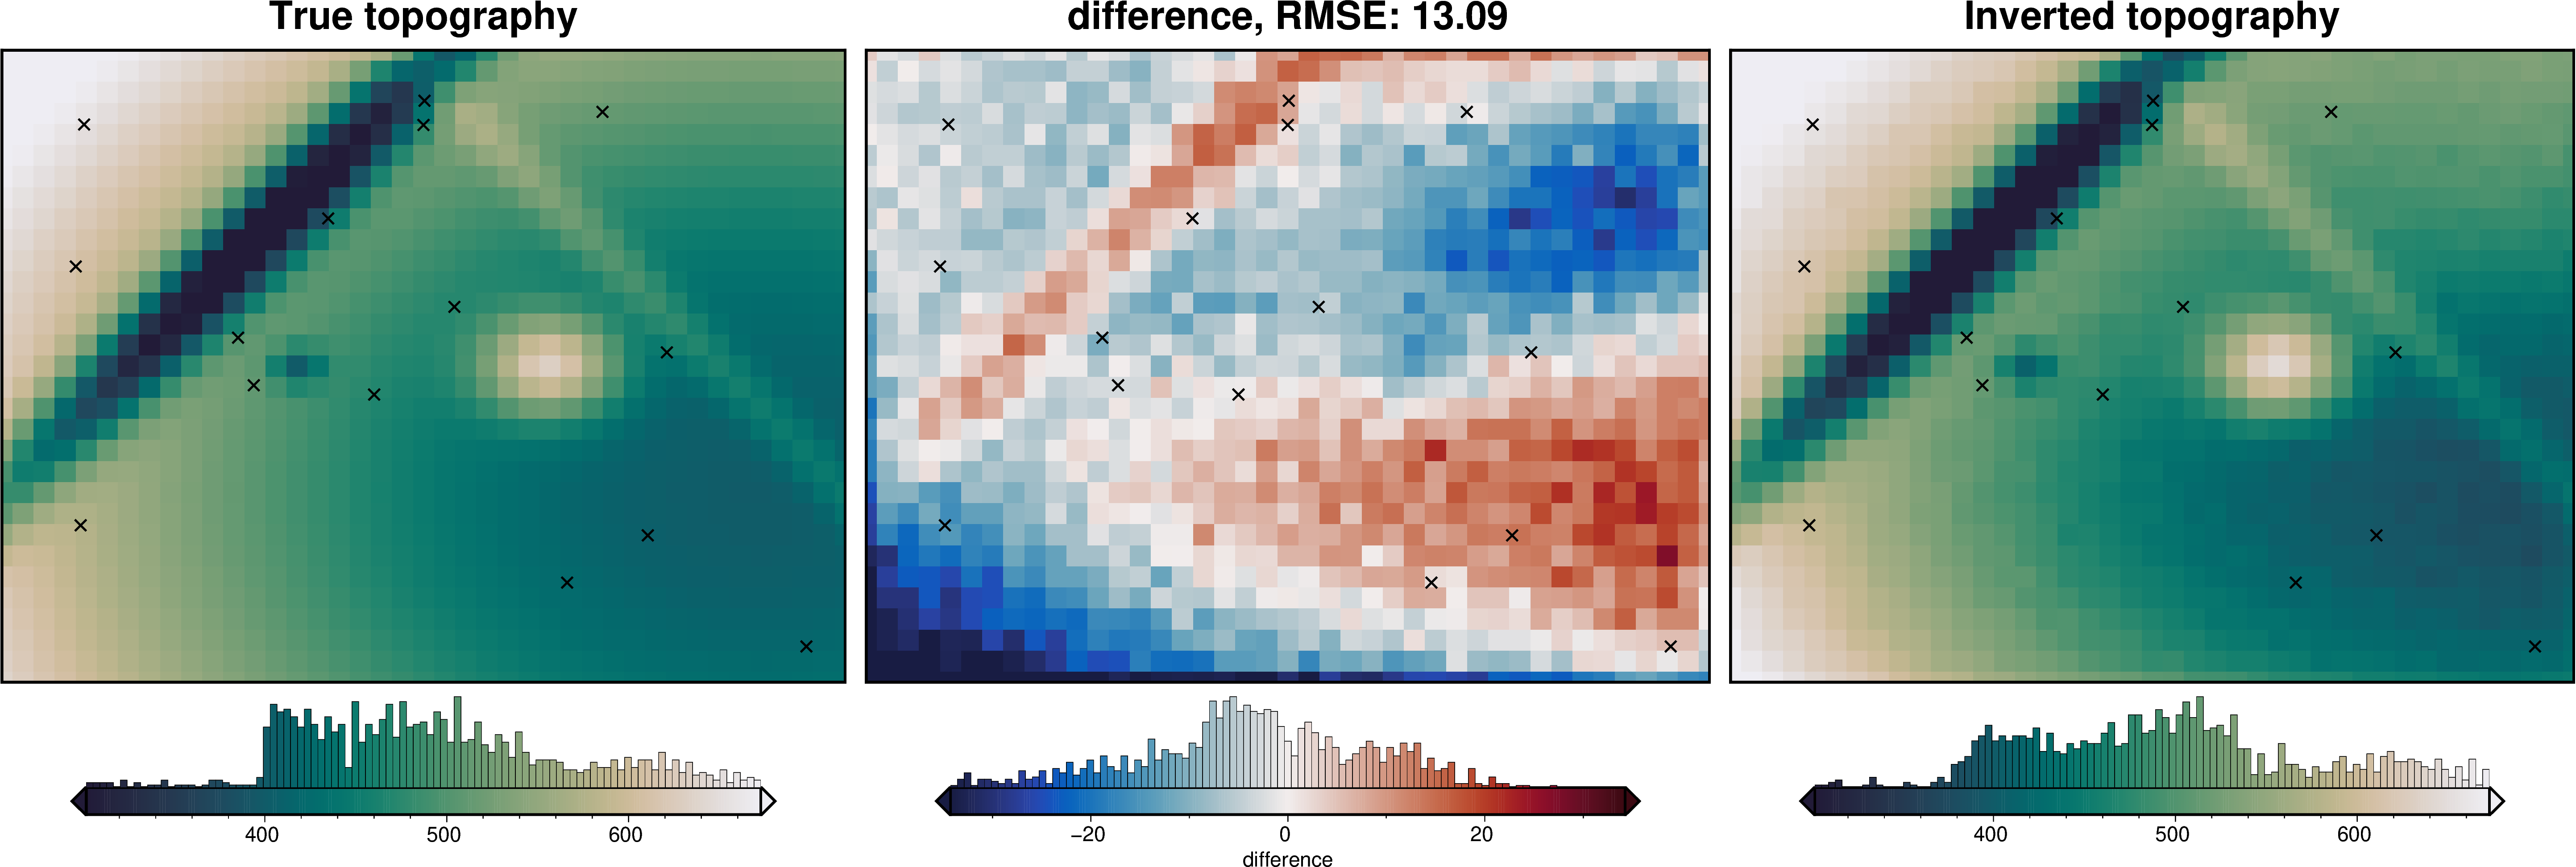

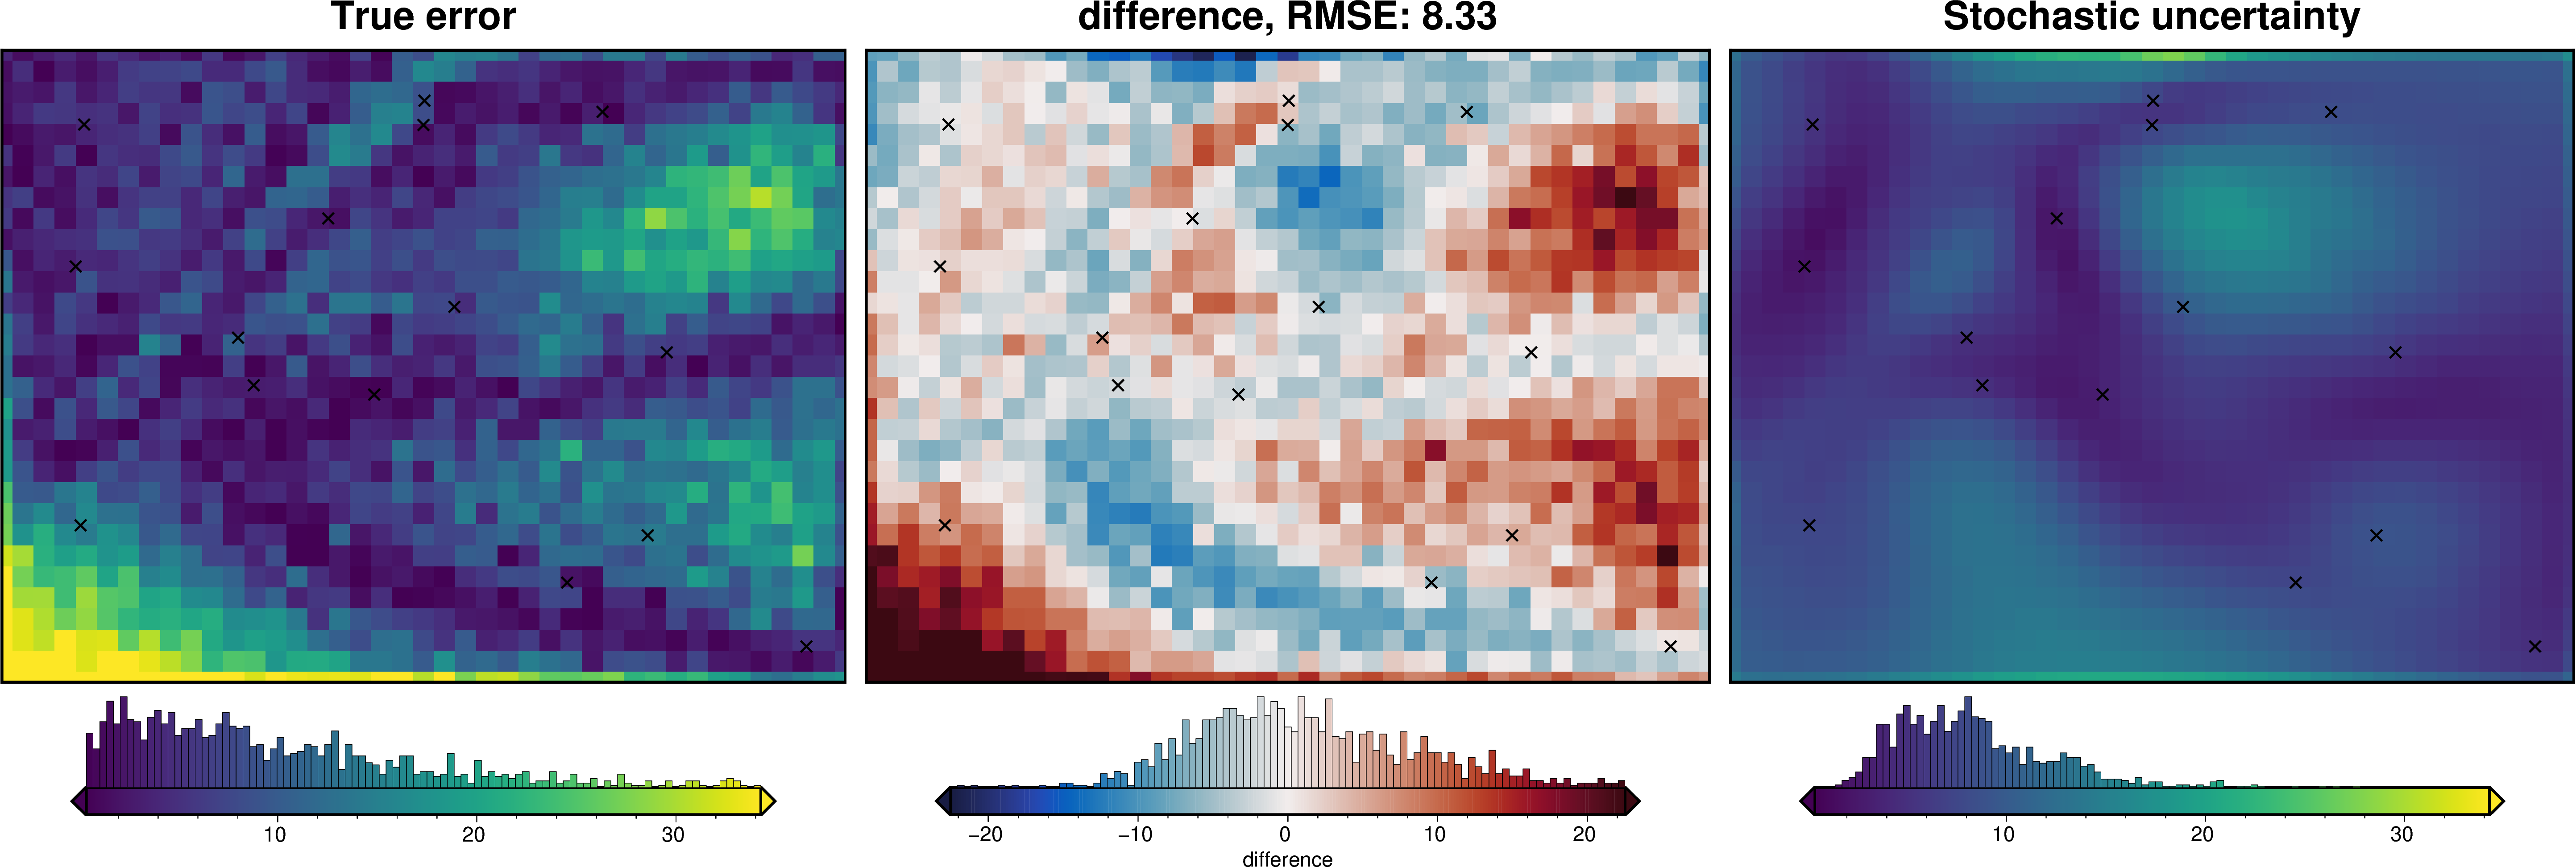

In [29]:
fname = "tmp/uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

# replace regional grav kwargs which use a cross validation to find the best damping
# and depth values with the regional grav kwargs which randomly sample these values
new_kwargs = copy.deepcopy(uncert_kwargs)
new_kwargs["regional_grav_kwargs"] = regional_kwargs

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **new_kwargs,
)

uncert_plots(uncert_regional_results)

### Total Uncertainty

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2641.92282038, min: 2347.9282226989917, max: 2935.9174180610084
INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.025600141316290063, min: 0.00940542210866402, max: 0.057195766561986244
INFO:invert4geom:Sampled 'dampings' parameter values; mean: 6.201568177573411e-07, min: 3.592291271776981e-08, max: 3.2759368976582972e-06
INFO:invert4geom:Sampled 'depth' parameter values; mean: 22396.626035473848, min: 6439.029985198731, max: 38354.22208574897
INFO:invert4geom:Sampled 'damping' parameter values; mean: 2.389253898148588, min: 6.104352757406244e-07, max: 42.21779636559106
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_full'



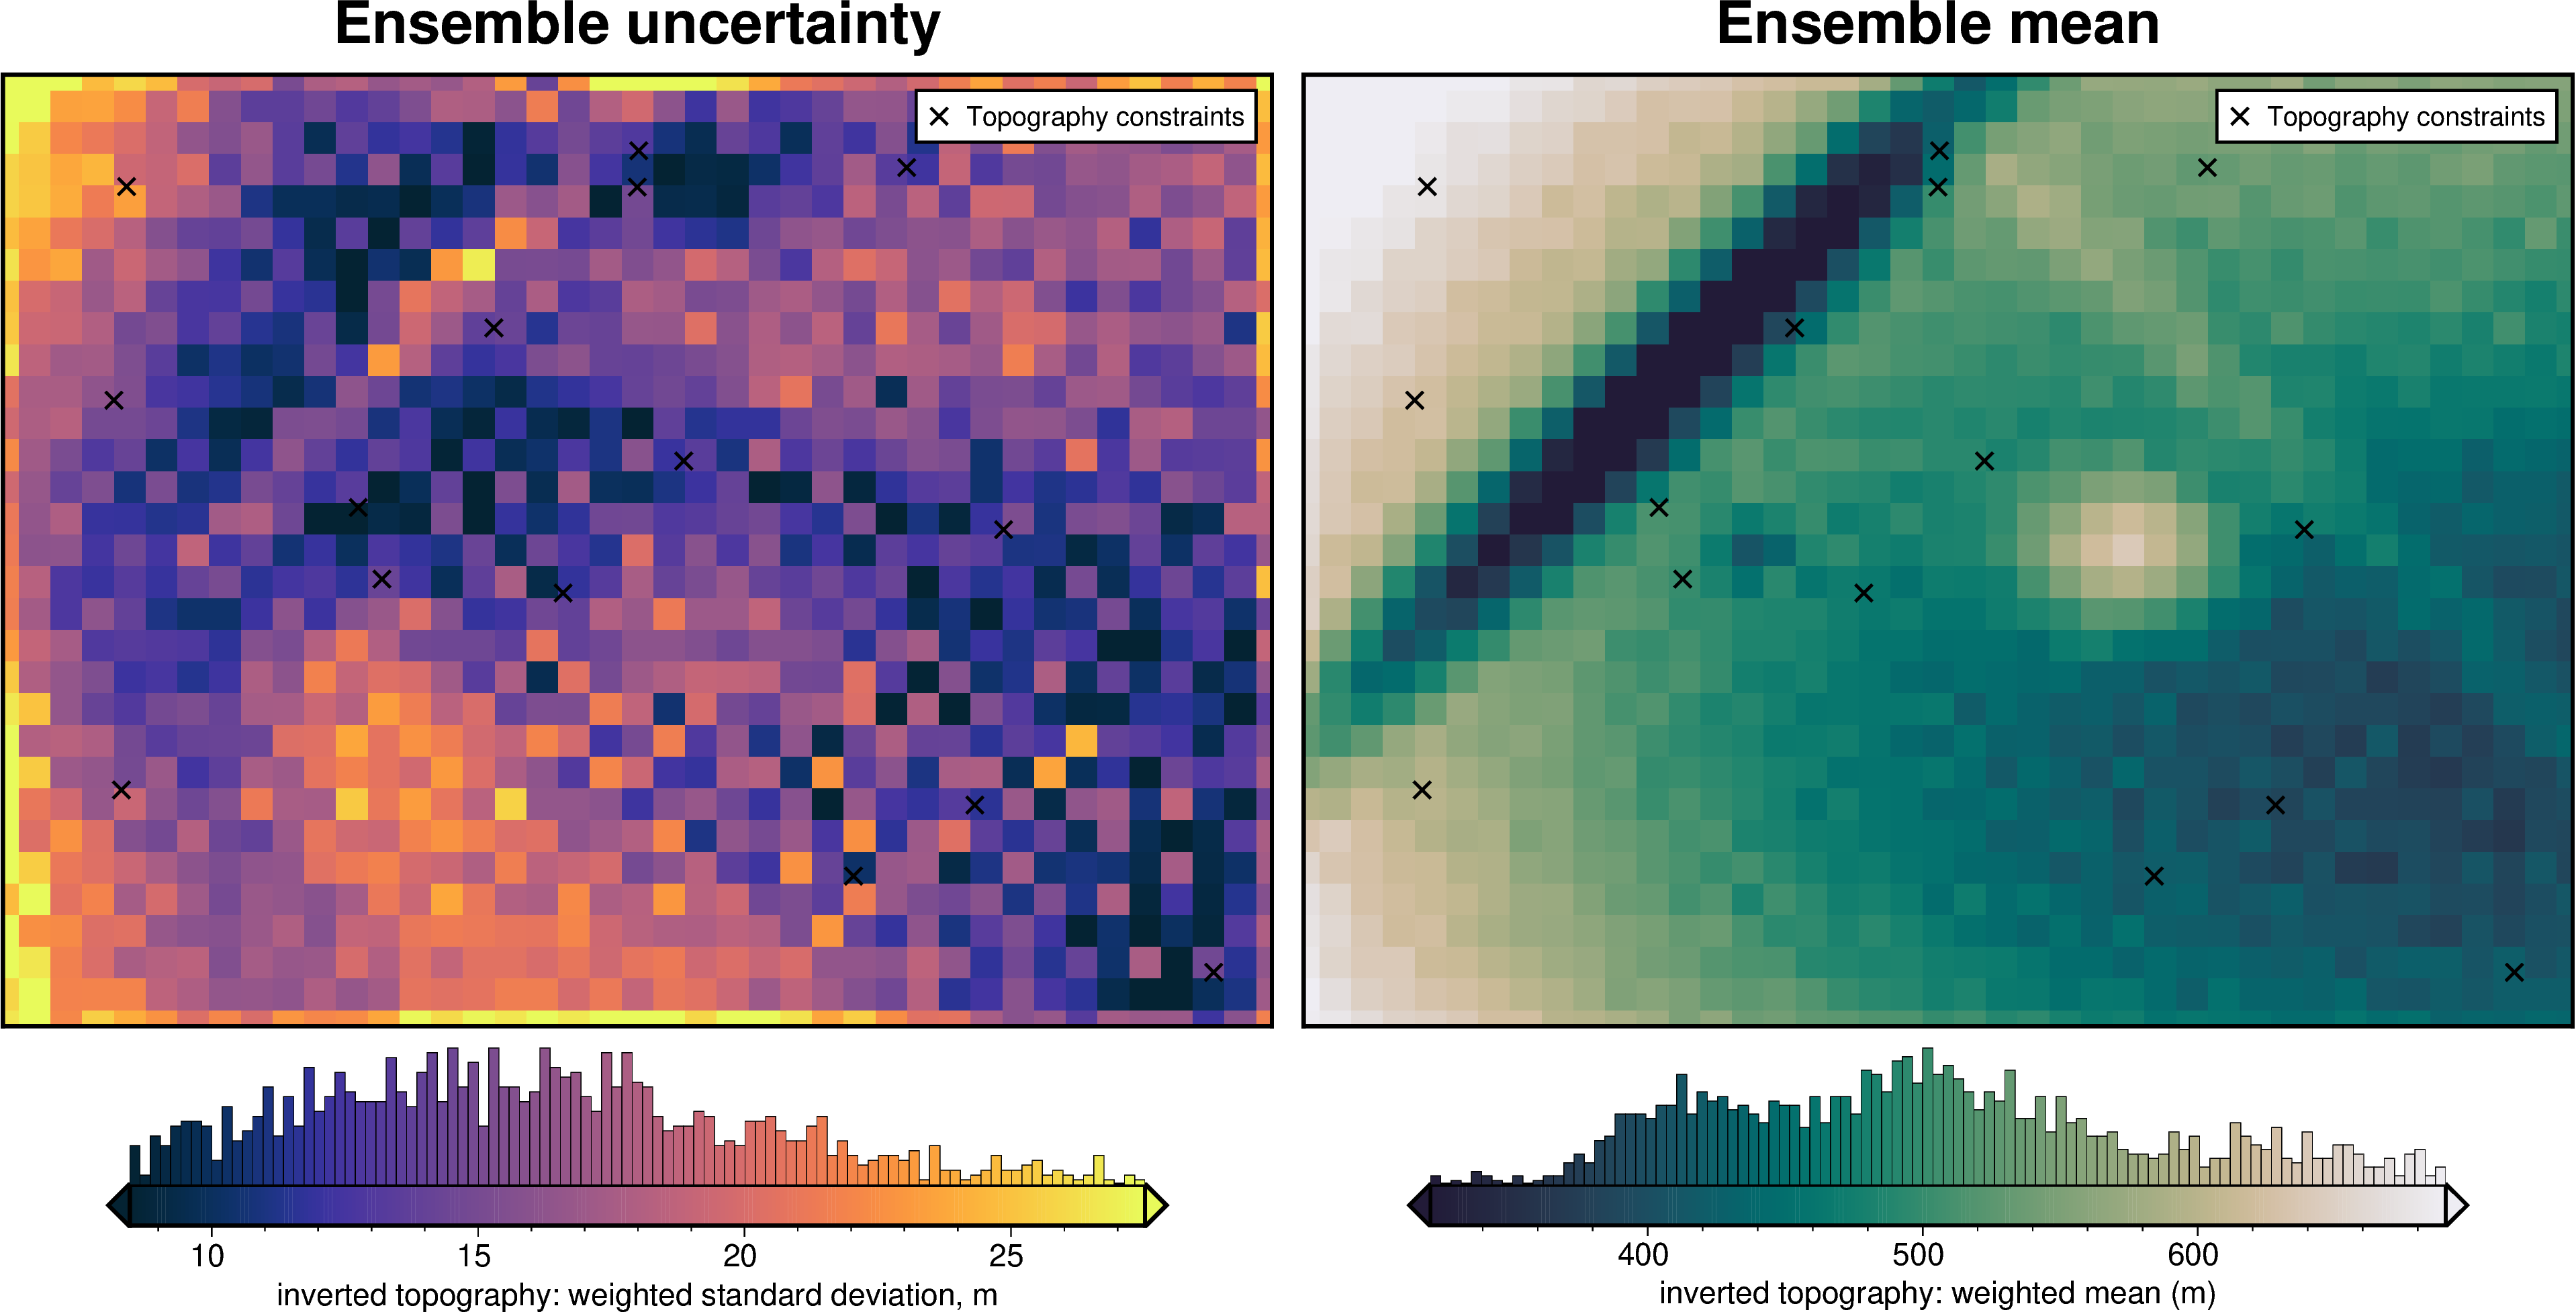

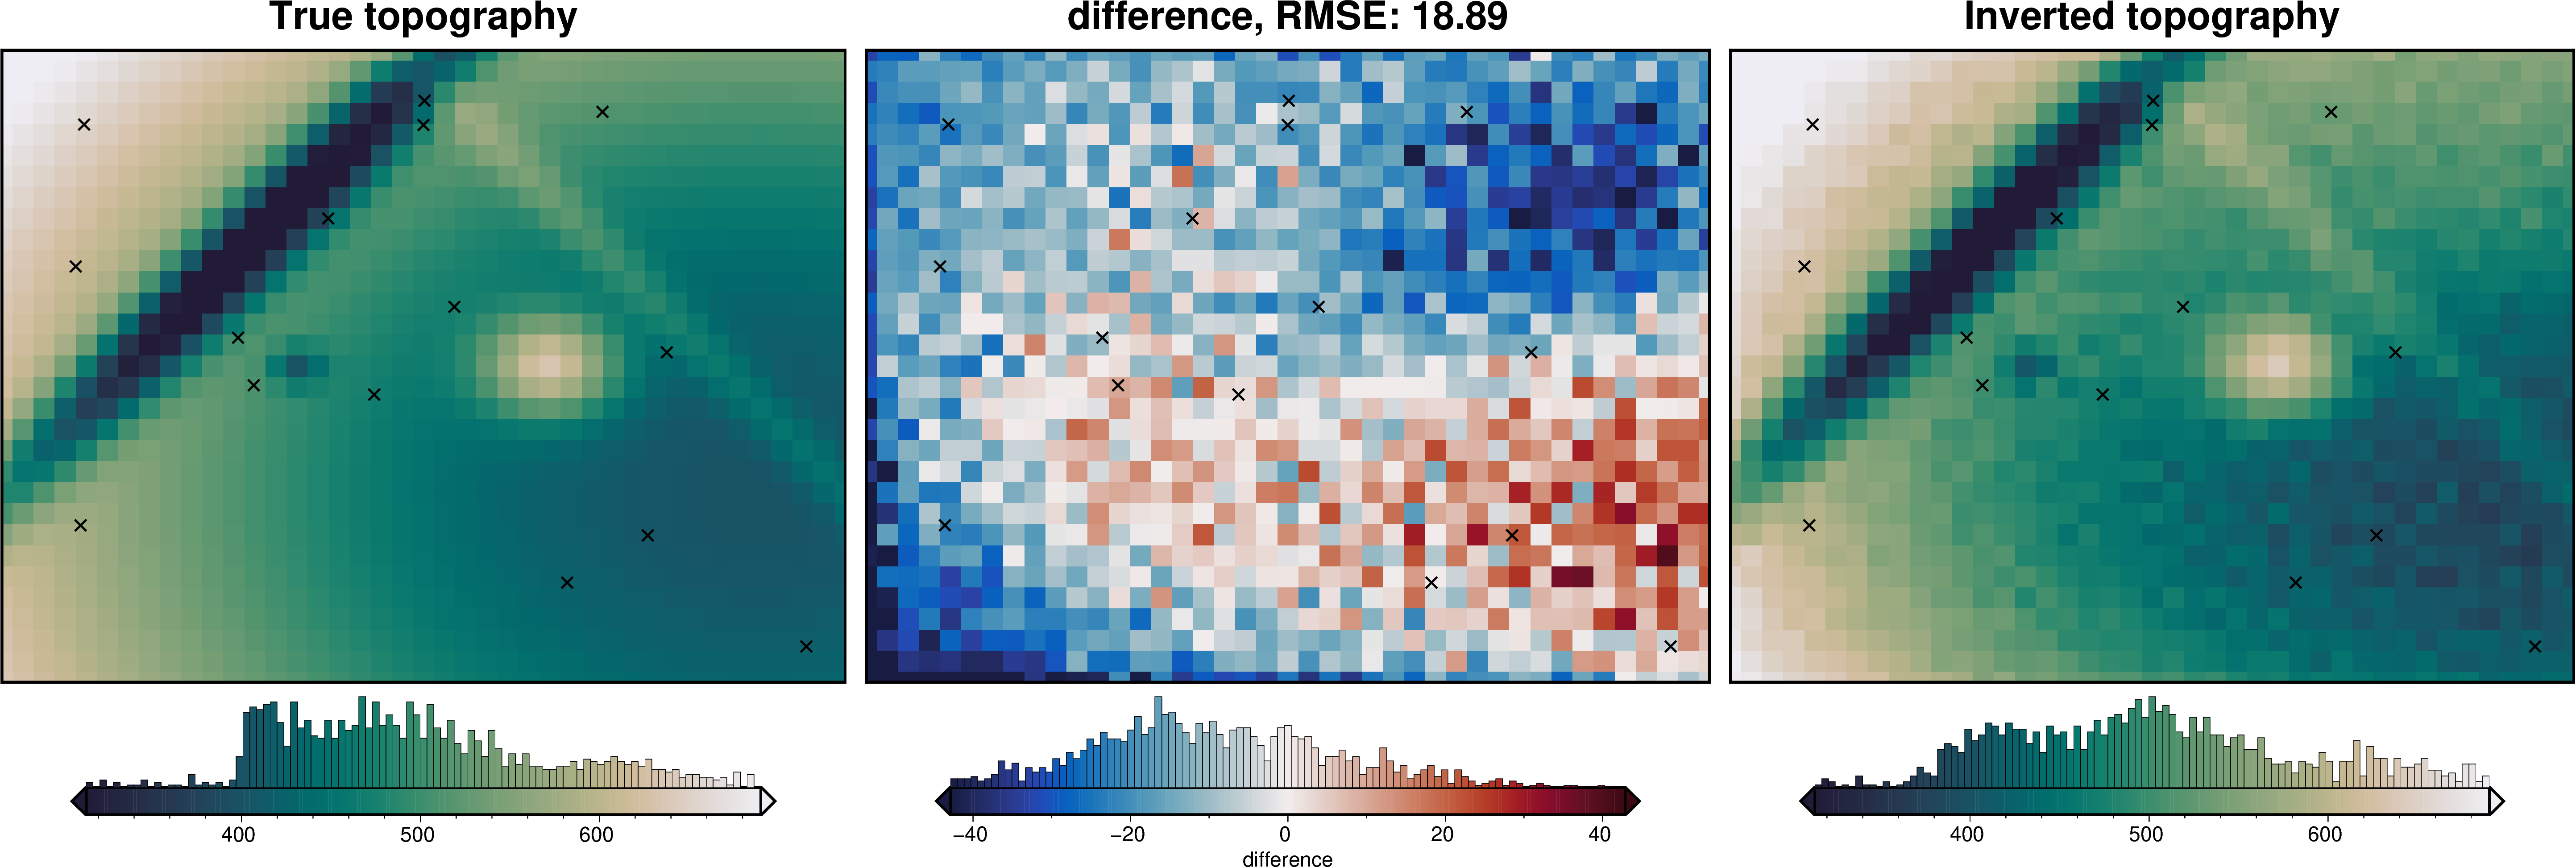

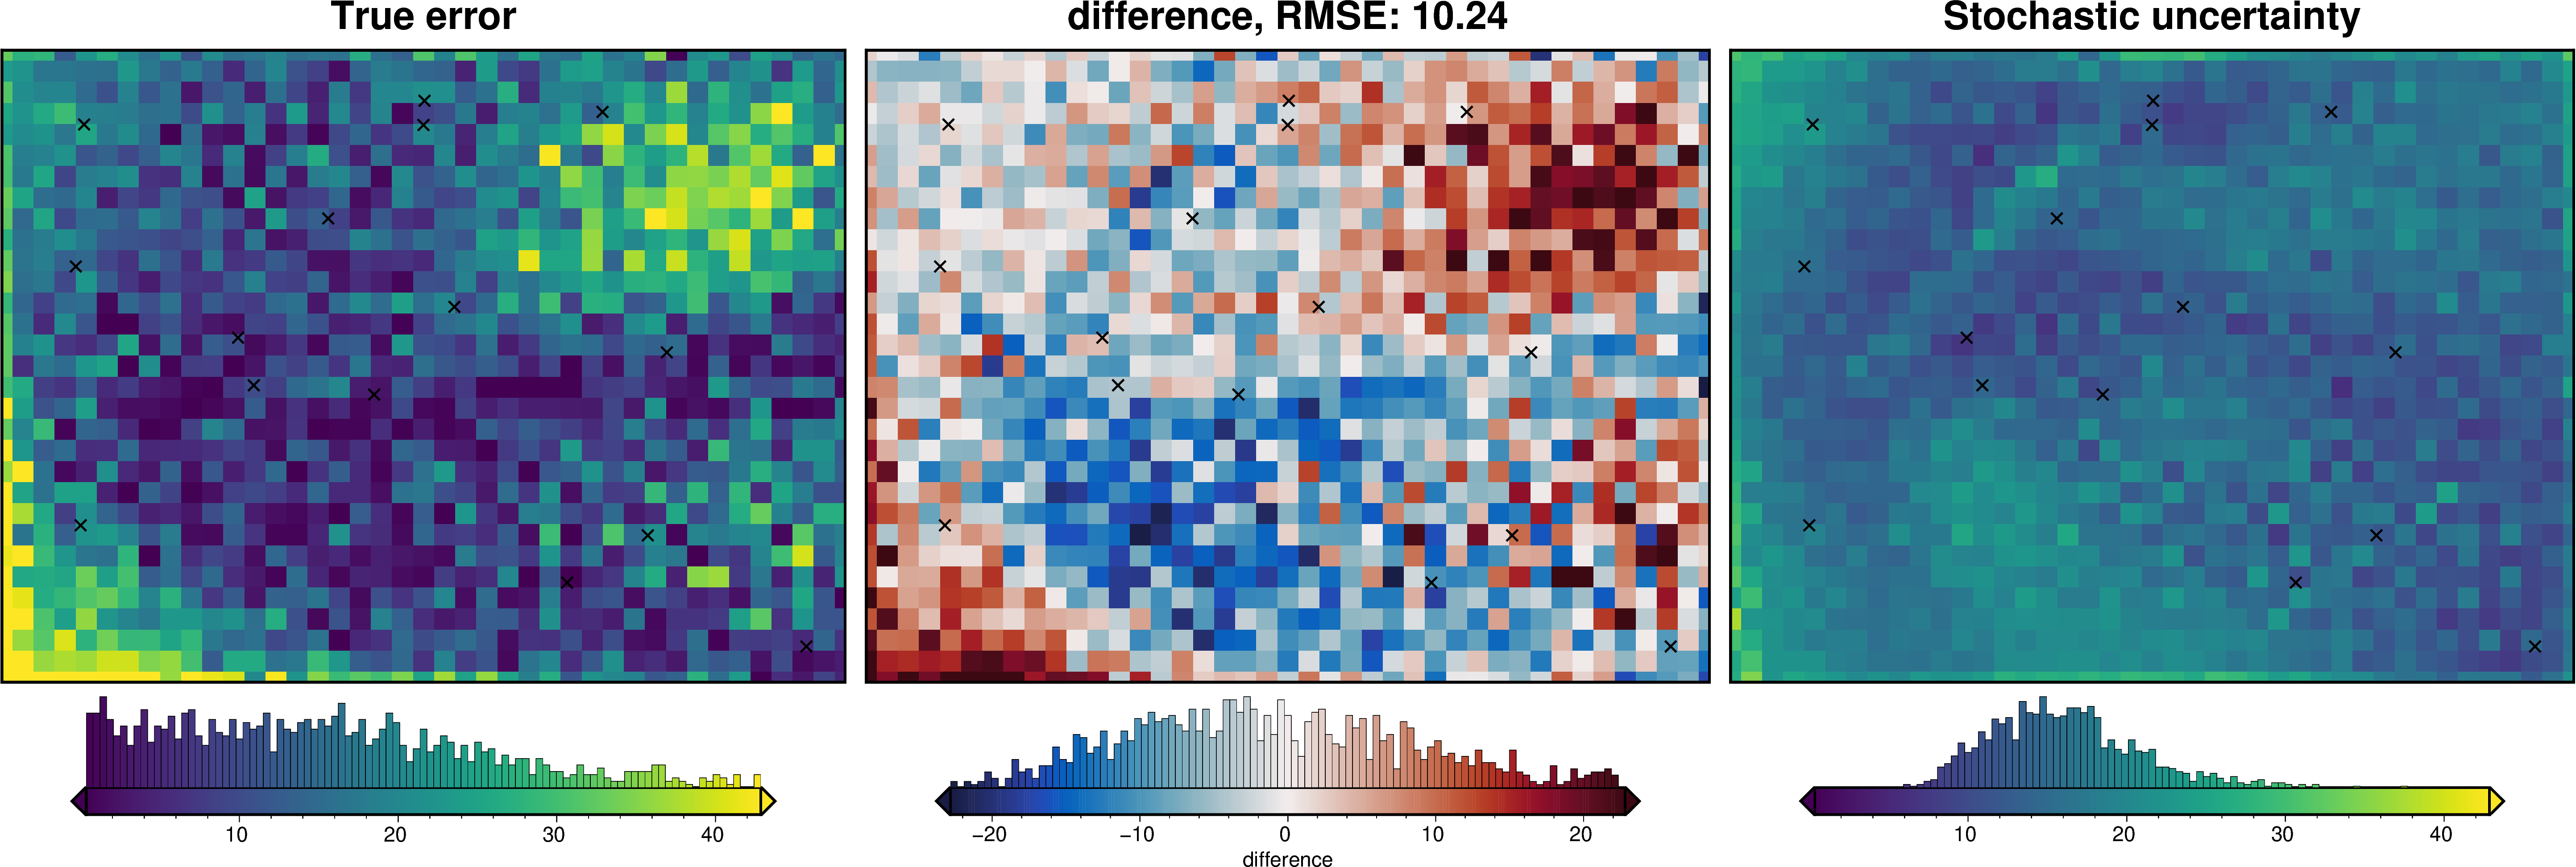

In [31]:
parameter_dict = density_dict | solver_dict

fname = "tmp/uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    sample_gravity=True,
    sample_constraints=True,
    parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **new_kwargs,
)

uncert_plots(uncert_results)

## Comparing results

In [32]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
    uncert_starting_topo_results,
    uncert_regional_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    stats.append(ds)

In [33]:
names = ["full", "grav", "constraints", "density", "damping", "topo", "regional"]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 72kB
Dimensions:            (northing: 31, easting: 41)
Coordinates:
  * northing           (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting            (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    full_stdev         (northing, easting) float64 10kB 26.57 34.67 ... 32.1
    grav_stdev         (northing, easting) float64 10kB 14.65 11.41 ... 17.68
    constraints_stdev  (northing, easting) float64 10kB 42.25 37.28 ... 39.44
    density_stdev      (northing, easting) float64 10kB 11.29 9.592 ... 12.56
    damping_stdev      (northing, easting) float64 10kB 0.05797 ... 0.2798
    topo_stdev         (northing, easting) float64 10kB 24.97 21.58 ... 14.97
    regional_stdev     (northing, easting) float64 10kB 14.32 12.7 ... 16.74

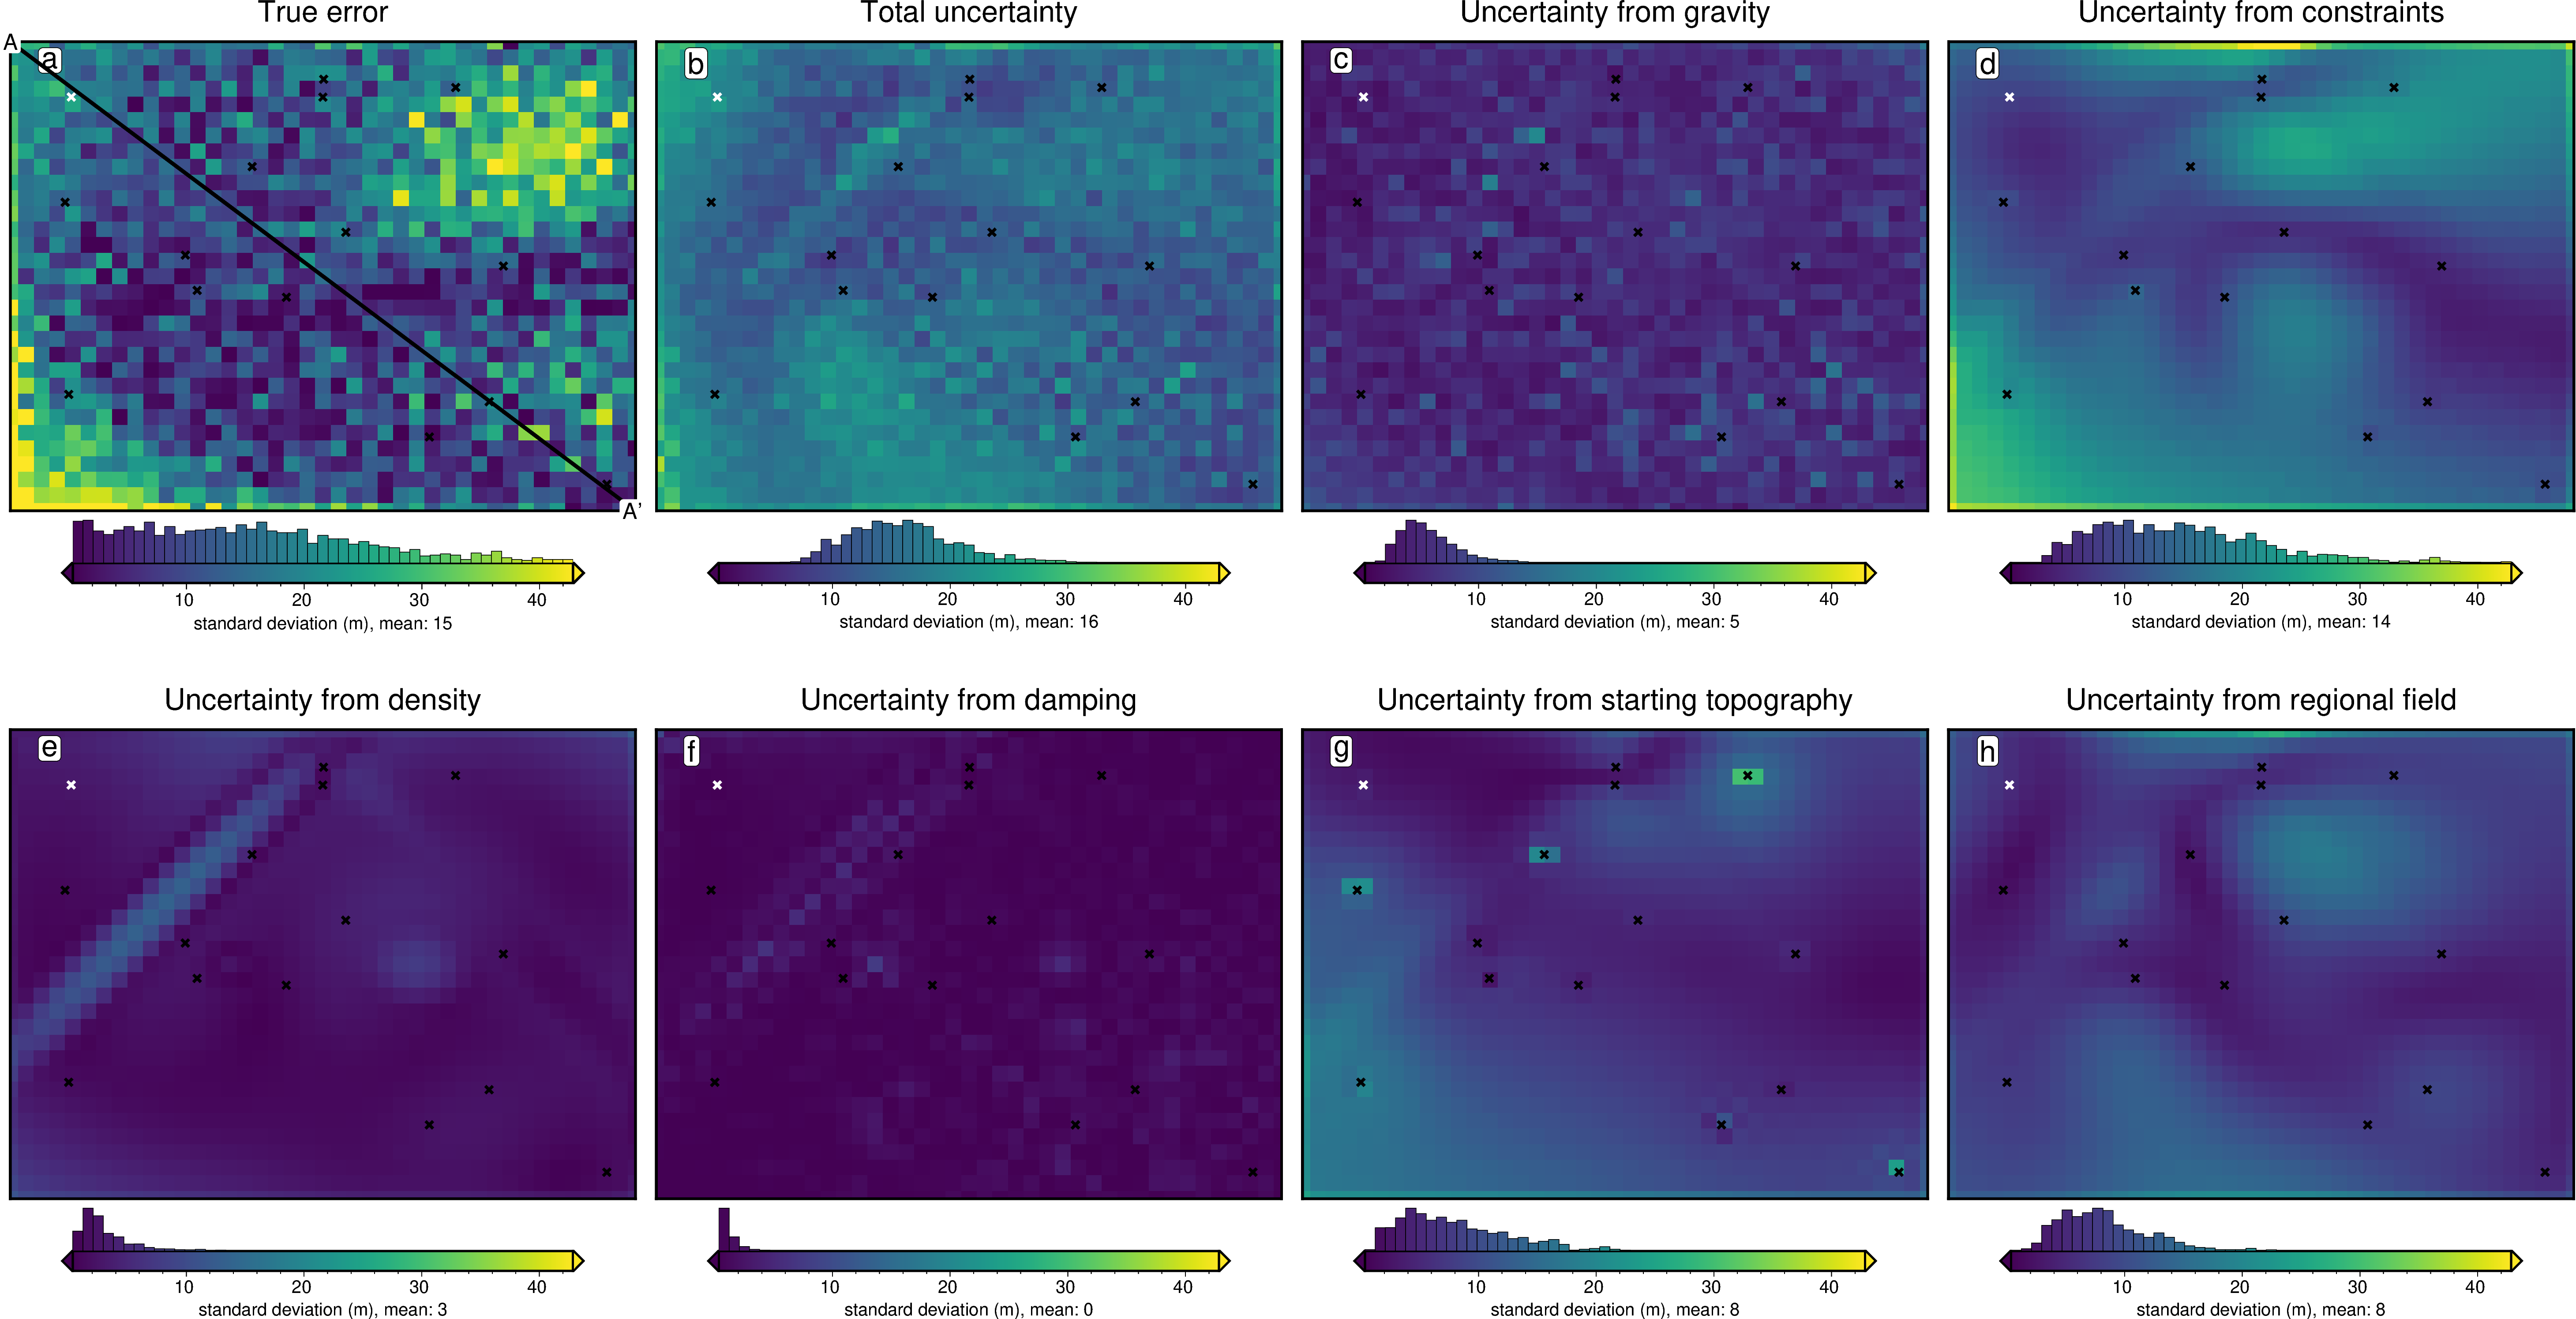

In [34]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
    "Uncertainty from starting topography",
    "Uncertainty from regional field",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - true_topography))
# grids.insert(0, inversion_error)

grids = [
    g.sel(
        {
            "easting": slice(*region[:2]),
            "northing": slice(*region[2:]),
        }
    )
    for g in grids
]

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
        cpt_lims = polar_utils.get_min_max(
            g,
            robust=True,
        )
    elif i == 4:
        origin_shift = "both_shift"
        xshift_amount = -3
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        # cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [region[0], region[3]]
        stop = [region[1], region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

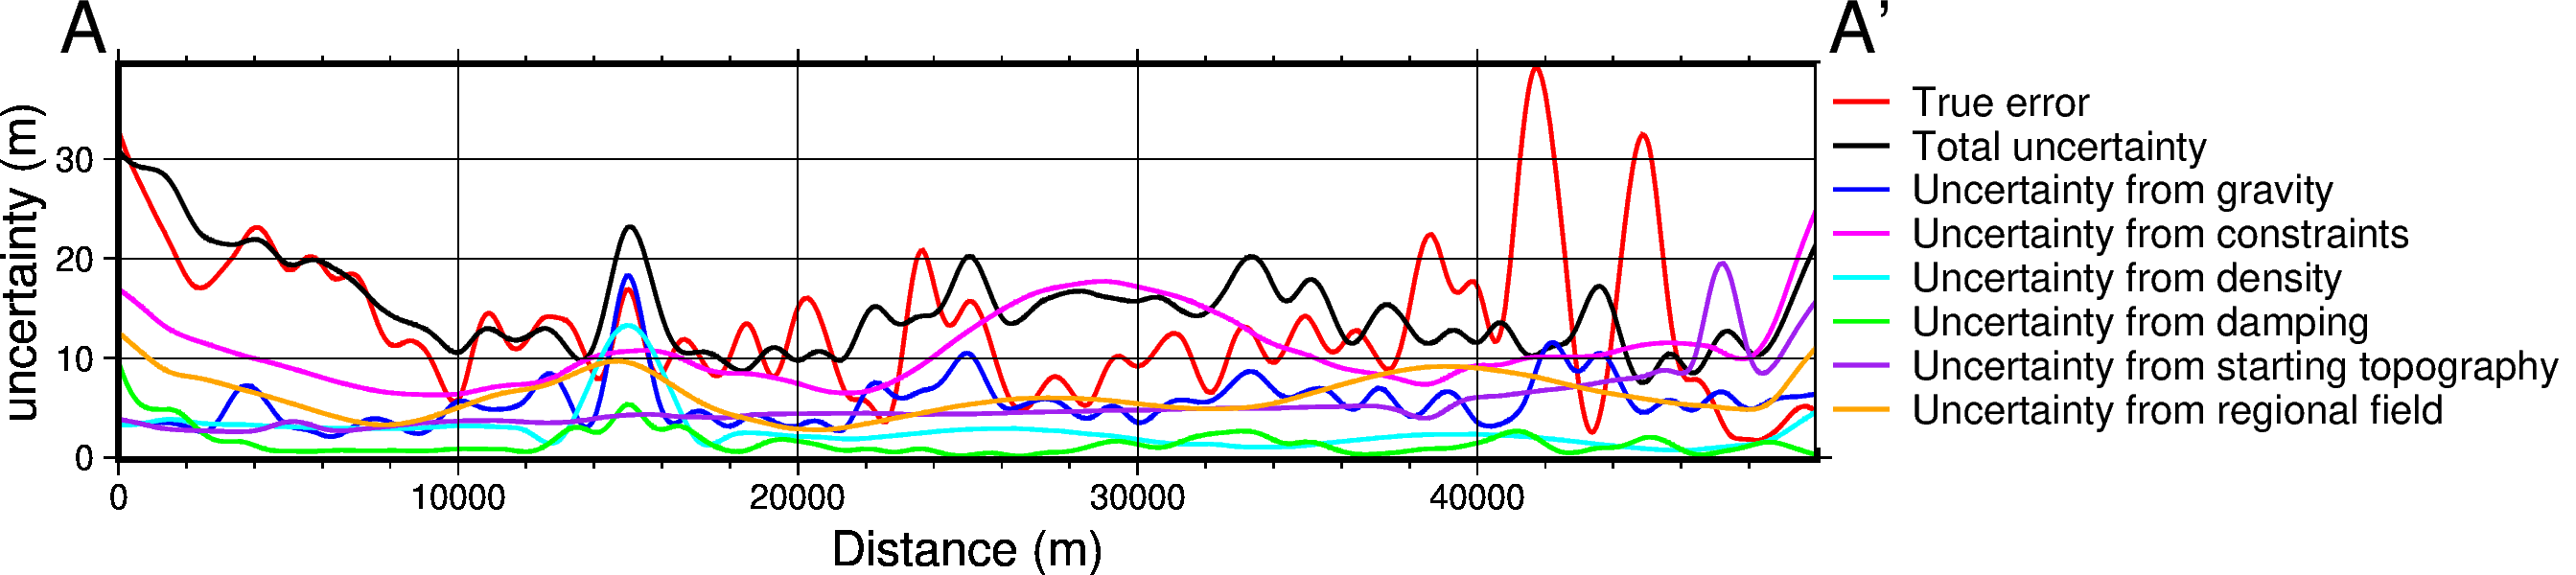

In [35]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
        "orange",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[region[0], region[3]],
    stop=[region[1], region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()